In [1]:
!nvidia-smi

Mon Feb 26 16:04:01 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   47C    P8    18W / 170W |    362MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/bunny/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/crema_d/features/'

In [9]:
data_y = np.load(f'{data_dir}crema_d.label_emotion_key.npy', allow_pickle=True)
np.unique(data_y)

array(['ang', 'dis', 'fea', 'hap', 'neu', 'sad'], dtype=object)

In [10]:
len(data_y)

7442

In [13]:
data_x = np.load(f'{data_dir}crema_d.feature.mfcc128.npy', allow_pickle=True)
len(data_x)

7442

In [37]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(label):
    return label in labels

def label_to_index(label):
    return labels.index(label)
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(w) for w in data_y[filtered_idx]]
print(data_x.shape)

(4900,)


In [38]:
data_y[:10]

[2, 3, 3, 2, 3, 3, 3, 2, 0, 0]

In [39]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3920
Test: 980


In [40]:
x_train[0].shape

(128, 73)

In [41]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [42]:
def label_to_index(word):
    return labels.index(word[:3])

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for mfcc, label in batch:
        tensors += [torch.tensor(
            np.array(mfcc, dtype=float), 
            dtype=torch.float32)]
        targets += [torch.tensor(label, 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [43]:
from omegaconf import OmegaConf as ocf
import traceback

In [44]:
from IConNet.nn.model import M18mfcc as M18

In [61]:
model_config_path = 'config/model/m18.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M18(config=model_config,
           n_input=x_train[0].shape[0], 
            n_output=len(labels))
model

{'name': 'M18', 'description': 'FirConv sequential for speech emotion', 'fe': {'n_block': 2, 'n_channel': [129, 30], 'kernel_size': [127, 63], 'stride': [2, 8], 'window_k': [5, 9], 'mel_resolution': 3, 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 32, 'out_seq_length': 8, 'use_context': True, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm', 'dropout': 0.1}}


M18mfcc(
  (seq_blocks): Seq2MBlocks(
    (blocks): LSTM(128, 32, batch_first=True)
    (pad_layer): PadForConv()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((928,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=928, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [62]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [63]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [64]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                              | 0.0032679738562091504/10 [00:00<25:10, 151.12s/it]

Train Epoch: 1 [0/3920 (0%)]	Loss: 1.922141
Mem before-during-after: 18377728 30148608 45048320


  1%|▉                                                                 | 0.1339869281045752/10 [00:09<11:05, 67.48s/it]

Train Epoch: 1 [640/3920 (16%)]	Loss: 1.241237
Mem before-during-after: 45048320 47448576 45048320


  3%|█▋                                                               | 0.26470588235294074/10 [00:18<10:49, 66.73s/it]

Train Epoch: 1 [1280/3920 (33%)]	Loss: 1.528367
Mem before-during-after: 45048320 48517120 45048320


  4%|██▌                                                               | 0.3954248366013063/10 [00:26<10:41, 66.78s/it]

Train Epoch: 1 [1920/3920 (49%)]	Loss: 0.972771
Mem before-during-after: 45048320 48140800 45048320


  5%|███▍                                                              | 0.5261437908496719/10 [00:35<10:31, 66.66s/it]

Train Epoch: 1 [2560/3920 (65%)]	Loss: 1.053367
Mem before-during-after: 45048320 48099840 45048320


  7%|████▎                                                             | 0.6568627450980374/10 [00:44<10:22, 66.60s/it]

Train Epoch: 1 [3200/3920 (82%)]	Loss: 0.968301
Mem before-during-after: 45048320 48099840 45048320


  8%|█████▎                                                             | 0.787581699346403/10 [00:53<10:13, 66.61s/it]

Train Epoch: 1 [3840/3920 (98%)]	Loss: 1.137628
Mem before-during-after: 45048320 47510016 45048320


 10%|██████▋                                                            | 0.999999999999997/10 [01:06<09:51, 65.74s/it]


Test Epoch: 1	Accuracy: 578/976 (59%)



 10%|██████▌                                                           | 1.0032679738562063/10 [01:07<09:55, 66.16s/it]

Train Epoch: 2 [0/3920 (0%)]	Loss: 0.972434
Mem before-during-after: 45047296 48564224 45048320


 11%|███████▍                                                          | 1.1339869281045718/10 [01:15<09:50, 66.60s/it]

Train Epoch: 2 [640/3920 (16%)]	Loss: 0.552246
Mem before-during-after: 45048320 47469056 45048320


 13%|████████▎                                                         | 1.2647058823529373/10 [01:24<09:45, 67.02s/it]

Train Epoch: 2 [1280/3920 (33%)]	Loss: 0.894736
Mem before-during-after: 45048320 48564224 45048320


 14%|█████████▎                                                         | 1.395424836601303/10 [01:33<09:53, 68.92s/it]

Train Epoch: 2 [1920/3920 (49%)]	Loss: 1.087321
Mem before-during-after: 45048320 47448576 45048320


 15%|██████████                                                        | 1.5261437908496684/10 [01:42<09:28, 67.13s/it]

Train Epoch: 2 [2560/3920 (65%)]	Loss: 1.083997
Mem before-during-after: 45048320 48564224 45048320


 17%|███████████                                                        | 1.656862745098034/10 [01:51<09:22, 67.41s/it]

Train Epoch: 2 [3200/3920 (82%)]	Loss: 0.779641
Mem before-during-after: 45048320 47510016 45048320


 18%|███████████▊                                                      | 1.7875816993463995/10 [01:59<09:14, 67.47s/it]

Train Epoch: 2 [3840/3920 (98%)]	Loss: 1.232813
Mem before-during-after: 45048320 47530496 45048320


 20%|█████████████▏                                                    | 1.9999999999999936/10 [02:14<08:43, 65.42s/it]


Test Epoch: 2	Accuracy: 618/976 (63%)



 20%|█████████████▍                                                     | 2.003267973856203/10 [02:14<08:45, 65.74s/it]

Train Epoch: 3 [0/3920 (0%)]	Loss: 0.737930
Mem before-during-after: 45047296 47489536 45048320


 21%|██████████████                                                    | 2.1339869281045685/10 [02:22<08:48, 67.15s/it]

Train Epoch: 3 [640/3920 (16%)]	Loss: 0.920530
Mem before-during-after: 45048320 48363520 45048320


 23%|███████████████▏                                                   | 2.264705882352934/10 [02:31<08:39, 67.12s/it]

Train Epoch: 3 [1280/3920 (33%)]	Loss: 0.689262
Mem before-during-after: 45048320 48593408 45048320


 24%|███████████████▊                                                  | 2.3954248366012996/10 [02:40<08:32, 67.45s/it]

Train Epoch: 3 [1920/3920 (49%)]	Loss: 0.647991
Mem before-during-after: 45048320 48084992 45048320


 25%|████████████████▉                                                  | 2.526143790849665/10 [02:49<08:22, 67.25s/it]

Train Epoch: 3 [2560/3920 (65%)]	Loss: 0.823177
Mem before-during-after: 45048320 48517120 45048320


 27%|█████████████████▌                                                | 2.6568627450980307/10 [02:58<08:12, 67.13s/it]

Train Epoch: 3 [3200/3920 (82%)]	Loss: 0.434062
Mem before-during-after: 45048320 48115712 45048320


 28%|██████████████████▋                                                | 2.787581699346396/10 [03:06<08:02, 66.91s/it]

Train Epoch: 3 [3840/3920 (98%)]	Loss: 0.717873
Mem before-during-after: 45048320 47585792 45048320


 30%|███████████████████▊                                              | 2.9999999999999902/10 [03:21<07:46, 66.68s/it]


Test Epoch: 3	Accuracy: 637/976 (65%)



 30%|███████████████████▊                                              | 3.0032679738561994/10 [03:21<07:49, 67.10s/it]

Train Epoch: 4 [0/3920 (0%)]	Loss: 0.509449
Mem before-during-after: 45047296 48140800 45048320


 31%|████████████████████▉                                              | 3.133986928104565/10 [03:30<07:45, 67.84s/it]

Train Epoch: 4 [640/3920 (16%)]	Loss: 0.997530
Mem before-during-after: 45048320 48517120 45048320


 33%|█████████████████████▌                                            | 3.2647058823529305/10 [03:39<07:40, 68.33s/it]

Train Epoch: 4 [1280/3920 (33%)]	Loss: 1.131039
Mem before-during-after: 45048320 47585792 45048320


 34%|██████████████████████▋                                            | 3.395424836601296/10 [03:47<07:26, 67.59s/it]

Train Epoch: 4 [1920/3920 (49%)]	Loss: 0.757698
Mem before-during-after: 45048320 48162816 45048320


 35%|███████████████████████▎                                          | 3.5261437908496616/10 [03:56<07:24, 68.64s/it]

Train Epoch: 4 [2560/3920 (65%)]	Loss: 1.234622
Mem before-during-after: 45048320 48455680 45048320


 37%|████████████████████████▌                                          | 3.656862745098027/10 [04:05<07:05, 67.06s/it]

Train Epoch: 4 [3200/3920 (82%)]	Loss: 1.116774
Mem before-during-after: 45048320 47647232 45048320


 38%|████████████████████████▉                                         | 3.7875816993463927/10 [04:14<06:58, 67.31s/it]

Train Epoch: 4 [3840/3920 (98%)]	Loss: 0.455899
Mem before-during-after: 45048320 48394240 45048320


 40%|██████████████████████████▍                                       | 3.9999999999999867/10 [04:28<06:46, 67.83s/it]


Test Epoch: 4	Accuracy: 617/976 (63%)



 40%|██████████████████████████▊                                        | 4.003267973856196/10 [04:28<06:50, 68.39s/it]

Train Epoch: 5 [0/3920 (0%)]	Loss: 0.650198
Mem before-during-after: 45047296 47923712 45048320


 41%|███████████████████████████▋                                       | 4.133986928104561/10 [04:37<06:36, 67.57s/it]

Train Epoch: 5 [640/3920 (16%)]	Loss: 0.639918
Mem before-during-after: 45048320 47489536 45048320


 43%|████████████████████████████▌                                      | 4.264705882352927/10 [04:46<06:30, 68.15s/it]

Train Epoch: 5 [1280/3920 (33%)]	Loss: 0.517012
Mem before-during-after: 45048320 47626752 45048320


 44%|█████████████████████████████                                     | 4.3954248366012925/10 [04:55<06:16, 67.14s/it]

Train Epoch: 5 [1920/3920 (49%)]	Loss: 0.792443
Mem before-during-after: 45048320 47626752 45048320


 45%|██████████████████████████████▎                                    | 4.526143790849658/10 [05:04<06:04, 66.63s/it]

Train Epoch: 5 [2560/3920 (65%)]	Loss: 0.588360
Mem before-during-after: 45048320 47428096 45048320


 47%|███████████████████████████████▏                                   | 4.656862745098024/10 [05:12<06:01, 67.64s/it]

Train Epoch: 5 [3200/3920 (82%)]	Loss: 0.659190
Mem before-during-after: 45048320 48254976 45048320


 48%|████████████████████████████████                                   | 4.787581699346389/10 [05:22<06:02, 69.58s/it]

Train Epoch: 5 [3840/3920 (98%)]	Loss: 0.933997
Mem before-during-after: 45048320 48162816 45048320


 50%|█████████████████████████████████▍                                 | 4.999999999999983/10 [05:36<05:32, 66.42s/it]


Test Epoch: 5	Accuracy: 629/976 (64%)



 50%|█████████████████████████████████▌                                 | 5.003267973856192/10 [05:36<05:34, 66.90s/it]

Train Epoch: 6 [0/3920 (0%)]	Loss: 0.499343
Mem before-during-after: 45047296 48424960 45048320


 51%|██████████████████████████████████▍                                | 5.133986928104558/10 [05:45<05:26, 67.15s/it]

Train Epoch: 6 [640/3920 (16%)]	Loss: 0.956137
Mem before-during-after: 45048320 47489536 45048320


 53%|███████████████████████████████████▎                               | 5.264705882352923/10 [05:54<05:16, 66.82s/it]

Train Epoch: 6 [1280/3920 (33%)]	Loss: 0.362875
Mem before-during-after: 45048320 48486400 45048320


 54%|████████████████████████████████████▏                              | 5.395424836601289/10 [06:03<05:11, 67.68s/it]

Train Epoch: 6 [1920/3920 (49%)]	Loss: 0.583083
Mem before-during-after: 45048320 47469056 45048320


 55%|████████████████████████████████████▍                             | 5.5261437908496545/10 [06:11<04:58, 66.69s/it]

Train Epoch: 6 [2560/3920 (65%)]	Loss: 0.876732
Mem before-during-after: 45048320 47469056 45048320


 57%|██████████████████████████████████████▍                             | 5.65686274509802/10 [06:20<05:01, 69.46s/it]

Train Epoch: 6 [3200/3920 (82%)]	Loss: 1.442302
Mem before-during-after: 45048320 47606272 45048320


 58%|██████████████████████████████████████▏                           | 5.7875816993463856/10 [06:29<04:44, 67.64s/it]

Train Epoch: 6 [3840/3920 (98%)]	Loss: 0.646770
Mem before-during-after: 45048320 47585792 45048320


 60%|████████████████████████████████████████▊                           | 5.99999999999998/10 [06:43<04:30, 67.67s/it]


Test Epoch: 6	Accuracy: 595/976 (61%)



 60%|████████████████████████████████████████▏                          | 6.003267973856189/10 [06:44<04:32, 68.19s/it]

Train Epoch: 7 [0/3920 (0%)]	Loss: 0.659063
Mem before-during-after: 45047296 48594944 45048320


 61%|█████████████████████████████████████████                          | 6.133986928104554/10 [06:52<04:17, 66.63s/it]

Train Epoch: 7 [640/3920 (16%)]	Loss: 0.462994
Mem before-during-after: 45048320 47530496 45048320


 63%|██████████████████████████████████████████▌                         | 6.26470588235292/10 [07:01<04:10, 67.05s/it]

Train Epoch: 7 [1280/3920 (33%)]	Loss: 0.572905
Mem before-during-after: 45048320 47489536 45048320


 64%|██████████████████████████████████████████▊                        | 6.395424836601285/10 [07:10<04:01, 67.10s/it]

Train Epoch: 7 [1920/3920 (49%)]	Loss: 0.702833
Mem before-during-after: 45048320 48099840 45048320


 65%|███████████████████████████████████████████▋                       | 6.526143790849651/10 [07:19<03:53, 67.21s/it]

Train Epoch: 7 [2560/3920 (65%)]	Loss: 0.824436
Mem before-during-after: 45048320 48455680 45048320


 67%|███████████████████████████████████████████▉                      | 6.6568627450980165/10 [07:28<03:48, 68.23s/it]

Train Epoch: 7 [3200/3920 (82%)]	Loss: 0.986453
Mem before-during-after: 45048320 48486400 45048320


 68%|█████████████████████████████████████████████▍                     | 6.787581699346382/10 [07:36<03:36, 67.38s/it]

Train Epoch: 7 [3840/3920 (98%)]	Loss: 0.462726
Mem before-during-after: 45048320 48224256 45048320


 70%|██████████████████████████████████████████████▉                    | 6.999999999999976/10 [07:51<03:21, 67.27s/it]


Test Epoch: 7	Accuracy: 637/976 (65%)



 70%|██████████████████████████████████████████████▉                    | 7.003267973856185/10 [07:51<03:23, 67.85s/it]

Train Epoch: 8 [0/3920 (0%)]	Loss: 0.620126
Mem before-during-after: 45047296 48564224 45048320


 71%|███████████████████████████████████████████████▊                   | 7.133986928104551/10 [08:00<03:15, 68.21s/it]

Train Epoch: 8 [640/3920 (16%)]	Loss: 1.406471
Mem before-during-after: 45048320 48564224 45048320


 73%|████████████████████████████████████████████████▋                  | 7.264705882352916/10 [08:09<03:05, 67.82s/it]

Train Epoch: 8 [1280/3920 (33%)]	Loss: 0.777696
Mem before-during-after: 45048320 47063552 45048320


 74%|█████████████████████████████████████████████████▌                 | 7.395424836601282/10 [08:18<02:56, 67.75s/it]

Train Epoch: 8 [1920/3920 (49%)]	Loss: 1.291991
Mem before-during-after: 45048320 48486400 45048320


 75%|██████████████████████████████████████████████████▍                | 7.526143790849647/10 [08:27<02:48, 68.11s/it]

Train Epoch: 8 [2560/3920 (65%)]	Loss: 0.458743
Mem before-during-after: 45048320 48394240 45048320


 77%|███████████████████████████████████████████████████▎               | 7.656862745098013/10 [08:35<02:38, 67.58s/it]

Train Epoch: 8 [3200/3920 (82%)]	Loss: 1.004765
Mem before-during-after: 45048320 48394240 45048320


 78%|███████████████████████████████████████████████████▍              | 7.7875816993463784/10 [08:44<02:29, 67.80s/it]

Train Epoch: 8 [3840/3920 (98%)]	Loss: 0.869949
Mem before-during-after: 45048320 48394240 45048320


 80%|████████████████████████████████████████████████████▊             | 7.9999999999999725/10 [08:59<02:14, 67.06s/it]


Test Epoch: 8	Accuracy: 639/976 (65%)



 80%|█████████████████████████████████████████████████████▌             | 8.003267973856182/10 [08:59<02:15, 67.65s/it]

Train Epoch: 9 [0/3920 (0%)]	Loss: 0.487371
Mem before-during-after: 45047296 47606272 45048320


 81%|██████████████████████████████████████████████████████▍            | 8.133986928104548/10 [09:08<02:06, 67.71s/it]

Train Epoch: 9 [640/3920 (16%)]	Loss: 0.987913
Mem before-during-after: 45048320 47372800 45048320


 83%|███████████████████████████████████████████████████████▎           | 8.264705882352914/10 [09:17<01:56, 67.27s/it]

Train Epoch: 9 [1280/3920 (33%)]	Loss: 0.612516
Mem before-during-after: 45048320 48486400 45048320


 84%|█████████████████████████████████████████████████████████           | 8.39542483660128/10 [09:25<01:47, 66.96s/it]

Train Epoch: 9 [1920/3920 (49%)]	Loss: 0.331742
Mem before-during-after: 45048320 47510016 45048320


 85%|█████████████████████████████████████████████████████████▏         | 8.526143790849645/10 [09:34<01:38, 67.06s/it]

Train Epoch: 9 [2560/3920 (65%)]	Loss: 0.625973
Mem before-during-after: 45048320 48084992 45048320


 87%|██████████████████████████████████████████████████████████▊         | 8.65686274509801/10 [09:43<01:30, 67.29s/it]

Train Epoch: 9 [3200/3920 (82%)]	Loss: 0.235606
Mem before-during-after: 45048320 47626752 45048320


 88%|██████████████████████████████████████████████████████████▉        | 8.787581699346376/10 [09:52<01:20, 66.60s/it]

Train Epoch: 9 [3840/3920 (98%)]	Loss: 0.519076
Mem before-during-after: 45048320 47606272 45048320


 90%|█████████████████████████████████████████████████████████████▏      | 8.99999999999997/10 [10:06<01:06, 66.19s/it]


Test Epoch: 9	Accuracy: 650/976 (66%)



 90%|████████████████████████████████████████████████████████████▎      | 9.003267973856179/10 [10:06<01:06, 66.46s/it]

Train Epoch: 10 [0/3920 (0%)]	Loss: 0.709640
Mem before-during-after: 45047296 47469056 45048320


 91%|█████████████████████████████████████████████████████████████▏     | 9.133986928104544/10 [10:15<00:58, 67.32s/it]

Train Epoch: 10 [640/3920 (16%)]	Loss: 0.499709
Mem before-during-after: 45048320 48237056 45048320


 93%|██████████████████████████████████████████████████████████████▉     | 9.26470588235291/10 [10:24<00:50, 68.27s/it]

Train Epoch: 10 [1280/3920 (33%)]	Loss: 0.828876
Mem before-during-after: 45048320 48210432 45048320


 94%|██████████████████████████████████████████████████████████████▉    | 9.395424836601276/10 [10:32<00:40, 66.46s/it]

Train Epoch: 10 [1920/3920 (49%)]	Loss: 0.931513
Mem before-during-after: 45048320 47647232 45048320


 95%|███████████████████████████████████████████████████████████████▊   | 9.526143790849641/10 [10:41<00:31, 67.13s/it]

Train Epoch: 10 [2560/3920 (65%)]	Loss: 0.819510
Mem before-during-after: 45048320 47626752 45048320


 97%|████████████████████████████████████████████████████████████████▋  | 9.656862745098007/10 [10:50<00:23, 67.24s/it]

Train Epoch: 10 [3200/3920 (82%)]	Loss: 0.975154
Mem before-during-after: 45048320 47352320 45048320


 98%|█████████████████████████████████████████████████████████████████▌ | 9.787581699346372/10 [10:59<00:14, 67.81s/it]

Train Epoch: 10 [3840/3920 (98%)]	Loss: 0.509461
Mem before-during-after: 45048320 47647232 45048320


100%|██████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [11:13<00:00, 67.34s/it]


Test Epoch: 10	Accuracy: 635/976 (65%)



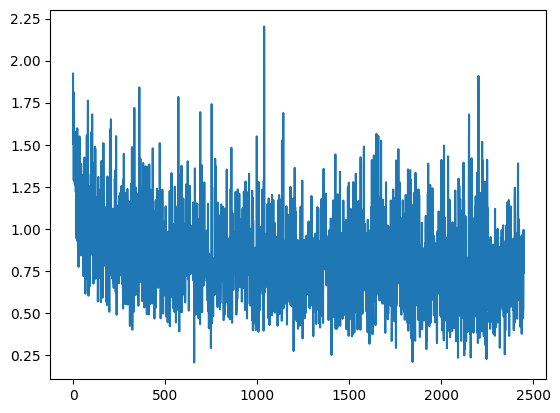

In [65]:
plt.plot(train_losses)

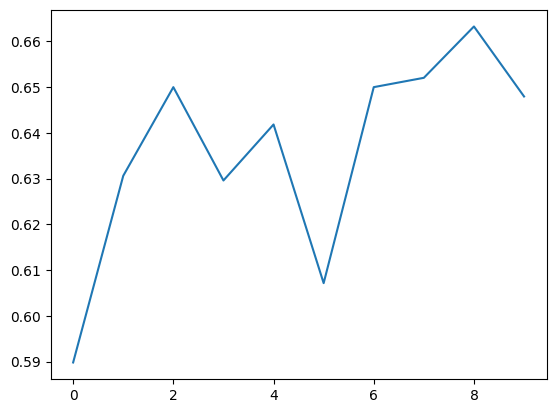

In [66]:
plt.plot(test_accuracy)

In [67]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [68]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 635/976 (0.6506)
{'acc_detail': tensor([0.5138, 0.7143, 0.6457, 0.7381], device='cuda:0'),
 'acc_unweighted': tensor(0.6530, device='cuda:0'),
 'acc_weighted': tensor(0.6506, device='cuda:0'),
 'f1s': tensor(0.6542, device='cuda:0'),
 'f1s_detail': tensor([0.6468, 0.6418, 0.7193, 0.6088], device='cuda:0'),
 'precision_detail': tensor([0.8725, 0.5827, 0.8119, 0.5181], device='cuda:0'),
 'recall_detail': tensor([0.5138, 0.7143, 0.6457, 0.7381], device='cuda:0'),
 'rocauc': tensor([0.9255, 0.8774, 0.9225, 0.8362], device='cuda:0'),
 'uar': tensor(0.6530, device='cuda:0'),
 'wap': tensor(0.7008, device='cuda:0')}


tensor([[130,   7,   1, 115],
        [  0, 155,  28,  34],
        [  0,  66, 164,  24],
        [ 19,  38,   9, 186]], device='cuda:0')

In [71]:
model_path = '../models_cremad4_mfcc/cremad_label4_m18mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [72]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4_mfcc/cremad_label4_m18mfcc_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                             | 0.0032679738562091504/50 [00:00<1:02:03, 74.48s/it]

Train Epoch: 11 [0/3920 (0%)]	Loss: 0.541975
Mem before-during-after: 38642176 41257472 44314624


  0%|▏                                                               | 0.1339869281045752/50 [00:09<1:00:31, 72.82s/it]

Train Epoch: 11 [640/3920 (16%)]	Loss: 0.887251
Mem before-during-after: 44314624 47503360 44314624


  1%|▎                                                              | 0.26470588235294074/50 [00:19<1:00:27, 72.94s/it]

Train Epoch: 11 [1280/3920 (33%)]	Loss: 0.400396
Mem before-during-after: 44314624 46913536 44314624


  1%|▌                                                               | 0.3954248366013063/50 [00:28<1:00:29, 73.16s/it]

Train Epoch: 11 [1920/3920 (49%)]	Loss: 0.427747
Mem before-during-after: 44314624 47154688 44314624


  1%|▋                                                               | 0.5261437908496719/50 [00:38<1:00:50, 73.79s/it]

Train Epoch: 11 [2560/3920 (65%)]	Loss: 1.206517
Mem before-during-after: 44314624 46694400 44314624


  1%|▊                                                                 | 0.6568627450980374/50 [00:48<59:56, 72.88s/it]

Train Epoch: 11 [3200/3920 (82%)]	Loss: 0.589487
Mem before-during-after: 44314624 47582720 44314624


  2%|█                                                                  | 0.787581699346403/50 [00:57<59:26, 72.48s/it]

Train Epoch: 11 [3840/3920 (98%)]	Loss: 0.769257
Mem before-during-after: 44314624 46714880 44314624


  2%|█▎                                                                 | 0.999999999999997/50 [01:12<58:10, 71.23s/it]


Test Epoch: 11	Accuracy: 653/976 (67%)

saved model: ../models_cremad4_mfcc/cremad_label4_m18mfcc_best_11epoch.pt


  2%|█▎                                                                | 1.0032679738562063/50 [01:13<59:02, 72.31s/it]

Train Epoch: 12 [0/3920 (0%)]	Loss: 0.689700
Mem before-during-after: 44313600 47190016 44314624


  2%|█▍                                                                | 1.1339869281045718/50 [01:22<58:52, 72.29s/it]

Train Epoch: 12 [640/3920 (16%)]	Loss: 0.579270
Mem before-during-after: 44314624 47830528 44314624


  3%|█▌                                                              | 1.2647058823529373/50 [01:32<1:00:09, 74.07s/it]

Train Epoch: 12 [1280/3920 (33%)]	Loss: 0.624853
Mem before-during-after: 44314624 47459840 44314624


  3%|█▊                                                                 | 1.395424836601303/50 [01:41<59:24, 73.33s/it]

Train Epoch: 12 [1920/3920 (49%)]	Loss: 0.660604
Mem before-during-after: 44314624 47407104 44314624


  3%|██                                                                | 1.5261437908496684/50 [01:51<58:50, 72.84s/it]

Train Epoch: 12 [2560/3920 (65%)]	Loss: 0.516156
Mem before-during-after: 44314624 46598144 44314624


  3%|██▏                                                                | 1.656862745098034/50 [02:01<59:10, 73.45s/it]

Train Epoch: 12 [3200/3920 (82%)]	Loss: 0.816909
Mem before-during-after: 44314624 47721984 44314624


  4%|██▎                                                               | 1.7875816993463995/50 [02:10<58:59, 73.42s/it]

Train Epoch: 12 [3840/3920 (98%)]	Loss: 0.567581
Mem before-during-after: 44314624 47721984 44314624


  4%|██▋                                                               | 1.9999999999999936/50 [02:26<59:11, 73.99s/it]


Test Epoch: 12	Accuracy: 656/976 (67%)

saved model: ../models_cremad4_mfcc/cremad_label4_m18mfcc_best_12epoch.pt


  4%|██▋                                                                | 2.003267973856203/50 [02:26<59:20, 74.18s/it]

Train Epoch: 13 [0/3920 (0%)]	Loss: 0.520457
Mem before-during-after: 44313600 47490560 44314624


  4%|██▊                                                               | 2.1339869281045685/50 [02:36<58:58, 73.92s/it]

Train Epoch: 13 [640/3920 (16%)]	Loss: 0.663793
Mem before-during-after: 44314624 47429120 44314624


  5%|███                                                                | 2.264705882352934/50 [02:45<58:10, 73.11s/it]

Train Epoch: 13 [1280/3920 (33%)]	Loss: 0.539325
Mem before-during-after: 44314624 47783424 44314624


  5%|███▏                                                              | 2.3954248366012996/50 [02:55<58:05, 73.22s/it]

Train Epoch: 13 [1920/3920 (49%)]	Loss: 0.539106
Mem before-during-after: 44314624 47071232 44314624


  5%|███▍                                                               | 2.526143790849665/50 [03:04<57:40, 72.89s/it]

Train Epoch: 13 [2560/3920 (65%)]	Loss: 0.309677
Mem before-during-after: 44314624 46755840 44314624


  5%|███▌                                                              | 2.6568627450980307/50 [03:14<57:15, 72.57s/it]

Train Epoch: 13 [3200/3920 (82%)]	Loss: 0.414046
Mem before-during-after: 44314624 46796800 44314624


  6%|███▋                                                               | 2.787581699346396/50 [03:23<57:27, 73.03s/it]

Train Epoch: 13 [3840/3920 (98%)]	Loss: 0.358860
Mem before-during-after: 44314624 47660544 44314624


  6%|███▉                                                              | 2.9999999999999902/50 [03:39<56:33, 72.21s/it]


Test Epoch: 13	Accuracy: 658/976 (67%)

saved model: ../models_cremad4_mfcc/cremad_label4_m18mfcc_best_13epoch.pt


  6%|███▉                                                              | 3.0032679738561994/50 [03:39<57:06, 72.91s/it]

Train Epoch: 14 [0/3920 (0%)]	Loss: 0.511011
Mem before-during-after: 44313600 47691264 44314624


  6%|████▏                                                              | 3.133986928104565/50 [03:49<58:29, 74.88s/it]

Train Epoch: 14 [640/3920 (16%)]	Loss: 0.707525
Mem before-during-after: 44314624 47582720 44314624


  7%|████▎                                                             | 3.2647058823529305/50 [03:58<57:20, 73.62s/it]

Train Epoch: 14 [1280/3920 (33%)]	Loss: 0.515298
Mem before-during-after: 44314624 46694400 44314624


  7%|████▌                                                              | 3.395424836601296/50 [04:08<57:07, 73.53s/it]

Train Epoch: 14 [1920/3920 (49%)]	Loss: 0.729087
Mem before-during-after: 44314624 46893056 44314624


  7%|████▋                                                             | 3.5261437908496616/50 [04:18<57:02, 73.64s/it]

Train Epoch: 14 [2560/3920 (65%)]	Loss: 0.427532
Mem before-during-after: 44314624 46577664 44314624


  7%|████▉                                                              | 3.656862745098027/50 [04:27<56:39, 73.36s/it]

Train Epoch: 14 [3200/3920 (82%)]	Loss: 0.407802
Mem before-during-after: 44314624 47861248 44314624


  8%|████▉                                                             | 3.7875816993463927/50 [04:37<56:23, 73.22s/it]

Train Epoch: 14 [3840/3920 (98%)]	Loss: 0.522997
Mem before-during-after: 44314624 46893056 44314624


  8%|█████▎                                                            | 3.9999999999999867/50 [04:52<54:47, 71.48s/it]


Test Epoch: 14	Accuracy: 672/976 (69%)

saved model: ../models_cremad4_mfcc/cremad_label4_m18mfcc_best_14epoch.pt


  8%|█████▎                                                             | 4.003267973856196/50 [04:52<55:37, 72.55s/it]

Train Epoch: 15 [0/3920 (0%)]	Loss: 0.426921
Mem before-during-after: 44313600 47783424 44314624


  8%|█████▌                                                             | 4.133986928104561/50 [05:02<56:46, 74.26s/it]

Train Epoch: 15 [640/3920 (16%)]	Loss: 0.560481
Mem before-during-after: 44314624 46618624 44314624


  9%|█████▋                                                             | 4.264705882352927/50 [05:12<55:52, 73.30s/it]

Train Epoch: 15 [1280/3920 (33%)]	Loss: 0.385672
Mem before-during-after: 44314624 46796800 44314624


  9%|█████▊                                                            | 4.3954248366012925/50 [05:21<57:00, 75.01s/it]

Train Epoch: 15 [1920/3920 (49%)]	Loss: 0.280954
Mem before-during-after: 44314624 47429120 44314624


  9%|██████                                                             | 4.526143790849658/50 [05:31<55:01, 72.59s/it]

Train Epoch: 15 [2560/3920 (65%)]	Loss: 0.334803
Mem before-during-after: 44314624 47955968 44314624


  9%|██████▏                                                            | 4.656862745098024/50 [05:41<54:43, 72.41s/it]

Train Epoch: 15 [3200/3920 (82%)]	Loss: 0.555135
Mem before-during-after: 44314624 47490560 44314624


 10%|██████▍                                                            | 4.787581699346389/50 [05:50<54:56, 72.92s/it]

Train Epoch: 15 [3840/3920 (98%)]	Loss: 0.519798
Mem before-during-after: 44314624 47564800 44314624


 10%|██████▋                                                            | 4.999999999999983/50 [06:06<53:56, 71.92s/it]


Test Epoch: 15	Accuracy: 672/976 (69%)



 10%|██████▋                                                            | 5.003267973856192/50 [06:06<54:11, 72.25s/it]

Train Epoch: 16 [0/3920 (0%)]	Loss: 0.414616
Mem before-during-after: 44313600 46694400 44314624


 10%|██████▉                                                            | 5.133986928104558/50 [06:15<54:42, 73.16s/it]

Train Epoch: 16 [640/3920 (16%)]	Loss: 0.538946
Mem before-during-after: 44314624 46913536 44314624


 11%|███████                                                            | 5.264705882352923/50 [06:25<54:33, 73.17s/it]

Train Epoch: 16 [1280/3920 (33%)]	Loss: 0.255315
Mem before-during-after: 44314624 47154688 44314624


 11%|███████▏                                                           | 5.395424836601289/50 [06:35<54:28, 73.28s/it]

Train Epoch: 16 [1920/3920 (49%)]	Loss: 0.211747
Mem before-during-after: 44314624 47783424 44314624


 11%|███████▎                                                          | 5.5261437908496545/50 [06:44<56:09, 75.77s/it]

Train Epoch: 16 [2560/3920 (65%)]	Loss: 0.790367
Mem before-during-after: 44314624 47521280 44314624


 11%|███████▋                                                            | 5.65686274509802/50 [06:54<53:30, 72.40s/it]

Train Epoch: 16 [3200/3920 (82%)]	Loss: 0.424181
Mem before-during-after: 44314624 47861248 44314624


 12%|███████▋                                                          | 5.7875816993463856/50 [07:03<53:30, 72.61s/it]

Train Epoch: 16 [3840/3920 (98%)]	Loss: 0.778874
Mem before-during-after: 44314624 47482880 44314624


 12%|████████▏                                                           | 5.99999999999998/50 [07:19<52:49, 72.04s/it]


Test Epoch: 16	Accuracy: 664/976 (68%)



 12%|████████                                                           | 6.003267973856189/50 [07:19<53:03, 72.36s/it]

Train Epoch: 17 [0/3920 (0%)]	Loss: 0.273227
Mem before-during-after: 44313600 46872576 44314624


 12%|████████▏                                                          | 6.133986928104554/50 [07:28<53:28, 73.15s/it]

Train Epoch: 17 [640/3920 (16%)]	Loss: 0.341648
Mem before-during-after: 44314624 46872576 44314624


 13%|████████▌                                                           | 6.26470588235292/50 [07:38<53:06, 72.85s/it]

Train Epoch: 17 [1280/3920 (33%)]	Loss: 0.409648
Mem before-during-after: 44314624 46694400 44314624


 13%|████████▌                                                          | 6.395424836601285/50 [07:48<53:10, 73.18s/it]

Train Epoch: 17 [1920/3920 (49%)]	Loss: 0.697451
Mem before-during-after: 44314624 47582720 44314624


 13%|████████▋                                                          | 6.526143790849651/50 [07:57<52:31, 72.50s/it]

Train Epoch: 17 [2560/3920 (65%)]	Loss: 0.323851
Mem before-during-after: 44314624 47830528 44314624


 13%|████████▊                                                         | 6.6568627450980165/50 [08:07<52:16, 72.35s/it]

Train Epoch: 17 [3200/3920 (82%)]	Loss: 0.630313
Mem before-during-after: 44314624 48017408 44314624


 14%|█████████                                                          | 6.787581699346382/50 [08:16<52:10, 72.45s/it]

Train Epoch: 17 [3840/3920 (98%)]	Loss: 0.514152
Mem before-during-after: 44314624 47564800 44314624


 14%|█████████▍                                                         | 6.999999999999976/50 [08:31<51:31, 71.89s/it]


Test Epoch: 17	Accuracy: 668/976 (68%)



 14%|█████████▍                                                         | 7.003267973856185/50 [08:32<51:51, 72.36s/it]

Train Epoch: 18 [0/3920 (0%)]	Loss: 0.401292
Mem before-during-after: 44313600 47582720 44314624


 14%|█████████▌                                                         | 7.133986928104551/50 [08:41<53:11, 74.46s/it]

Train Epoch: 18 [640/3920 (16%)]	Loss: 0.283366
Mem before-during-after: 44314624 46557184 44314624


 15%|█████████▋                                                         | 7.264705882352916/50 [08:51<52:00, 73.02s/it]

Train Epoch: 18 [1280/3920 (33%)]	Loss: 0.473732
Mem before-during-after: 44314624 47660544 44314624


 15%|█████████▉                                                         | 7.395424836601282/50 [09:00<51:51, 73.03s/it]

Train Epoch: 18 [1920/3920 (49%)]	Loss: 0.267495
Mem before-during-after: 44314624 46893056 44314624


 15%|██████████                                                         | 7.526143790849647/50 [09:10<51:49, 73.21s/it]

Train Epoch: 18 [2560/3920 (65%)]	Loss: 0.247935
Mem before-during-after: 44314624 47721984 44314624


 15%|██████████▎                                                        | 7.656862745098013/50 [09:20<51:41, 73.25s/it]

Train Epoch: 18 [3200/3920 (82%)]	Loss: 0.720326
Mem before-during-after: 44314624 47490560 44314624


 16%|██████████▎                                                       | 7.7875816993463784/50 [09:29<51:24, 73.06s/it]

Train Epoch: 18 [3840/3920 (98%)]	Loss: 0.307353
Mem before-during-after: 44314624 47482880 44314624


 16%|██████████▌                                                       | 7.9999999999999725/50 [09:45<50:32, 72.20s/it]


Test Epoch: 18	Accuracy: 670/976 (68%)



 16%|██████████▋                                                        | 8.003267973856182/50 [09:45<50:43, 72.48s/it]

Train Epoch: 19 [0/3920 (0%)]	Loss: 0.225064
Mem before-during-after: 44313600 47752704 44314624


 16%|██████████▉                                                        | 8.133986928104548/50 [09:54<51:01, 73.12s/it]

Train Epoch: 19 [640/3920 (16%)]	Loss: 0.575934
Mem before-during-after: 44314624 47660544 44314624


 17%|███████████                                                        | 8.264705882352914/50 [10:04<50:54, 73.20s/it]

Train Epoch: 19 [1280/3920 (33%)]	Loss: 0.206233
Mem before-during-after: 44314624 47521280 44314624


 17%|███████████▍                                                        | 8.39542483660128/50 [10:13<50:39, 73.07s/it]

Train Epoch: 19 [1920/3920 (49%)]	Loss: 0.371350
Mem before-during-after: 44314624 47861248 44314624


 17%|███████████▍                                                       | 8.526143790849645/50 [10:23<50:32, 73.13s/it]

Train Epoch: 19 [2560/3920 (65%)]	Loss: 0.231132
Mem before-during-after: 44314624 47861248 44314624


 17%|███████████▊                                                        | 8.65686274509801/50 [10:33<50:18, 73.02s/it]

Train Epoch: 19 [3200/3920 (82%)]	Loss: 0.778323
Mem before-during-after: 44314624 47154688 44314624


 18%|███████████▊                                                       | 8.787581699346376/50 [10:42<50:12, 73.10s/it]

Train Epoch: 19 [3840/3920 (98%)]	Loss: 0.574897
Mem before-during-after: 44314624 47861248 44314624


 18%|████████████▏                                                       | 8.99999999999997/50 [10:57<49:22, 72.26s/it]


Test Epoch: 19	Accuracy: 671/976 (68%)



 18%|████████████                                                       | 9.003267973856179/50 [10:58<49:39, 72.67s/it]

Train Epoch: 20 [0/3920 (0%)]	Loss: 0.488663
Mem before-during-after: 44313600 47830528 44314624


 18%|████████████▏                                                      | 9.133986928104544/50 [11:07<49:49, 73.16s/it]

Train Epoch: 20 [640/3920 (16%)]	Loss: 0.438303
Mem before-during-after: 44314624 46913536 44314624


 19%|████████████▌                                                       | 9.26470588235291/50 [11:17<49:38, 73.13s/it]

Train Epoch: 20 [1280/3920 (33%)]	Loss: 0.317725
Mem before-during-after: 44314624 47154688 44314624


 19%|████████████▌                                                      | 9.395424836601276/50 [11:26<49:29, 73.12s/it]

Train Epoch: 20 [1920/3920 (49%)]	Loss: 0.334760
Mem before-during-after: 44314624 47369728 44314624


 19%|████████████▊                                                      | 9.526143790849641/50 [11:36<49:51, 73.92s/it]

Train Epoch: 20 [2560/3920 (65%)]	Loss: 0.219115
Mem before-during-after: 44314624 46755840 44314624


 19%|████████████▉                                                      | 9.656862745098007/50 [11:46<49:14, 73.24s/it]

Train Epoch: 20 [3200/3920 (82%)]	Loss: 0.674800
Mem before-during-after: 44314624 47691264 44314624


 20%|█████████████                                                      | 9.787581699346372/50 [11:55<49:01, 73.14s/it]

Train Epoch: 20 [3840/3920 (98%)]	Loss: 0.809356
Mem before-during-after: 44314624 46714880 44314624


 20%|█████████████▍                                                     | 9.999999999999966/50 [12:11<48:06, 72.16s/it]


Test Epoch: 20	Accuracy: 668/976 (68%)



 20%|█████████████▏                                                    | 10.003267973856175/50 [12:11<48:22, 72.58s/it]

Train Epoch: 21 [0/3920 (0%)]	Loss: 0.286334
Mem before-during-after: 44313600 46755840 44314624


 20%|█████████████▍                                                    | 10.133986928104541/50 [12:20<48:25, 72.89s/it]

Train Epoch: 21 [640/3920 (16%)]	Loss: 0.563386
Mem before-during-after: 44314624 47482880 44314624


 21%|█████████████▌                                                    | 10.264705882352906/50 [12:30<48:33, 73.31s/it]

Train Epoch: 21 [1280/3920 (33%)]	Loss: 0.217857
Mem before-during-after: 44314624 47427584 44314624


 21%|█████████████▋                                                    | 10.395424836601272/50 [12:39<48:34, 73.58s/it]

Train Epoch: 21 [1920/3920 (49%)]	Loss: 0.350594
Mem before-during-after: 44314624 46714880 44314624


 21%|█████████████▉                                                    | 10.526143790849638/50 [12:49<48:06, 73.12s/it]

Train Epoch: 21 [2560/3920 (65%)]	Loss: 0.261662
Mem before-during-after: 44314624 47629824 44314624


 21%|██████████████                                                    | 10.656862745098003/50 [12:59<47:57, 73.15s/it]

Train Epoch: 21 [3200/3920 (82%)]	Loss: 0.361825
Mem before-during-after: 44314624 47721984 44314624


 22%|██████████████▏                                                   | 10.787581699346369/50 [13:08<47:46, 73.10s/it]

Train Epoch: 21 [3840/3920 (98%)]	Loss: 0.320722
Mem before-during-after: 44314624 47369728 44314624


 22%|██████████████▌                                                   | 10.999999999999963/50 [13:24<46:52, 72.10s/it]


Test Epoch: 21	Accuracy: 671/976 (68%)



 22%|██████████████▌                                                   | 11.003267973856172/50 [13:24<47:13, 72.65s/it]

Train Epoch: 22 [0/3920 (0%)]	Loss: 0.257619
Mem before-during-after: 44313600 47721984 44314624


 22%|██████████████▋                                                   | 11.133986928104537/50 [13:33<47:27, 73.27s/it]

Train Epoch: 22 [640/3920 (16%)]	Loss: 0.270535
Mem before-during-after: 44314624 47629824 44314624


 23%|██████████████▊                                                   | 11.264705882352903/50 [13:43<47:22, 73.38s/it]

Train Epoch: 22 [1280/3920 (33%)]	Loss: 0.953115
Mem before-during-after: 44314624 47190016 44314624


 23%|███████████████                                                   | 11.395424836601268/50 [13:53<47:09, 73.31s/it]

Train Epoch: 22 [1920/3920 (49%)]	Loss: 0.780459
Mem before-during-after: 44314624 47490560 44314624


 23%|███████████████▏                                                  | 11.526143790849634/50 [14:02<46:54, 73.14s/it]

Train Epoch: 22 [2560/3920 (65%)]	Loss: 0.548860
Mem before-during-after: 44314624 47752704 44314624


 23%|████████████████                                                     | 11.656862745098/50 [14:12<46:46, 73.18s/it]

Train Epoch: 22 [3200/3920 (82%)]	Loss: 0.371617
Mem before-during-after: 44314624 47691264 44314624


 24%|███████████████▌                                                  | 11.787581699346365/50 [14:21<46:35, 73.15s/it]

Train Epoch: 22 [3840/3920 (98%)]	Loss: 0.822244
Mem before-during-after: 44314624 46735360 44314624


 24%|████████████████                                                   | 11.99999999999996/50 [14:37<45:37, 72.05s/it]


Test Epoch: 22	Accuracy: 672/976 (69%)



 24%|███████████████▊                                                  | 12.003267973856168/50 [14:37<45:58, 72.60s/it]

Train Epoch: 23 [0/3920 (0%)]	Loss: 0.181020
Mem before-during-after: 44313600 47585280 44314624


 24%|████████████████                                                  | 12.133986928104534/50 [14:46<46:01, 72.93s/it]

Train Epoch: 23 [640/3920 (16%)]	Loss: 0.154339
Mem before-during-after: 44314624 46913536 44314624


 25%|████████████████▋                                                   | 12.2647058823529/50 [14:56<46:06, 73.32s/it]

Train Epoch: 23 [1280/3920 (33%)]	Loss: 0.834633
Mem before-during-after: 44314624 47190016 44314624


 25%|████████████████▎                                                 | 12.395424836601265/50 [15:06<45:55, 73.29s/it]

Train Epoch: 23 [1920/3920 (49%)]	Loss: 0.307051
Mem before-during-after: 44314624 46872576 44314624


 25%|████████████████▊                                                  | 12.52614379084963/50 [15:15<45:59, 73.63s/it]

Train Epoch: 23 [2560/3920 (65%)]	Loss: 0.488503
Mem before-during-after: 44314624 47721984 44314624


 25%|████████████████▋                                                 | 12.656862745097996/50 [15:25<45:29, 73.09s/it]

Train Epoch: 23 [3200/3920 (82%)]	Loss: 0.209572
Mem before-during-after: 44314624 47721984 44314624


 26%|████████████████▉                                                 | 12.787581699346362/50 [15:34<45:22, 73.17s/it]

Train Epoch: 23 [3840/3920 (98%)]	Loss: 0.202973
Mem before-during-after: 44314624 47660544 44314624


 26%|█████████████████▏                                                | 12.999999999999956/50 [15:50<44:43, 72.52s/it]


Test Epoch: 23	Accuracy: 668/976 (68%)



 26%|█████████████████▏                                                | 13.003267973856165/50 [15:50<44:50, 72.74s/it]

Train Epoch: 24 [0/3920 (0%)]	Loss: 0.355448
Mem before-during-after: 44313600 46776320 44314624


 26%|█████████████████▌                                                 | 13.13398692810453/50 [15:59<44:55, 73.11s/it]

Train Epoch: 24 [640/3920 (16%)]	Loss: 0.202025
Mem before-during-after: 44314624 46852096 44314624


 27%|█████████████████▌                                                | 13.264705882352896/50 [16:09<44:38, 72.91s/it]

Train Epoch: 24 [1280/3920 (33%)]	Loss: 0.412110
Mem before-during-after: 44314624 46913536 44314624


 27%|█████████████████▋                                                | 13.395424836601261/50 [16:19<44:43, 73.32s/it]

Train Epoch: 24 [1920/3920 (49%)]	Loss: 0.396337
Mem before-during-after: 44314624 46776320 44314624


 27%|█████████████████▊                                                | 13.526143790849627/50 [16:28<44:33, 73.31s/it]

Train Epoch: 24 [2560/3920 (65%)]	Loss: 0.146848
Mem before-during-after: 44314624 46852096 44314624


 27%|██████████████████                                                | 13.656862745097992/50 [16:38<44:14, 73.04s/it]

Train Epoch: 24 [3200/3920 (82%)]	Loss: 0.832637
Mem before-during-after: 44314624 47861248 44314624


 28%|██████████████████▏                                               | 13.787581699346358/50 [16:47<44:23, 73.54s/it]

Train Epoch: 24 [3840/3920 (98%)]	Loss: 0.789445
Mem before-during-after: 44314624 46735360 44314624


 28%|██████████████████▍                                               | 13.999999999999952/50 [17:03<43:12, 72.00s/it]


Test Epoch: 24	Accuracy: 662/976 (68%)



 28%|██████████████████▍                                               | 14.003267973856161/50 [17:03<43:26, 72.40s/it]

Train Epoch: 25 [0/3920 (0%)]	Loss: 0.634217
Mem before-during-after: 44313600 46577664 44314624


 28%|██████████████████▋                                               | 14.133986928104527/50 [17:12<43:34, 72.91s/it]

Train Epoch: 25 [640/3920 (16%)]	Loss: 0.282739
Mem before-during-after: 44314624 47721984 44314624


 29%|██████████████████▊                                               | 14.264705882352892/50 [17:22<43:44, 73.43s/it]

Train Epoch: 25 [1280/3920 (33%)]	Loss: 0.249540
Mem before-during-after: 44314624 47629824 44314624


 29%|███████████████████                                               | 14.395424836601258/50 [17:32<43:34, 73.43s/it]

Train Epoch: 25 [1920/3920 (49%)]	Loss: 0.119989
Mem before-during-after: 44314624 46852096 44314624


 29%|███████████████████▏                                              | 14.526143790849623/50 [17:41<43:04, 72.87s/it]

Train Epoch: 25 [2560/3920 (65%)]	Loss: 0.782646
Mem before-during-after: 44314624 47427584 44314624


 29%|███████████████████▎                                              | 14.656862745097989/50 [17:51<43:13, 73.39s/it]

Train Epoch: 25 [3200/3920 (82%)]	Loss: 0.260045
Mem before-during-after: 44314624 47552000 44314624


 30%|███████████████████▌                                              | 14.787581699346354/50 [18:00<43:03, 73.36s/it]

Train Epoch: 25 [3840/3920 (98%)]	Loss: 0.151198
Mem before-during-after: 44314624 47190016 44314624


 30%|███████████████████▊                                              | 14.999999999999948/50 [18:16<42:11, 72.34s/it]


Test Epoch: 25	Accuracy: 667/976 (68%)



 30%|███████████████████▊                                              | 15.003267973856158/50 [18:16<42:22, 72.65s/it]

Train Epoch: 26 [0/3920 (0%)]	Loss: 0.410407
Mem before-during-after: 44313600 46776320 44314624


 30%|███████████████████▉                                              | 15.133986928104523/50 [18:26<42:27, 73.07s/it]

Train Epoch: 26 [640/3920 (16%)]	Loss: 0.189140
Mem before-during-after: 44314624 46872576 44314624


 31%|████████████████████▏                                             | 15.264705882352889/50 [18:35<42:16, 73.04s/it]

Train Epoch: 26 [1280/3920 (33%)]	Loss: 0.540101
Mem before-during-after: 44314624 47482880 44314624


 31%|████████████████████▎                                             | 15.395424836601254/50 [18:45<42:02, 72.88s/it]

Train Epoch: 26 [1920/3920 (49%)]	Loss: 0.245603
Mem before-during-after: 44314624 46796800 44314624


 31%|████████████████████▊                                              | 15.52614379084962/50 [18:54<41:52, 72.88s/it]

Train Epoch: 26 [2560/3920 (65%)]	Loss: 0.187430
Mem before-during-after: 44314624 47861248 44314624


 31%|████████████████████▋                                             | 15.656862745097985/50 [19:04<41:44, 72.92s/it]

Train Epoch: 26 [3200/3920 (82%)]	Loss: 0.377955
Mem before-during-after: 44314624 47861248 44314624


 32%|████████████████████▊                                             | 15.787581699346351/50 [19:13<41:46, 73.26s/it]

Train Epoch: 26 [3840/3920 (98%)]	Loss: 0.255579
Mem before-during-after: 44314624 47521280 44314624


 32%|█████████████████████                                             | 15.999999999999945/50 [19:29<40:45, 71.94s/it]


Test Epoch: 26	Accuracy: 671/976 (68%)



 32%|█████████████████████                                             | 16.003267973856154/50 [19:29<40:57, 72.27s/it]

Train Epoch: 27 [0/3920 (0%)]	Loss: 0.398062
Mem before-during-after: 44313600 46694400 44314624


 32%|█████████████████████▌                                             | 16.13398692810459/50 [19:38<41:13, 73.03s/it]

Train Epoch: 27 [640/3920 (16%)]	Loss: 0.255635
Mem before-during-after: 44314624 46639104 44314624


 33%|█████████████████████▍                                            | 16.264705882353027/50 [19:48<40:52, 72.70s/it]

Train Epoch: 27 [1280/3920 (33%)]	Loss: 0.772797
Mem before-during-after: 44314624 46755840 44314624


 33%|█████████████████████▋                                            | 16.395424836601464/50 [19:58<40:52, 72.99s/it]

Train Epoch: 27 [1920/3920 (49%)]	Loss: 0.728120
Mem before-during-after: 44314624 47459840 44314624


 33%|██████████████████████▍                                             | 16.5261437908499/50 [20:07<40:34, 72.72s/it]

Train Epoch: 27 [2560/3920 (65%)]	Loss: 0.215142
Mem before-during-after: 44314624 46913536 44314624


 33%|█████████████████████▉                                            | 16.656862745098337/50 [20:17<40:36, 73.08s/it]

Train Epoch: 27 [3200/3920 (82%)]	Loss: 0.225479
Mem before-during-after: 44314624 47861248 44314624


 34%|██████████████████████▏                                           | 16.787581699346774/50 [20:26<40:21, 72.90s/it]

Train Epoch: 27 [3840/3920 (98%)]	Loss: 0.243579
Mem before-during-after: 44314624 46893056 44314624


 34%|██████████████████████▍                                           | 17.000000000000483/50 [20:41<39:37, 72.05s/it]


Test Epoch: 27	Accuracy: 667/976 (68%)



 34%|██████████████████████▍                                           | 17.003267973856694/50 [20:42<39:52, 72.51s/it]

Train Epoch: 28 [0/3920 (0%)]	Loss: 0.237323
Mem before-during-after: 44313600 47521280 44314624


 34%|██████████████████████▉                                            | 17.13398692810513/50 [20:51<40:03, 73.13s/it]

Train Epoch: 28 [640/3920 (16%)]	Loss: 0.467575
Mem before-during-after: 44314624 46735360 44314624


 35%|██████████████████████▊                                           | 17.264705882353567/50 [21:01<39:56, 73.21s/it]

Train Epoch: 28 [1280/3920 (33%)]	Loss: 0.448980
Mem before-during-after: 44314624 46735360 44314624


 35%|██████████████████████▉                                           | 17.395424836602004/50 [21:10<39:42, 73.07s/it]

Train Epoch: 28 [1920/3920 (49%)]	Loss: 0.748805
Mem before-during-after: 44314624 46852096 44314624


 35%|███████████████████████▍                                           | 17.52614379085044/50 [21:20<39:36, 73.17s/it]

Train Epoch: 28 [2560/3920 (65%)]	Loss: 0.460871
Mem before-during-after: 44314624 47154688 44314624


 35%|███████████████████████▎                                          | 17.656862745098877/50 [21:30<39:21, 73.02s/it]

Train Epoch: 28 [3200/3920 (82%)]	Loss: 0.186863
Mem before-during-after: 44314624 47691264 44314624


 36%|███████████████████████▍                                          | 17.787581699347314/50 [21:39<39:11, 73.01s/it]

Train Epoch: 28 [3840/3920 (98%)]	Loss: 0.228001
Mem before-during-after: 44314624 47333376 44314624


 36%|███████████████████████▊                                          | 18.000000000001023/50 [21:55<38:35, 72.36s/it]


Test Epoch: 28	Accuracy: 675/976 (69%)

saved model: ../models_cremad4_mfcc/cremad_label4_m18mfcc_best_28epoch.pt


 36%|███████████████████████▊                                          | 18.003267973857234/50 [21:55<39:05, 73.29s/it]

Train Epoch: 29 [0/3920 (0%)]	Loss: 0.226255
Mem before-during-after: 44313600 47660544 44314624


 36%|████████████████████████▎                                          | 18.13398692810567/50 [22:04<39:01, 73.49s/it]

Train Epoch: 29 [640/3920 (16%)]	Loss: 0.173899
Mem before-during-after: 44314624 47861248 44314624


 37%|████████████████████████                                          | 18.264705882354107/50 [22:14<38:52, 73.51s/it]

Train Epoch: 29 [1280/3920 (33%)]	Loss: 0.258030
Mem before-during-after: 44314624 46473216 44314624


 37%|████████████████████████▎                                         | 18.395424836602544/50 [22:24<38:30, 73.11s/it]

Train Epoch: 29 [1920/3920 (49%)]	Loss: 0.150261
Mem before-during-after: 44314624 47459840 44314624


 37%|████████████████████████▊                                          | 18.52614379085098/50 [22:33<39:00, 74.36s/it]

Train Epoch: 29 [2560/3920 (65%)]	Loss: 0.244329
Mem before-during-after: 44314624 47721984 44314624


 37%|████████████████████████▋                                         | 18.656862745099417/50 [22:43<38:19, 73.37s/it]

Train Epoch: 29 [3200/3920 (82%)]	Loss: 0.423394
Mem before-during-after: 44314624 46755840 44314624


 38%|████████████████████████▊                                         | 18.787581699347854/50 [22:52<37:50, 72.74s/it]

Train Epoch: 29 [3840/3920 (98%)]	Loss: 0.233306
Mem before-during-after: 44314624 47830528 44314624


 38%|█████████████████████████                                         | 19.000000000001563/50 [23:08<37:11, 71.99s/it]


Test Epoch: 29	Accuracy: 668/976 (68%)



 38%|█████████████████████████                                         | 19.003267973857774/50 [23:08<37:20, 72.27s/it]

Train Epoch: 30 [0/3920 (0%)]	Loss: 0.533049
Mem before-during-after: 44313600 46639104 44314624


 38%|█████████████████████████▋                                         | 19.13398692810621/50 [23:17<37:59, 73.85s/it]

Train Epoch: 30 [640/3920 (16%)]	Loss: 0.599043
Mem before-during-after: 44314624 47521280 44314624


 39%|█████████████████████████▍                                        | 19.264705882354647/50 [23:27<37:24, 73.02s/it]

Train Epoch: 30 [1280/3920 (33%)]	Loss: 0.624581
Mem before-during-after: 44314624 47585280 44314624


 39%|█████████████████████████▌                                        | 19.395424836603084/50 [23:36<37:13, 72.99s/it]

Train Epoch: 30 [1920/3920 (49%)]	Loss: 0.139155
Mem before-during-after: 44314624 47366144 44314624


 39%|██████████████████████████▏                                        | 19.52614379085152/50 [23:46<37:05, 73.03s/it]

Train Epoch: 30 [2560/3920 (65%)]	Loss: 0.055726
Mem before-during-after: 44314624 47490560 44314624


 39%|█████████████████████████▉                                        | 19.656862745099957/50 [23:56<36:48, 72.77s/it]

Train Epoch: 30 [3200/3920 (82%)]	Loss: 0.284360
Mem before-during-after: 44314624 47366144 44314624


 40%|██████████████████████████                                        | 19.787581699348394/50 [24:05<36:43, 72.93s/it]

Train Epoch: 30 [3840/3920 (98%)]	Loss: 0.369490
Mem before-during-after: 44314624 47861248 44314624


 40%|██████████████████████████▍                                       | 20.000000000002103/50 [24:20<36:08, 72.27s/it]


Test Epoch: 30	Accuracy: 661/976 (67%)



 40%|██████████████████████████▍                                       | 20.003267973858314/50 [24:21<36:23, 72.79s/it]

Train Epoch: 31 [0/3920 (0%)]	Loss: 0.350248
Mem before-during-after: 44313600 47366144 44314624


 40%|██████████████████████████▉                                        | 20.13398692810675/50 [24:30<36:36, 73.54s/it]

Train Epoch: 31 [640/3920 (16%)]	Loss: 0.293499
Mem before-during-after: 44314624 46796800 44314624


 41%|██████████████████████████▋                                       | 20.264705882355187/50 [24:40<36:27, 73.56s/it]

Train Epoch: 31 [1280/3920 (33%)]	Loss: 0.120966
Mem before-during-after: 44314624 47691264 44314624


 41%|██████████████████████████▉                                       | 20.395424836603624/50 [24:50<36:03, 73.09s/it]

Train Epoch: 31 [1920/3920 (49%)]	Loss: 0.184736
Mem before-during-after: 44314624 46893056 44314624


 41%|███████████████████████████▌                                       | 20.52614379085206/50 [24:59<36:02, 73.37s/it]

Train Epoch: 31 [2560/3920 (65%)]	Loss: 0.298049
Mem before-during-after: 44314624 47721984 44314624


 41%|███████████████████████████▎                                      | 20.656862745100497/50 [25:09<35:45, 73.13s/it]

Train Epoch: 31 [3200/3920 (82%)]	Loss: 0.238076
Mem before-during-after: 44314624 47629824 44314624


 42%|███████████████████████████▍                                      | 20.787581699348934/50 [25:18<35:32, 73.02s/it]

Train Epoch: 31 [3840/3920 (98%)]	Loss: 0.204508
Mem before-during-after: 44314624 46913536 44314624


 42%|███████████████████████████▋                                      | 21.000000000002643/50 [25:34<35:02, 72.50s/it]


Test Epoch: 31	Accuracy: 677/976 (69%)

saved model: ../models_cremad4_mfcc/cremad_label4_m18mfcc_best_31epoch.pt


 42%|███████████████████████████▋                                      | 21.003267973858854/50 [25:34<35:25, 73.29s/it]

Train Epoch: 32 [0/3920 (0%)]	Loss: 0.081167
Mem before-during-after: 44313600 47366144 44314624


 42%|████████████████████████████▎                                      | 21.13398692810729/50 [25:43<35:15, 73.28s/it]

Train Epoch: 32 [640/3920 (16%)]	Loss: 0.884354
Mem before-during-after: 44314624 47996928 44314624


 43%|████████████████████████████                                      | 21.264705882355727/50 [25:53<35:06, 73.30s/it]

Train Epoch: 32 [1280/3920 (33%)]	Loss: 0.439904
Mem before-during-after: 44314624 47629824 44314624


 43%|████████████████████████████▏                                     | 21.395424836604164/50 [26:03<34:59, 73.40s/it]

Train Epoch: 32 [1920/3920 (49%)]	Loss: 0.267121
Mem before-during-after: 44314624 47482880 44314624


 43%|█████████████████████████████▎                                      | 21.5261437908526/50 [26:12<34:54, 73.56s/it]

Train Epoch: 32 [2560/3920 (65%)]	Loss: 0.500150
Mem before-during-after: 44314624 47459840 44314624


 43%|████████████████████████████▌                                     | 21.656862745101037/50 [26:22<34:34, 73.20s/it]

Train Epoch: 32 [3200/3920 (82%)]	Loss: 0.283872
Mem before-during-after: 44314624 46618624 44314624


 44%|████████████████████████████▊                                     | 21.787581699349474/50 [26:31<34:30, 73.38s/it]

Train Epoch: 32 [3840/3920 (98%)]	Loss: 0.643788
Mem before-during-after: 44314624 47544320 44314624


 44%|█████████████████████████████                                     | 22.000000000003183/50 [26:47<34:13, 73.35s/it]


Test Epoch: 32	Accuracy: 660/976 (67%)



 44%|█████████████████████████████                                     | 22.003267973859394/50 [26:47<34:11, 73.28s/it]

Train Epoch: 33 [0/3920 (0%)]	Loss: 0.138492
Mem before-during-after: 44313600 46893056 44314624


 44%|█████████████████████████████▋                                     | 22.13398692810783/50 [26:57<34:58, 75.32s/it]

Train Epoch: 33 [640/3920 (16%)]	Loss: 0.334268
Mem before-during-after: 44314624 47660544 44314624


 45%|█████████████████████████████▍                                    | 22.264705882356267/50 [27:06<34:05, 73.76s/it]

Train Epoch: 33 [1280/3920 (33%)]	Loss: 0.311463
Mem before-during-after: 44314624 46755840 44314624


 45%|█████████████████████████████▌                                    | 22.395424836604704/50 [27:16<33:42, 73.27s/it]

Train Epoch: 33 [1920/3920 (49%)]	Loss: 0.443428
Mem before-during-after: 44314624 46577664 44314624


 45%|██████████████████████████████▏                                    | 22.52614379085314/50 [27:26<33:36, 73.39s/it]

Train Epoch: 33 [2560/3920 (65%)]	Loss: 0.019766
Mem before-during-after: 44314624 47752704 44314624


 45%|█████████████████████████████▉                                    | 22.656862745101577/50 [27:35<33:30, 73.52s/it]

Train Epoch: 33 [3200/3920 (82%)]	Loss: 0.115677
Mem before-during-after: 44314624 46913536 44314624


 46%|██████████████████████████████                                    | 22.787581699350014/50 [27:45<33:17, 73.39s/it]

Train Epoch: 33 [3840/3920 (98%)]	Loss: 0.218502
Mem before-during-after: 44314624 47382016 44314624


 46%|██████████████████████████████▎                                   | 23.000000000003723/50 [28:00<32:32, 72.33s/it]


Test Epoch: 33	Accuracy: 656/976 (67%)



 46%|██████████████████████████████▎                                   | 23.003267973859934/50 [28:00<32:44, 72.78s/it]

Train Epoch: 34 [0/3920 (0%)]	Loss: 0.034353
Mem before-during-after: 44313600 46714880 44314624


 46%|██████████████████████████████▉                                    | 23.13398692810837/50 [28:10<33:08, 74.00s/it]

Train Epoch: 34 [640/3920 (16%)]	Loss: 0.231956
Mem before-during-after: 44314624 47382016 44314624


 47%|██████████████████████████████▋                                   | 23.264705882356807/50 [28:20<32:36, 73.17s/it]

Train Epoch: 34 [1280/3920 (33%)]	Loss: 0.038198
Mem before-during-after: 44314624 46852096 44314624


 47%|██████████████████████████████▉                                   | 23.395424836605244/50 [28:29<32:29, 73.27s/it]

Train Epoch: 34 [1920/3920 (49%)]	Loss: 1.325806
Mem before-during-after: 44314624 46796800 44314624


 47%|███████████████████████████████▌                                   | 23.52614379085368/50 [28:39<32:14, 73.08s/it]

Train Epoch: 34 [2560/3920 (65%)]	Loss: 0.639032
Mem before-during-after: 44314624 46694400 44314624


 47%|███████████████████████████████▏                                  | 23.656862745102117/50 [28:48<32:14, 73.44s/it]

Train Epoch: 34 [3200/3920 (82%)]	Loss: 0.408202
Mem before-during-after: 44314624 47629824 44314624


 48%|███████████████████████████████▍                                  | 23.787581699350554/50 [28:58<32:04, 73.42s/it]

Train Epoch: 34 [3840/3920 (98%)]	Loss: 0.483397
Mem before-during-after: 44314624 46913536 44314624


 48%|███████████████████████████████▋                                  | 24.000000000004263/50 [29:13<31:12, 72.01s/it]


Test Epoch: 34	Accuracy: 654/976 (67%)



 48%|███████████████████████████████▋                                  | 24.003267973860474/50 [29:14<31:24, 72.49s/it]

Train Epoch: 35 [0/3920 (0%)]	Loss: 0.334523
Mem before-during-after: 44313600 47552000 44314624


 48%|████████████████████████████████▎                                  | 24.13398692810891/50 [29:23<31:39, 73.45s/it]

Train Epoch: 35 [640/3920 (16%)]	Loss: 0.096741
Mem before-during-after: 44314624 47459840 44314624


 49%|████████████████████████████████                                  | 24.264705882357347/50 [29:33<31:22, 73.14s/it]

Train Epoch: 35 [1280/3920 (33%)]	Loss: 0.200422
Mem before-during-after: 44314624 46913536 44314624


 49%|████████████████████████████████▏                                 | 24.395424836605784/50 [29:42<31:11, 73.11s/it]

Train Epoch: 35 [1920/3920 (49%)]	Loss: 0.486220
Mem before-during-after: 44314624 47476736 44314624


 49%|████████████████████████████████▊                                  | 24.52614379085422/50 [29:52<31:18, 73.75s/it]

Train Epoch: 35 [2560/3920 (65%)]	Loss: 0.364711
Mem before-during-after: 44314624 47427584 44314624


 49%|████████████████████████████████▌                                 | 24.656862745102657/50 [30:01<30:55, 73.21s/it]

Train Epoch: 35 [3200/3920 (82%)]	Loss: 0.239065
Mem before-during-after: 44314624 47691264 44314624


 50%|████████████████████████████████▋                                 | 24.787581699351094/50 [30:11<30:48, 73.32s/it]

Train Epoch: 35 [3840/3920 (98%)]	Loss: 0.608911
Mem before-during-after: 44314624 46481408 44314624


 50%|█████████████████████████████████                                 | 25.000000000004803/50 [30:26<30:06, 72.26s/it]


Test Epoch: 35	Accuracy: 656/976 (67%)



 50%|█████████████████████████████████                                 | 25.003267973861014/50 [30:27<30:18, 72.75s/it]

Train Epoch: 36 [0/3920 (0%)]	Loss: 0.190889
Mem before-during-after: 44313600 47459840 44314624


 50%|█████████████████████████████████▋                                 | 25.13398692810945/50 [30:36<30:20, 73.20s/it]

Train Epoch: 36 [640/3920 (16%)]	Loss: 0.361170
Mem before-during-after: 44314624 47429120 44314624


 51%|█████████████████████████████████▎                                | 25.264705882357887/50 [30:46<30:03, 72.92s/it]

Train Epoch: 36 [1280/3920 (33%)]	Loss: 0.314609
Mem before-during-after: 44314624 47552000 44314624


 51%|█████████████████████████████████▌                                | 25.395424836606324/50 [30:55<29:56, 73.00s/it]

Train Epoch: 36 [1920/3920 (49%)]	Loss: 0.338588
Mem before-during-after: 44314624 47721984 44314624


 51%|██████████████████████████████████▏                                | 25.52614379085476/50 [31:05<29:50, 73.16s/it]

Train Epoch: 36 [2560/3920 (65%)]	Loss: 0.083964
Mem before-during-after: 44314624 47783424 44314624


 51%|█████████████████████████████████▊                                | 25.656862745103197/50 [31:14<29:37, 73.01s/it]

Train Epoch: 36 [3200/3920 (82%)]	Loss: 0.096644
Mem before-during-after: 44314624 47830528 44314624


 52%|██████████████████████████████████                                | 25.787581699351634/50 [31:24<29:27, 72.99s/it]

Train Epoch: 36 [3840/3920 (98%)]	Loss: 0.075343
Mem before-during-after: 44314624 46557184 44314624


 52%|██████████████████████████████████▎                               | 26.000000000005343/50 [31:39<28:49, 72.05s/it]


Test Epoch: 36	Accuracy: 652/976 (67%)



 52%|██████████████████████████████████▎                               | 26.003267973861554/50 [31:39<28:58, 72.44s/it]

Train Epoch: 37 [0/3920 (0%)]	Loss: 0.542894
Mem before-during-after: 44313600 46852096 44314624


 52%|███████████████████████████████████                                | 26.13398692810999/50 [31:49<29:08, 73.26s/it]

Train Epoch: 37 [640/3920 (16%)]	Loss: 0.130789
Mem before-during-after: 44314624 46872576 44314624


 53%|██████████████████████████████████▋                               | 26.264705882358427/50 [31:59<28:52, 72.99s/it]

Train Epoch: 37 [1280/3920 (33%)]	Loss: 0.466660
Mem before-during-after: 44314624 47702016 44314624


 53%|██████████████████████████████████▊                               | 26.395424836606864/50 [32:08<28:58, 73.65s/it]

Train Epoch: 37 [1920/3920 (49%)]	Loss: 0.177368
Mem before-during-after: 44314624 46735360 44314624


 53%|████████████████████████████████████                                | 26.5261437908553/50 [32:18<28:43, 73.44s/it]

Train Epoch: 37 [2560/3920 (65%)]	Loss: 0.060260
Mem before-during-after: 44314624 47429120 44314624


 53%|███████████████████████████████████▏                              | 26.656862745103737/50 [32:27<28:35, 73.51s/it]

Train Epoch: 37 [3200/3920 (82%)]	Loss: 0.203157
Mem before-during-after: 44314624 46852096 44314624


 54%|███████████████████████████████████▎                              | 26.787581699352174/50 [32:37<28:22, 73.33s/it]

Train Epoch: 37 [3840/3920 (98%)]	Loss: 0.339423
Mem before-during-after: 44314624 47382016 44314624


 54%|███████████████████████████████████▋                              | 27.000000000005883/50 [32:52<27:42, 72.28s/it]


Test Epoch: 37	Accuracy: 656/976 (67%)



 54%|███████████████████████████████████▋                              | 27.003267973862094/50 [32:53<27:52, 72.74s/it]

Train Epoch: 38 [0/3920 (0%)]	Loss: 0.222809
Mem before-during-after: 44313600 47351296 44314624


 54%|████████████████████████████████████▎                              | 27.13398692811053/50 [33:02<27:57, 73.37s/it]

Train Epoch: 38 [640/3920 (16%)]	Loss: 0.409646
Mem before-during-after: 44314624 47521280 44314624


 55%|███████████████████████████████████▉                              | 27.264705882358967/50 [33:12<27:53, 73.63s/it]

Train Epoch: 38 [1280/3920 (33%)]	Loss: 0.670036
Mem before-during-after: 44314624 46776320 44314624


 55%|████████████████████████████████████▏                             | 27.395424836607404/50 [33:21<27:37, 73.33s/it]

Train Epoch: 38 [1920/3920 (49%)]	Loss: 0.069672
Mem before-during-after: 44314624 47429120 44314624


 55%|████████████████████████████████████▉                              | 27.52614379085584/50 [33:31<27:27, 73.29s/it]

Train Epoch: 38 [2560/3920 (65%)]	Loss: 0.446128
Mem before-during-after: 44314624 46694400 44314624


 55%|████████████████████████████████████▌                             | 27.656862745104277/50 [33:41<27:15, 73.21s/it]

Train Epoch: 38 [3200/3920 (82%)]	Loss: 0.407893
Mem before-during-after: 44314624 46893056 44314624


 56%|████████████████████████████████████▋                             | 27.787581699352714/50 [33:50<27:00, 72.95s/it]

Train Epoch: 38 [3840/3920 (98%)]	Loss: 0.192556
Mem before-during-after: 44314624 47154688 44314624


 56%|████████████████████████████████████▉                             | 28.000000000006423/50 [34:05<26:25, 72.07s/it]


Test Epoch: 38	Accuracy: 662/976 (68%)



 56%|████████████████████████████████████▉                             | 28.003267973862634/50 [34:06<26:34, 72.49s/it]

Train Epoch: 39 [0/3920 (0%)]	Loss: 0.384775
Mem before-during-after: 44313600 46852096 44314624


 56%|█████████████████████████████████████▋                             | 28.13398692811107/50 [34:15<26:44, 73.39s/it]

Train Epoch: 39 [640/3920 (16%)]	Loss: 0.239350
Mem before-during-after: 44314624 46913536 44314624


 57%|█████████████████████████████████████▎                            | 28.264705882359507/50 [34:25<26:31, 73.23s/it]

Train Epoch: 39 [1280/3920 (33%)]	Loss: 0.825645
Mem before-during-after: 44314624 48414208 44314624


 57%|█████████████████████████████████████▍                            | 28.395424836607944/50 [34:34<26:17, 73.00s/it]

Train Epoch: 39 [1920/3920 (49%)]	Loss: 0.190019
Mem before-during-after: 44314624 47351296 44314624


 57%|██████████████████████████████████████▏                            | 28.52614379085638/50 [34:44<26:05, 72.91s/it]

Train Epoch: 39 [2560/3920 (65%)]	Loss: 0.099936
Mem before-during-after: 44314624 47490560 44314624


 57%|█████████████████████████████████████▊                            | 28.656862745104817/50 [34:54<26:06, 73.38s/it]

Train Epoch: 39 [3200/3920 (82%)]	Loss: 0.228829
Mem before-during-after: 44314624 46473216 44314624


 58%|█████████████████████████████████████▉                            | 28.787581699353254/50 [35:03<25:48, 72.99s/it]

Train Epoch: 39 [3840/3920 (98%)]	Loss: 0.401317
Mem before-during-after: 44314624 46913536 44314624


 58%|██████████████████████████████████████▎                           | 29.000000000006963/50 [35:18<25:17, 72.25s/it]


Test Epoch: 39	Accuracy: 663/976 (68%)



 58%|██████████████████████████████████████▎                           | 29.003267973863174/50 [35:19<25:22, 72.52s/it]

Train Epoch: 40 [0/3920 (0%)]	Loss: 0.320935
Mem before-during-after: 44313600 47482880 44314624


 58%|███████████████████████████████████████                            | 29.13398692811161/50 [35:28<25:21, 72.93s/it]

Train Epoch: 40 [640/3920 (16%)]	Loss: 0.066929
Mem before-during-after: 44314624 47429120 44314624


 59%|██████████████████████████████████████▋                           | 29.264705882360047/50 [35:38<25:09, 72.82s/it]

Train Epoch: 40 [1280/3920 (33%)]	Loss: 0.148629
Mem before-during-after: 44314624 47490560 44314624


 59%|██████████████████████████████████████▊                           | 29.395424836608484/50 [35:47<25:15, 73.53s/it]

Train Epoch: 40 [1920/3920 (49%)]	Loss: 0.063644
Mem before-during-after: 44314624 47154688 44314624


 59%|███████████████████████████████████████▌                           | 29.52614379085692/50 [35:57<24:58, 73.17s/it]

Train Epoch: 40 [2560/3920 (65%)]	Loss: 0.204328
Mem before-during-after: 44314624 47521280 44314624


 59%|███████████████████████████████████████▏                          | 29.656862745105357/50 [36:06<24:55, 73.51s/it]

Train Epoch: 40 [3200/3920 (82%)]	Loss: 0.086250
Mem before-during-after: 44314624 47366144 44314624


 60%|███████████████████████████████████████▎                          | 29.787581699353794/50 [36:16<24:50, 73.72s/it]

Train Epoch: 40 [3840/3920 (98%)]	Loss: 0.210185
Mem before-during-after: 44314624 47861248 44314624


 60%|███████████████████████████████████████▌                          | 30.000000000007503/50 [36:31<23:57, 71.89s/it]


Test Epoch: 40	Accuracy: 656/976 (67%)



 60%|███████████████████████████████████████▌                          | 30.003267973863714/50 [36:32<24:06, 72.34s/it]

Train Epoch: 41 [0/3920 (0%)]	Loss: 0.032316
Mem before-during-after: 44313600 46872576 44314624


 60%|████████████████████████████████████████▍                          | 30.13398692811215/50 [36:41<24:12, 73.13s/it]

Train Epoch: 41 [640/3920 (16%)]	Loss: 0.081036
Mem before-during-after: 44314624 47721984 44314624


 61%|███████████████████████████████████████▉                          | 30.264705882360587/50 [36:51<24:03, 73.15s/it]

Train Epoch: 41 [1280/3920 (33%)]	Loss: 0.079966
Mem before-during-after: 44314624 47830528 44314624


 61%|████████████████████████████████████████                          | 30.395424836609024/50 [37:00<23:51, 73.02s/it]

Train Epoch: 41 [1920/3920 (49%)]	Loss: 0.220757
Mem before-during-after: 44314624 47552000 44314624


 61%|████████████████████████████████████████▉                          | 30.52614379085746/50 [37:10<23:41, 72.99s/it]

Train Epoch: 41 [2560/3920 (65%)]	Loss: 0.428497
Mem before-during-after: 44314624 47629824 44314624


 61%|████████████████████████████████████████▍                         | 30.656862745105897/50 [37:19<23:34, 73.13s/it]

Train Epoch: 41 [3200/3920 (82%)]	Loss: 0.012481
Mem before-during-after: 44314624 48017408 44314624


 62%|████████████████████████████████████████▋                         | 30.787581699354334/50 [37:29<23:37, 73.79s/it]

Train Epoch: 41 [3840/3920 (98%)]	Loss: 0.303344
Mem before-during-after: 44314624 47333376 44314624


 62%|████████████████████████████████████████▉                         | 31.000000000008043/50 [37:44<22:45, 71.89s/it]


Test Epoch: 41	Accuracy: 662/976 (68%)



 62%|████████████████████████████████████████▉                         | 31.003267973864254/50 [37:45<22:54, 72.37s/it]

Train Epoch: 42 [0/3920 (0%)]	Loss: 0.211517
Mem before-during-after: 44313600 46872576 44314624


 62%|█████████████████████████████████████████▋                         | 31.13398692811269/50 [37:54<22:57, 73.03s/it]

Train Epoch: 42 [640/3920 (16%)]	Loss: 0.098648
Mem before-during-after: 44314624 46913536 44314624


 63%|█████████████████████████████████████████▎                        | 31.264705882361127/50 [38:04<22:48, 73.07s/it]

Train Epoch: 42 [1280/3920 (33%)]	Loss: 0.887481
Mem before-during-after: 44314624 47955968 44314624


 63%|█████████████████████████████████████████▍                        | 31.395424836609564/50 [38:13<22:40, 73.13s/it]

Train Epoch: 42 [1920/3920 (49%)]	Loss: 0.635044
Mem before-during-after: 44314624 47660544 44314624


 63%|███████████████████████████████████████████▌                         | 31.526143790858/50 [38:23<22:36, 73.42s/it]

Train Epoch: 42 [2560/3920 (65%)]	Loss: 0.491712
Mem before-during-after: 44314624 47830528 44314624


 63%|█████████████████████████████████████████▊                        | 31.656862745106437/50 [38:33<22:19, 73.01s/it]

Train Epoch: 42 [3200/3920 (82%)]	Loss: 0.401671
Mem before-during-after: 44314624 47351296 44314624


 64%|█████████████████████████████████████████▉                        | 31.787581699354874/50 [38:42<22:08, 72.95s/it]

Train Epoch: 42 [3840/3920 (98%)]	Loss: 0.346375
Mem before-during-after: 44314624 46694400 44314624


 64%|██████████████████████████████████████████▉                        | 32.00000000000858/50 [38:57<21:44, 72.46s/it]


Test Epoch: 42	Accuracy: 659/976 (67%)



 64%|██████████████████████████████████████████▏                       | 32.003267973864794/50 [38:58<21:54, 73.02s/it]

Train Epoch: 43 [0/3920 (0%)]	Loss: 0.241095
Mem before-during-after: 44313600 46852096 44314624


 64%|███████████████████████████████████████████                        | 32.13398692811323/50 [39:07<21:51, 73.41s/it]

Train Epoch: 43 [640/3920 (16%)]	Loss: 0.048598
Mem before-during-after: 44314624 46852096 44314624


 65%|███████████████████████████████████████████▏                       | 32.26470588236167/50 [39:17<21:44, 73.56s/it]

Train Epoch: 43 [1280/3920 (33%)]	Loss: 0.109047
Mem before-during-after: 44314624 46755840 44314624


 65%|██████████████████████████████████████████▊                       | 32.395424836610104/50 [39:26<21:31, 73.38s/it]

Train Epoch: 43 [1920/3920 (49%)]	Loss: 0.347728
Mem before-during-after: 44314624 47521280 44314624


 65%|███████████████████████████████████████████▌                       | 32.52614379085854/50 [39:36<21:22, 73.42s/it]

Train Epoch: 43 [2560/3920 (65%)]	Loss: 0.184093
Mem before-during-after: 44314624 47190016 44314624


 65%|███████████████████████████████████████████▊                       | 32.65686274510698/50 [39:46<21:13, 73.41s/it]

Train Epoch: 43 [3200/3920 (82%)]	Loss: 0.223313
Mem before-during-after: 44314624 47721984 44314624


 66%|███████████████████████████████████████████▎                      | 32.787581699355414/50 [39:55<21:02, 73.35s/it]

Train Epoch: 43 [3840/3920 (98%)]	Loss: 0.068823
Mem before-during-after: 44314624 47830528 44314624


 66%|████████████████████████████████████████████▏                      | 33.00000000000912/50 [40:11<20:34, 72.61s/it]


Test Epoch: 43	Accuracy: 656/976 (67%)



 66%|███████████████████████████████████████████▌                      | 33.003267973865334/50 [40:11<20:39, 72.93s/it]

Train Epoch: 44 [0/3920 (0%)]	Loss: 0.272533
Mem before-during-after: 44313600 47490560 44314624


 66%|████████████████████████████████████████████▍                      | 33.13398692811377/50 [40:21<20:38, 73.41s/it]

Train Epoch: 44 [640/3920 (16%)]	Loss: 0.195709
Mem before-during-after: 44314624 46893056 44314624


 67%|████████████████████████████████████████████▌                      | 33.26470588236221/50 [40:30<20:27, 73.34s/it]

Train Epoch: 44 [1280/3920 (33%)]	Loss: 0.077501
Mem before-during-after: 44314624 46714880 44314624


 67%|████████████████████████████████████████████                      | 33.395424836610644/50 [40:40<20:21, 73.56s/it]

Train Epoch: 44 [1920/3920 (49%)]	Loss: 0.197546
Mem before-during-after: 44314624 47427584 44314624


 67%|████████████████████████████████████████████▉                      | 33.52614379085908/50 [40:49<20:11, 73.54s/it]

Train Epoch: 44 [2560/3920 (65%)]	Loss: 0.132240
Mem before-during-after: 44314624 46872576 44314624


 67%|█████████████████████████████████████████████                      | 33.65686274510752/50 [40:59<19:57, 73.28s/it]

Train Epoch: 44 [3200/3920 (82%)]	Loss: 0.178847
Mem before-during-after: 44314624 47721984 44314624


 68%|████████████████████████████████████████████▌                     | 33.787581699355954/50 [41:09<19:50, 73.42s/it]

Train Epoch: 44 [3840/3920 (98%)]	Loss: 0.165691
Mem before-during-after: 44314624 47721984 44314624


 68%|█████████████████████████████████████████████▌                     | 34.00000000000966/50 [41:24<19:18, 72.42s/it]


Test Epoch: 44	Accuracy: 640/976 (65%)



 68%|████████████████████████████████████████████▉                     | 34.003267973865874/50 [41:24<19:22, 72.67s/it]

Train Epoch: 45 [0/3920 (0%)]	Loss: 0.044870
Mem before-during-after: 44313600 47721984 44314624


 68%|█████████████████████████████████████████████▋                     | 34.13398692811431/50 [41:34<19:24, 73.41s/it]

Train Epoch: 45 [640/3920 (16%)]	Loss: 0.065596
Mem before-during-after: 44314624 47521280 44314624


 69%|█████████████████████████████████████████████▉                     | 34.26470588236275/50 [41:43<19:15, 73.43s/it]

Train Epoch: 45 [1280/3920 (33%)]	Loss: 0.204200
Mem before-during-after: 44314624 46776320 44314624


 69%|█████████████████████████████████████████████▍                    | 34.395424836611184/50 [41:53<19:08, 73.58s/it]

Train Epoch: 45 [1920/3920 (49%)]	Loss: 0.320329
Mem before-during-after: 44314624 46598144 44314624


 69%|██████████████████████████████████████████████▎                    | 34.52614379085962/50 [42:03<18:55, 73.41s/it]

Train Epoch: 45 [2560/3920 (65%)]	Loss: 0.025459
Mem before-during-after: 44314624 47582720 44314624


 69%|██████████████████████████████████████████████▍                    | 34.65686274510806/50 [42:12<19:02, 74.49s/it]

Train Epoch: 45 [3200/3920 (82%)]	Loss: 0.093362
Mem before-during-after: 44314624 46913536 44314624


 70%|█████████████████████████████████████████████▉                    | 34.787581699356494/50 [42:22<18:42, 73.79s/it]

Train Epoch: 45 [3840/3920 (98%)]	Loss: 0.287925
Mem before-during-after: 44314624 47366144 44314624


 70%|███████████████████████████████████████████████▌                    | 35.0000000000102/50 [42:37<18:05, 72.38s/it]


Test Epoch: 45	Accuracy: 645/976 (66%)



 70%|██████████████████████████████████████████████▏                   | 35.003267973866414/50 [42:38<18:12, 72.84s/it]

Train Epoch: 46 [0/3920 (0%)]	Loss: 0.111940
Mem before-during-after: 44313600 47190016 44314624


 70%|███████████████████████████████████████████████                    | 35.13398692811485/50 [42:47<18:16, 73.78s/it]

Train Epoch: 46 [640/3920 (16%)]	Loss: 0.951047
Mem before-during-after: 44314624 46598144 44314624


 71%|███████████████████████████████████████████████▎                   | 35.26470588236329/50 [42:57<17:59, 73.25s/it]

Train Epoch: 46 [1280/3920 (33%)]	Loss: 0.032129
Mem before-during-after: 44314624 46913536 44314624


 71%|██████████████████████████████████████████████▋                   | 35.395424836611724/50 [43:06<17:54, 73.55s/it]

Train Epoch: 46 [1920/3920 (49%)]	Loss: 0.231454
Mem before-during-after: 44314624 46473216 44314624


 71%|███████████████████████████████████████████████▌                   | 35.52614379086016/50 [43:16<17:43, 73.46s/it]

Train Epoch: 46 [2560/3920 (65%)]	Loss: 0.080597
Mem before-during-after: 44314624 46893056 44314624


 71%|████████████████████████████████████████████████▍                   | 35.6568627451086/50 [43:26<17:37, 73.72s/it]

Train Epoch: 46 [3200/3920 (82%)]	Loss: 0.799132
Mem before-during-after: 44314624 48414208 44314624


 72%|███████████████████████████████████████████████▏                  | 35.787581699357034/50 [43:35<17:26, 73.62s/it]

Train Epoch: 46 [3840/3920 (98%)]	Loss: 0.112226
Mem before-during-after: 44314624 47333376 44314624


 72%|████████████████████████████████████████████████▏                  | 36.00000000001074/50 [43:50<16:46, 71.90s/it]


Test Epoch: 46	Accuracy: 658/976 (67%)



 72%|███████████████████████████████████████████████▌                  | 36.003267973866954/50 [43:51<16:50, 72.23s/it]

Train Epoch: 47 [0/3920 (0%)]	Loss: 0.179947
Mem before-during-after: 44313600 47752704 44314624


 72%|████████████████████████████████████████████████▍                  | 36.13398692811539/50 [44:00<16:55, 73.25s/it]

Train Epoch: 47 [640/3920 (16%)]	Loss: 0.058447
Mem before-during-after: 44314624 46852096 44314624


 73%|████████████████████████████████████████████████▌                  | 36.26470588236383/50 [44:10<16:50, 73.56s/it]

Train Epoch: 47 [1280/3920 (33%)]	Loss: 0.039318
Mem before-during-after: 44314624 46776320 44314624


 73%|████████████████████████████████████████████████                  | 36.395424836612264/50 [44:20<16:37, 73.32s/it]

Train Epoch: 47 [1920/3920 (49%)]	Loss: 0.675814
Mem before-during-after: 44314624 46329856 44314624


 73%|█████████████████████████████████████████████████▋                  | 36.5261437908607/50 [44:29<16:22, 72.89s/it]

Train Epoch: 47 [2560/3920 (65%)]	Loss: 0.767729
Mem before-during-after: 44314624 47369728 44314624


 73%|█████████████████████████████████████████████████                  | 36.65686274510914/50 [44:39<16:34, 74.50s/it]

Train Epoch: 47 [3200/3920 (82%)]	Loss: 0.025628
Mem before-during-after: 44314624 47691264 44314624


 74%|████████████████████████████████████████████████▌                 | 36.787581699357574/50 [44:48<16:07, 73.26s/it]

Train Epoch: 47 [3840/3920 (98%)]	Loss: 0.184943
Mem before-during-after: 44314624 47752704 44314624


 74%|█████████████████████████████████████████████████▌                 | 37.00000000001128/50 [45:04<15:34, 71.91s/it]


Test Epoch: 47	Accuracy: 653/976 (67%)



 74%|████████████████████████████████████████████████▊                 | 37.003267973867494/50 [45:04<15:42, 72.48s/it]

Train Epoch: 48 [0/3920 (0%)]	Loss: 0.104831
Mem before-during-after: 44313600 46694400 44314624


 74%|█████████████████████████████████████████████████▊                 | 37.13398692811593/50 [45:13<15:41, 73.21s/it]

Train Epoch: 48 [640/3920 (16%)]	Loss: 0.092408
Mem before-during-after: 44314624 46872576 44314624


 75%|█████████████████████████████████████████████████▉                 | 37.26470588236437/50 [45:23<15:32, 73.20s/it]

Train Epoch: 48 [1280/3920 (33%)]	Loss: 0.203086
Mem before-during-after: 44314624 47490560 44314624


 75%|█████████████████████████████████████████████████▎                | 37.395424836612804/50 [45:33<15:20, 73.04s/it]

Train Epoch: 48 [1920/3920 (49%)]	Loss: 0.002789
Mem before-during-after: 44314624 47752704 44314624


 75%|██████████████████████████████████████████████████▎                | 37.52614379086124/50 [45:42<15:06, 72.70s/it]

Train Epoch: 48 [2560/3920 (65%)]	Loss: 0.479784
Mem before-during-after: 44314624 46735360 44314624


 75%|██████████████████████████████████████████████████▍                | 37.65686274510968/50 [45:52<15:05, 73.33s/it]

Train Epoch: 48 [3200/3920 (82%)]	Loss: 0.130518
Mem before-during-after: 44314624 47544320 44314624


 76%|█████████████████████████████████████████████████▉                | 37.787581699358114/50 [46:01<14:53, 73.16s/it]

Train Epoch: 48 [3840/3920 (98%)]	Loss: 0.006936
Mem before-during-after: 44314624 47582720 44314624


 76%|██████████████████████████████████████████████████▉                | 38.00000000001182/50 [46:17<14:24, 72.05s/it]


Test Epoch: 48	Accuracy: 648/976 (66%)



 76%|██████████████████████████████████████████████████▏               | 38.003267973868034/50 [46:17<14:27, 72.27s/it]

Train Epoch: 49 [0/3920 (0%)]	Loss: 0.101490
Mem before-during-after: 44313600 46776320 44314624


 76%|███████████████████████████████████████████████████                | 38.13398692811647/50 [46:26<14:31, 73.46s/it]

Train Epoch: 49 [640/3920 (16%)]	Loss: 0.011980
Mem before-during-after: 44314624 46872576 44314624


 77%|███████████████████████████████████████████████████▎               | 38.26470588236491/50 [46:36<14:20, 73.35s/it]

Train Epoch: 49 [1280/3920 (33%)]	Loss: 0.267243
Mem before-during-after: 44314624 46639104 44314624


 77%|██████████████████████████████████████████████████▋               | 38.395424836613344/50 [46:46<14:12, 73.44s/it]

Train Epoch: 49 [1920/3920 (49%)]	Loss: 0.064706
Mem before-during-after: 44314624 46852096 44314624


 77%|███████████████████████████████████████████████████▋               | 38.52614379086178/50 [46:55<13:58, 73.10s/it]

Train Epoch: 49 [2560/3920 (65%)]	Loss: 0.033147
Mem before-during-after: 44314624 47629824 44314624


 77%|███████████████████████████████████████████████████▊               | 38.65686274511022/50 [47:05<13:49, 73.10s/it]

Train Epoch: 49 [3200/3920 (82%)]	Loss: 0.497944
Mem before-during-after: 44314624 47333376 44314624


 78%|███████████████████████████████████████████████████▏              | 38.787581699358654/50 [47:14<13:41, 73.28s/it]

Train Epoch: 49 [3840/3920 (98%)]	Loss: 0.034342
Mem before-during-after: 44314624 46755840 44314624


 78%|████████████████████████████████████████████████████▎              | 39.00000000001236/50 [47:30<13:14, 72.25s/it]


Test Epoch: 49	Accuracy: 651/976 (66%)



 78%|███████████████████████████████████████████████████▍              | 39.003267973868574/50 [47:30<13:19, 72.73s/it]

Train Epoch: 50 [0/3920 (0%)]	Loss: 0.619386
Mem before-during-after: 44313600 47490560 44314624


 78%|████████████████████████████████████████████████████▍              | 39.13398692811701/50 [47:40<13:15, 73.20s/it]

Train Epoch: 50 [640/3920 (16%)]	Loss: 0.187504
Mem before-during-after: 44314624 47721984 44314624


 79%|████████████████████████████████████████████████████▌              | 39.26470588236545/50 [47:49<13:03, 73.01s/it]

Train Epoch: 50 [1280/3920 (33%)]	Loss: 0.080444
Mem before-during-after: 44314624 46913536 44314624


 79%|████████████████████████████████████████████████████              | 39.395424836613884/50 [47:59<12:52, 72.84s/it]

Train Epoch: 50 [1920/3920 (49%)]	Loss: 0.044948
Mem before-during-after: 44314624 47721984 44314624


 79%|████████████████████████████████████████████████████▉              | 39.52614379086232/50 [48:08<12:47, 73.31s/it]

Train Epoch: 50 [2560/3920 (65%)]	Loss: 0.088620
Mem before-during-after: 44314624 46755840 44314624


 79%|█████████████████████████████████████████████████████▏             | 39.65686274511076/50 [48:18<12:35, 73.02s/it]

Train Epoch: 50 [3200/3920 (82%)]	Loss: 0.398716
Mem before-during-after: 44314624 47366144 44314624


 80%|████████████████████████████████████████████████████▌             | 39.787581699359194/50 [48:27<12:25, 73.01s/it]

Train Epoch: 50 [3840/3920 (98%)]	Loss: 0.322748
Mem before-during-after: 44314624 47752704 44314624


 80%|██████████████████████████████████████████████████████▍             | 40.0000000000129/50 [48:43<12:01, 72.16s/it]


Test Epoch: 50	Accuracy: 658/976 (67%)



 80%|████████████████████████████████████████████████████▊             | 40.003267973869114/50 [48:43<12:05, 72.59s/it]

Train Epoch: 51 [0/3920 (0%)]	Loss: 0.088750
Mem before-during-after: 44313600 47721984 44314624


 80%|█████████████████████████████████████████████████████▊             | 40.13398692811755/50 [48:52<12:00, 72.99s/it]

Train Epoch: 51 [640/3920 (16%)]	Loss: 0.238722
Mem before-during-after: 44314624 47503360 44314624


 81%|█████████████████████████████████████████████████████▉             | 40.26470588236599/50 [49:02<11:49, 72.90s/it]

Train Epoch: 51 [1280/3920 (33%)]	Loss: 0.122552
Mem before-during-after: 44314624 46893056 44314624


 81%|█████████████████████████████████████████████████████▎            | 40.395424836614424/50 [49:12<11:42, 73.12s/it]

Train Epoch: 51 [1920/3920 (49%)]	Loss: 0.679128
Mem before-during-after: 44314624 47783424 44314624


 81%|██████████████████████████████████████████████████████▎            | 40.52614379086286/50 [49:21<11:30, 72.89s/it]

Train Epoch: 51 [2560/3920 (65%)]	Loss: 0.560110
Mem before-during-after: 44314624 47154688 44314624


 81%|███████████████████████████████████████████████████████▎            | 40.6568627451113/50 [49:31<11:24, 73.31s/it]

Train Epoch: 51 [3200/3920 (82%)]	Loss: 0.334374
Mem before-during-after: 44314624 47490560 44314624


 82%|█████████████████████████████████████████████████████▊            | 40.787581699359734/50 [49:40<11:11, 72.90s/it]

Train Epoch: 51 [3840/3920 (98%)]	Loss: 0.083233
Mem before-during-after: 44314624 46776320 44314624


 82%|██████████████████████████████████████████████████████▉            | 41.00000000001344/50 [49:56<10:48, 72.07s/it]


Test Epoch: 51	Accuracy: 657/976 (67%)



 82%|██████████████████████████████████████████████████████            | 41.003267973869654/50 [49:56<10:51, 72.42s/it]

Train Epoch: 52 [0/3920 (0%)]	Loss: 0.030019
Mem before-during-after: 44313600 47721984 44314624


 82%|███████████████████████████████████████████████████████            | 41.13398692811809/50 [50:05<10:53, 73.67s/it]

Train Epoch: 52 [640/3920 (16%)]	Loss: 0.709868
Mem before-during-after: 44314624 47691264 44314624


 83%|███████████████████████████████████████████████████████▎           | 41.26470588236653/50 [50:15<10:36, 72.87s/it]

Train Epoch: 52 [1280/3920 (33%)]	Loss: 0.300998
Mem before-during-after: 44314624 47459840 44314624


 83%|██████████████████████████████████████████████████████▋           | 41.395424836614964/50 [50:24<10:30, 73.28s/it]

Train Epoch: 52 [1920/3920 (49%)]	Loss: 0.046709
Mem before-during-after: 44314624 46714880 44314624


 83%|████████████████████████████████████████████████████████▍           | 41.5261437908634/50 [50:34<10:19, 73.07s/it]

Train Epoch: 52 [2560/3920 (65%)]	Loss: 0.111529
Mem before-during-after: 44314624 47382016 44314624


 83%|███████████████████████████████████████████████████████▊           | 41.65686274511184/50 [50:44<10:07, 72.78s/it]

Train Epoch: 52 [3200/3920 (82%)]	Loss: 0.202088
Mem before-during-after: 44314624 47861248 44314624


 84%|███████████████████████████████████████████████████████▏          | 41.787581699360274/50 [50:53<10:04, 73.56s/it]

Train Epoch: 52 [3840/3920 (98%)]	Loss: 0.315906
Mem before-during-after: 44314624 47366144 44314624


 84%|████████████████████████████████████████████████████████▎          | 42.00000000001398/50 [51:09<09:38, 72.35s/it]


Test Epoch: 52	Accuracy: 653/976 (67%)



 84%|███████████████████████████████████████████████████████▍          | 42.003267973870194/50 [51:09<09:42, 72.81s/it]

Train Epoch: 53 [0/3920 (0%)]	Loss: 0.239290
Mem before-during-after: 44313600 47190016 44314624


 84%|████████████████████████████████████████████████████████▍          | 42.13398692811863/50 [51:18<09:38, 73.49s/it]

Train Epoch: 53 [640/3920 (16%)]	Loss: 0.053509
Mem before-during-after: 44314624 47691264 44314624


 85%|████████████████████████████████████████████████████████▋          | 42.26470588236707/50 [51:28<09:27, 73.31s/it]

Train Epoch: 53 [1280/3920 (33%)]	Loss: 0.447834
Mem before-during-after: 44314624 46913536 44314624


 85%|███████████████████████████████████████████████████████▉          | 42.395424836615504/50 [51:38<09:16, 73.21s/it]

Train Epoch: 53 [1920/3920 (49%)]	Loss: 0.022760
Mem before-during-after: 44314624 47351296 44314624


 85%|████████████████████████████████████████████████████████▉          | 42.52614379086394/50 [51:47<09:14, 74.25s/it]

Train Epoch: 53 [2560/3920 (65%)]	Loss: 0.307285
Mem before-during-after: 44314624 46694400 44314624


 85%|█████████████████████████████████████████████████████████▏         | 42.65686274511238/50 [51:57<08:58, 73.29s/it]

Train Epoch: 53 [3200/3920 (82%)]	Loss: 0.022901
Mem before-during-after: 44314624 47503360 44314624


 86%|████████████████████████████████████████████████████████▍         | 42.787581699360814/50 [52:06<08:49, 73.40s/it]

Train Epoch: 53 [3840/3920 (98%)]	Loss: 0.221665
Mem before-during-after: 44314624 47427584 44314624


 86%|█████████████████████████████████████████████████████████▌         | 43.00000000001452/50 [52:22<08:26, 72.37s/it]


Test Epoch: 53	Accuracy: 663/976 (68%)



 86%|████████████████████████████████████████████████████████▊         | 43.003267973870734/50 [52:22<08:29, 72.79s/it]

Train Epoch: 54 [0/3920 (0%)]	Loss: 0.179575
Mem before-during-after: 44313600 47830528 44314624


 86%|█████████████████████████████████████████████████████████▊         | 43.13398692811917/50 [52:32<08:22, 73.21s/it]

Train Epoch: 54 [640/3920 (16%)]	Loss: 0.048147
Mem before-during-after: 44314624 46694400 44314624


 87%|█████████████████████████████████████████████████████████▉         | 43.26470588236761/50 [52:41<08:12, 73.17s/it]

Train Epoch: 54 [1280/3920 (33%)]	Loss: 0.006066
Mem before-during-after: 44314624 47351296 44314624


 87%|█████████████████████████████████████████████████████████▎        | 43.395424836616044/50 [52:51<08:01, 72.89s/it]

Train Epoch: 54 [1920/3920 (49%)]	Loss: 0.203006
Mem before-during-after: 44314624 47629824 44314624


 87%|██████████████████████████████████████████████████████████▎        | 43.52614379086448/50 [53:00<07:54, 73.22s/it]

Train Epoch: 54 [2560/3920 (65%)]	Loss: 0.179325
Mem before-during-after: 44314624 46735360 44314624


 87%|██████████████████████████████████████████████████████████▌        | 43.65686274511292/50 [53:10<07:43, 73.11s/it]

Train Epoch: 54 [3200/3920 (82%)]	Loss: 0.120105
Mem before-during-after: 44314624 47490560 44314624


 88%|█████████████████████████████████████████████████████████▊        | 43.787581699361354/50 [53:19<07:36, 73.42s/it]

Train Epoch: 54 [3840/3920 (98%)]	Loss: 0.134062
Mem before-during-after: 44314624 47564800 44314624


 88%|██████████████████████████████████████████████████████████▉        | 44.00000000001506/50 [53:35<07:14, 72.36s/it]


Test Epoch: 54	Accuracy: 644/976 (66%)



 88%|██████████████████████████████████████████████████████████        | 44.003267973871274/50 [53:35<07:16, 72.71s/it]

Train Epoch: 55 [0/3920 (0%)]	Loss: 0.046777
Mem before-during-after: 44313600 47490560 44314624


 88%|███████████████████████████████████████████████████████████▏       | 44.13398692811971/50 [53:45<07:08, 73.10s/it]

Train Epoch: 55 [640/3920 (16%)]	Loss: 0.042751
Mem before-during-after: 44314624 47783424 44314624


 89%|███████████████████████████████████████████████████████████▎       | 44.26470588236815/50 [53:54<07:00, 73.25s/it]

Train Epoch: 55 [1280/3920 (33%)]	Loss: 0.474704
Mem before-during-after: 44314624 46735360 44314624


 89%|██████████████████████████████████████████████████████████▌       | 44.395424836616584/50 [54:04<06:52, 73.58s/it]

Train Epoch: 55 [1920/3920 (49%)]	Loss: 0.235647
Mem before-during-after: 44314624 46735360 44314624


 89%|███████████████████████████████████████████████████████████▋       | 44.52614379086502/50 [54:13<06:41, 73.31s/it]

Train Epoch: 55 [2560/3920 (65%)]	Loss: 0.253025
Mem before-during-after: 44314624 46852096 44314624


 89%|███████████████████████████████████████████████████████████▊       | 44.65686274511346/50 [54:23<06:29, 72.93s/it]

Train Epoch: 55 [3200/3920 (82%)]	Loss: 0.188028
Mem before-during-after: 44314624 47552000 44314624


 90%|███████████████████████████████████████████████████████████       | 44.787581699361894/50 [54:32<06:28, 74.57s/it]

Train Epoch: 55 [3840/3920 (98%)]	Loss: 0.035344
Mem before-during-after: 44314624 46776320 44314624


 90%|█████████████████████████████████████████████████████████████▏      | 45.0000000000156/50 [54:48<06:04, 72.95s/it]


Test Epoch: 55	Accuracy: 658/976 (67%)



 90%|███████████████████████████████████████████████████████████▍      | 45.003267973871814/50 [54:48<06:04, 72.90s/it]

Train Epoch: 56 [0/3920 (0%)]	Loss: 0.024347
Mem before-during-after: 44313600 46796800 44314624


 90%|████████████████████████████████████████████████████████████▍      | 45.13398692812025/50 [54:58<05:57, 73.51s/it]

Train Epoch: 56 [640/3920 (16%)]	Loss: 0.034552
Mem before-during-after: 44314624 46872576 44314624


 91%|████████████████████████████████████████████████████████████▋      | 45.26470588236869/50 [55:07<05:48, 73.49s/it]

Train Epoch: 56 [1280/3920 (33%)]	Loss: 0.309315
Mem before-during-after: 44314624 47702016 44314624


 91%|███████████████████████████████████████████████████████████▉      | 45.395424836617124/50 [55:17<05:39, 73.82s/it]

Train Epoch: 56 [1920/3920 (49%)]	Loss: 0.303521
Mem before-during-after: 44314624 47861248 44314624


 91%|█████████████████████████████████████████████████████████████      | 45.52614379086556/50 [55:26<05:28, 73.47s/it]

Train Epoch: 56 [2560/3920 (65%)]	Loss: 0.246818
Mem before-during-after: 44314624 46639104 44314624


 91%|███████████████████████████████████████████████████████████████      | 45.656862745114/50 [55:36<05:19, 73.54s/it]

Train Epoch: 56 [3200/3920 (82%)]	Loss: 0.239512
Mem before-during-after: 44314624 47783424 44314624


 92%|████████████████████████████████████████████████████████████▍     | 45.787581699362434/50 [55:46<05:08, 73.35s/it]

Train Epoch: 56 [3840/3920 (98%)]	Loss: 0.165588
Mem before-during-after: 44314624 47366144 44314624


 92%|█████████████████████████████████████████████████████████████▋     | 46.00000000001614/50 [56:01<04:50, 72.59s/it]


Test Epoch: 56	Accuracy: 651/976 (66%)



 92%|████████████████████████████████████████████████████████████▋     | 46.003267973872354/50 [56:01<04:51, 73.01s/it]

Train Epoch: 57 [0/3920 (0%)]	Loss: 0.051496
Mem before-during-after: 44313600 46776320 44314624


 92%|█████████████████████████████████████████████████████████████▊     | 46.13398692812079/50 [56:11<04:44, 73.67s/it]

Train Epoch: 57 [640/3920 (16%)]	Loss: 0.617057
Mem before-during-after: 44314624 46776320 44314624


 93%|█████████████████████████████████████████████████████████████▉     | 46.26470588236923/50 [56:21<04:33, 73.29s/it]

Train Epoch: 57 [1280/3920 (33%)]	Loss: 0.155731
Mem before-during-after: 44314624 47351296 44314624


 93%|█████████████████████████████████████████████████████████████▏    | 46.395424836617664/50 [56:30<04:24, 73.25s/it]

Train Epoch: 57 [1920/3920 (49%)]	Loss: 0.247182
Mem before-during-after: 44314624 47564800 44314624


 93%|███████████████████████████████████████████████████████████████▎    | 46.5261437908661/50 [56:40<04:14, 73.17s/it]

Train Epoch: 57 [2560/3920 (65%)]	Loss: 0.333040
Mem before-during-after: 44314624 47482880 44314624


 93%|██████████████████████████████████████████████████████████████▌    | 46.65686274511454/50 [56:49<04:06, 73.64s/it]

Train Epoch: 57 [3200/3920 (82%)]	Loss: 0.191028
Mem before-during-after: 44314624 47366144 44314624


 94%|█████████████████████████████████████████████████████████████▊    | 46.787581699362974/50 [56:59<03:55, 73.19s/it]

Train Epoch: 57 [3840/3920 (98%)]	Loss: 0.041234
Mem before-during-after: 44314624 47721984 44314624


 94%|██████████████████████████████████████████████████████████████▉    | 47.00000000001668/50 [57:14<03:36, 72.20s/it]


Test Epoch: 57	Accuracy: 641/976 (65%)



 94%|██████████████████████████████████████████████████████████████    | 47.003267973872894/50 [57:15<03:39, 73.34s/it]

Train Epoch: 58 [0/3920 (0%)]	Loss: 0.044979
Mem before-during-after: 44313600 47660544 44314624


 94%|███████████████████████████████████████████████████████████████▏   | 47.13398692812133/50 [57:24<03:29, 73.23s/it]

Train Epoch: 58 [640/3920 (16%)]	Loss: 0.245979
Mem before-during-after: 44314624 46755840 44314624


 95%|███████████████████████████████████████████████████████████████▎   | 47.26470588236977/50 [57:34<03:20, 73.36s/it]

Train Epoch: 58 [1280/3920 (33%)]	Loss: 0.249626
Mem before-during-after: 44314624 47427584 44314624


 95%|██████████████████████████████████████████████████████████████▌   | 47.395424836618204/50 [57:43<03:11, 73.40s/it]

Train Epoch: 58 [1920/3920 (49%)]	Loss: 0.005370
Mem before-during-after: 44314624 47721984 44314624


 95%|███████████████████████████████████████████████████████████████▋   | 47.52614379086664/50 [57:53<03:01, 73.33s/it]

Train Epoch: 58 [2560/3920 (65%)]	Loss: 0.005391
Mem before-during-after: 44314624 46776320 44314624


 95%|███████████████████████████████████████████████████████████████▊   | 47.65686274511508/50 [58:03<02:51, 73.33s/it]

Train Epoch: 58 [3200/3920 (82%)]	Loss: 0.002355
Mem before-during-after: 44314624 46893056 44314624


 96%|███████████████████████████████████████████████████████████████   | 47.787581699363514/50 [58:12<02:42, 73.28s/it]

Train Epoch: 58 [3840/3920 (98%)]	Loss: 0.013958
Mem before-during-after: 44314624 46735360 44314624


 96%|███████████████████████████████████████████████████████████████▎  | 48.000000000017224/50 [58:27<02:24, 72.14s/it]


Test Epoch: 58	Accuracy: 647/976 (66%)



 96%|███████████████████████████████████████████████████████████████▎  | 48.003267973873434/50 [58:28<02:24, 72.45s/it]

Train Epoch: 59 [0/3920 (0%)]	Loss: 0.005403
Mem before-during-after: 44313600 47660544 44314624


 96%|████████████████████████████████████████████████████████████████▍  | 48.13398692812187/50 [58:37<02:15, 72.87s/it]

Train Epoch: 59 [640/3920 (16%)]	Loss: 0.005072
Mem before-during-after: 44314624 47552000 44314624


 97%|████████████████████████████████████████████████████████████████▋  | 48.26470588237031/50 [58:47<02:07, 73.22s/it]

Train Epoch: 59 [1280/3920 (33%)]	Loss: 0.000540
Mem before-during-after: 44314624 47629824 44314624


 97%|███████████████████████████████████████████████████████████████▉  | 48.395424836618744/50 [58:56<01:57, 73.33s/it]

Train Epoch: 59 [1920/3920 (49%)]	Loss: 0.021101
Mem before-during-after: 44314624 47721984 44314624


 97%|█████████████████████████████████████████████████████████████████  | 48.52614379086718/50 [59:06<01:48, 73.45s/it]

Train Epoch: 59 [2560/3920 (65%)]	Loss: 0.223253
Mem before-during-after: 44314624 47660544 44314624


 97%|█████████████████████████████████████████████████████████████████▏ | 48.65686274511562/50 [59:16<01:38, 73.31s/it]

Train Epoch: 59 [3200/3920 (82%)]	Loss: 0.221721
Mem before-during-after: 44314624 47544320 44314624


 98%|████████████████████████████████████████████████████████████████▍ | 48.787581699364054/50 [59:25<01:29, 73.46s/it]

Train Epoch: 59 [3840/3920 (98%)]	Loss: 0.339367
Mem before-during-after: 44314624 46913536 44314624


 98%|████████████████████████████████████████████████████████████████▋ | 49.000000000017764/50 [59:41<01:12, 72.41s/it]


Test Epoch: 59	Accuracy: 645/976 (66%)



 98%|████████████████████████████████████████████████████████████████▋ | 49.003267973873974/50 [59:41<01:12, 72.56s/it]

Train Epoch: 60 [0/3920 (0%)]	Loss: 0.032271
Mem before-during-after: 44313600 46913536 44314624


 98%|█████████████████████████████████████████████████████████████████▊ | 49.13398692812241/50 [59:50<01:03, 73.23s/it]

Train Epoch: 60 [640/3920 (16%)]	Loss: 0.013395
Mem before-during-after: 44314624 47552000 44314624


 99%|████████████████████████████████████████████████████████████████ | 49.26470588237085/50 [1:00:00<00:53, 73.36s/it]

Train Epoch: 60 [1280/3920 (33%)]	Loss: 0.060757
Mem before-during-after: 44314624 46755840 44314624


 99%|███████████████████████████████████████████████████████████████▏| 49.395424836619284/50 [1:00:10<00:44, 73.13s/it]

Train Epoch: 60 [1920/3920 (49%)]	Loss: 0.156991
Mem before-during-after: 44314624 47552000 44314624


 99%|████████████████████████████████████████████████████████████████▍| 49.52614379086772/50 [1:00:19<00:34, 72.95s/it]

Train Epoch: 60 [2560/3920 (65%)]	Loss: 0.043697
Mem before-during-after: 44314624 46913536 44314624


 99%|████████████████████████████████████████████████████████████████▌| 49.65686274511616/50 [1:00:29<00:24, 72.80s/it]

Train Epoch: 60 [3200/3920 (82%)]	Loss: 0.078270
Mem before-during-after: 44314624 47351296 44314624


100%|███████████████████████████████████████████████████████████████▋| 49.787581699364594/50 [1:00:38<00:15, 73.27s/it]

Train Epoch: 60 [3840/3920 (98%)]	Loss: 0.002112
Mem before-during-after: 44314624 46893056 44314624


100%|████████████████████████████████████████████████████████████████▉| 49.99673202616209/50 [1:00:53<00:00, 72.12s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████| 50.000000000018304/50 [1:00:54<00:00, 73.08s/it]


Test Epoch: 60	Accuracy: 639/976 (65%)



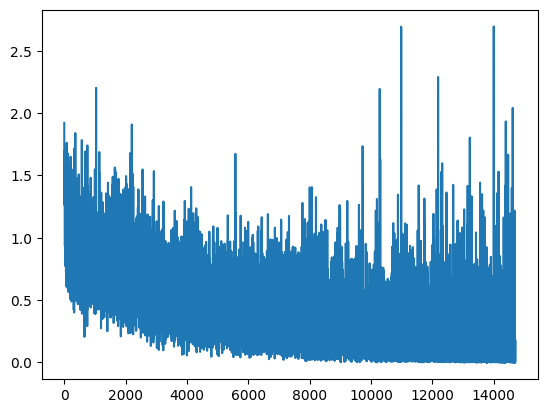

In [73]:
plt.plot(train_losses)

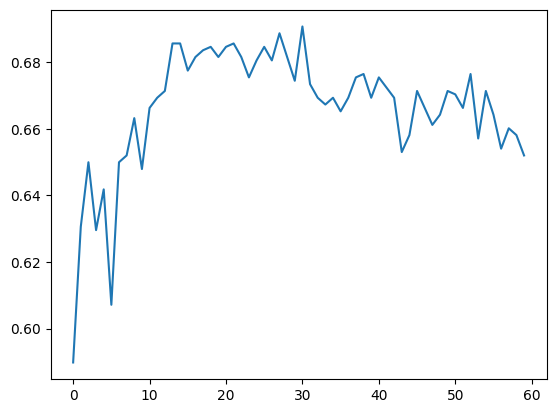

In [74]:
plt.plot(test_accuracy)

In [75]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=x_train[0].shape[0], n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4_mfcc/cremad_label4_m18mfcc_best_31epoch.pt
Correct: 677/976 (0.6936)
{'acc_detail': tensor([0.7787, 0.6590, 0.7205, 0.6111], device='cuda:0'),
 'acc_unweighted': tensor(0.6923, device='cuda:0'),
 'acc_weighted': tensor(0.6936, device='cuda:0'),
 'f1s': tensor(0.6913, device='cuda:0'),
 'f1s_detail': tensor([0.7665, 0.6398, 0.7291, 0.6299], device='cuda:0'),
 'precision_detail': tensor([0.7548, 0.6217, 0.7379, 0.6498], device='cuda:0'),
 'recall_detail': tensor([0.7787, 0.6590, 0.7205, 0.6111], device='cuda:0'),
 'rocauc': tensor([0.8934, 0.8786, 0.9147, 0.8209], device='cuda:0'),
 'uar': tensor(0.6923, device='cuda:0'),
 'wap': tensor(0.6937, device='cuda:0')}


tensor([[197,   9,   2,  45],
        [  8, 143,  47,  19],
        [  8,  44, 183,  19],
        [ 48,  34,  16, 154]], device='cuda:0')

In [76]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                               | 0.0032679738562091504/40 [00:00<50:14, 75.37s/it]

Train Epoch: 61 [0/3920 (0%)]	Loss: 0.367598
Mem before-during-after: 40799744 44007424 47373824


  0%|▏                                                                 | 0.1339869281045752/40 [00:09<49:32, 74.56s/it]

Train Epoch: 61 [640/3920 (16%)]	Loss: 0.008036
Mem before-during-after: 47373824 49657344 47373824


  1%|▍                                                                | 0.26470588235294074/40 [00:19<49:01, 74.02s/it]

Train Epoch: 61 [1280/3920 (33%)]	Loss: 0.004075
Mem before-during-after: 47373824 49856000 47373824


  1%|▋                                                                 | 0.3954248366013063/40 [00:29<49:05, 74.38s/it]

Train Epoch: 61 [1920/3920 (49%)]	Loss: 0.016324
Mem before-during-after: 47373824 50781184 47373824


  1%|▊                                                                 | 0.5261437908496719/40 [00:39<49:06, 74.64s/it]

Train Epoch: 61 [2560/3920 (65%)]	Loss: 0.054595
Mem before-during-after: 47373824 49856000 47373824


  2%|█                                                                 | 0.6568627450980374/40 [00:48<48:39, 74.22s/it]

Train Epoch: 61 [3200/3920 (82%)]	Loss: 0.009171
Mem before-during-after: 47373824 50428928 47373824


  2%|█▎                                                                 | 0.787581699346403/40 [00:58<48:29, 74.19s/it]

Train Epoch: 61 [3840/3920 (98%)]	Loss: 0.590847
Mem before-during-after: 47373824 49698304 47373824


  2%|█▋                                                                 | 0.999999999999997/40 [01:14<47:48, 73.54s/it]


Test Epoch: 61	Accuracy: 649/976 (66%)



  3%|█▋                                                                | 1.0032679738562063/40 [01:14<48:04, 73.97s/it]

Train Epoch: 62 [0/3920 (0%)]	Loss: 0.013828
Mem before-during-after: 47372800 49815040 47373824


  3%|█▊                                                                | 1.1339869281045718/40 [01:24<48:12, 74.42s/it]

Train Epoch: 62 [640/3920 (16%)]	Loss: 0.000150
Mem before-during-after: 47373824 50781184 47373824


  3%|██                                                                | 1.2647058823529373/40 [01:33<47:59, 74.33s/it]

Train Epoch: 62 [1280/3920 (33%)]	Loss: 0.128747
Mem before-during-after: 47373824 50580480 47373824


  3%|██▎                                                                | 1.395424836601303/40 [01:43<47:51, 74.38s/it]

Train Epoch: 62 [1920/3920 (49%)]	Loss: 0.225276
Mem before-during-after: 47373824 50624000 47373824


  4%|██▌                                                               | 1.5261437908496684/40 [01:53<47:42, 74.39s/it]

Train Epoch: 62 [2560/3920 (65%)]	Loss: 0.262092
Mem before-during-after: 47373824 50889728 47373824


  4%|██▊                                                                | 1.656862745098034/40 [02:03<47:34, 74.46s/it]

Train Epoch: 62 [3200/3920 (82%)]	Loss: 0.014040
Mem before-during-after: 47373824 50410496 47373824


  4%|██▉                                                               | 1.7875816993463995/40 [02:12<47:19, 74.30s/it]

Train Epoch: 62 [3840/3920 (98%)]	Loss: 0.021395
Mem before-during-after: 47373824 50689024 47373824


  5%|███▎                                                              | 1.9999999999999936/40 [02:28<46:21, 73.21s/it]


Test Epoch: 62	Accuracy: 645/976 (66%)



  5%|███▎                                                               | 2.003267973856203/40 [02:28<46:39, 73.68s/it]

Train Epoch: 63 [0/3920 (0%)]	Loss: 0.022744
Mem before-during-after: 47372800 49931776 47373824


  5%|███▌                                                              | 2.1339869281045685/40 [02:38<47:33, 75.35s/it]

Train Epoch: 63 [640/3920 (16%)]	Loss: 0.045310
Mem before-during-after: 47373824 50428928 47373824


  6%|███▊                                                               | 2.264705882352934/40 [02:48<46:51, 74.52s/it]

Train Epoch: 63 [1280/3920 (33%)]	Loss: 0.509364
Mem before-during-after: 47373824 51473408 47373824


  6%|███▉                                                              | 2.3954248366012996/40 [02:57<46:59, 74.97s/it]

Train Epoch: 63 [1920/3920 (49%)]	Loss: 0.396751
Mem before-during-after: 47373824 50519040 47373824


  6%|████▏                                                              | 2.526143790849665/40 [03:07<46:23, 74.27s/it]

Train Epoch: 63 [2560/3920 (65%)]	Loss: 0.020228
Mem before-during-after: 47373824 50889728 47373824


  7%|████▍                                                             | 2.6568627450980307/40 [03:17<46:18, 74.40s/it]

Train Epoch: 63 [3200/3920 (82%)]	Loss: 0.347098
Mem before-during-after: 47373824 50920448 47373824


  7%|████▋                                                              | 2.787581699346396/40 [03:27<46:20, 74.72s/it]

Train Epoch: 63 [3840/3920 (98%)]	Loss: 0.186765
Mem before-during-after: 47373824 50750464 47373824


  7%|████▉                                                             | 2.9999999999999902/40 [03:42<45:35, 73.92s/it]


Test Epoch: 63	Accuracy: 643/976 (66%)



  8%|████▉                                                             | 3.0032679738561994/40 [03:43<45:49, 74.32s/it]

Train Epoch: 64 [0/3920 (0%)]	Loss: 0.273961
Mem before-during-after: 47372800 50750464 47373824


  8%|█████▏                                                             | 3.133986928104565/40 [03:52<45:32, 74.11s/it]

Train Epoch: 64 [640/3920 (16%)]	Loss: 0.122097
Mem before-during-after: 47373824 49815040 47373824


  8%|█████▍                                                            | 3.2647058823529305/40 [04:02<45:26, 74.22s/it]

Train Epoch: 64 [1280/3920 (33%)]	Loss: 0.161253
Mem before-during-after: 47373824 50603520 47373824


  8%|█████▋                                                             | 3.395424836601296/40 [04:12<45:09, 74.02s/it]

Train Epoch: 64 [1920/3920 (49%)]	Loss: 0.334727
Mem before-during-after: 47373824 50249216 47373824


  9%|█████▊                                                            | 3.5261437908496616/40 [04:21<45:06, 74.21s/it]

Train Epoch: 64 [2560/3920 (65%)]	Loss: 1.060337
Mem before-during-after: 47373824 50466304 47373824


  9%|██████▏                                                            | 3.656862745098027/40 [04:31<44:49, 74.01s/it]

Train Epoch: 64 [3200/3920 (82%)]	Loss: 0.106628
Mem before-during-after: 47373824 50410496 47373824


  9%|██████▏                                                           | 3.7875816993463927/40 [04:41<44:43, 74.12s/it]

Train Epoch: 64 [3840/3920 (98%)]	Loss: 0.041896
Mem before-during-after: 47373824 50611200 47373824


 10%|██████▌                                                           | 3.9999999999999867/40 [04:56<43:51, 73.09s/it]


Test Epoch: 64	Accuracy: 650/976 (66%)



 10%|██████▋                                                            | 4.003267973856196/40 [04:56<44:07, 73.56s/it]

Train Epoch: 65 [0/3920 (0%)]	Loss: 0.152539
Mem before-during-after: 47372800 50750464 47373824


 10%|██████▉                                                            | 4.133986928104561/40 [05:06<44:13, 74.00s/it]

Train Epoch: 65 [640/3920 (16%)]	Loss: 0.033812
Mem before-during-after: 47373824 49931776 47373824


 11%|███████▏                                                           | 4.264705882352927/40 [05:16<44:19, 74.43s/it]

Train Epoch: 65 [1280/3920 (33%)]	Loss: 0.266083
Mem before-during-after: 47373824 50425344 47373824


 11%|███████▎                                                          | 4.3954248366012925/40 [05:26<44:14, 74.55s/it]

Train Epoch: 65 [1920/3920 (49%)]	Loss: 0.013750
Mem before-during-after: 47373824 49815040 47373824


 11%|███████▌                                                           | 4.526143790849658/40 [05:35<46:09, 78.06s/it]

Train Epoch: 65 [2560/3920 (65%)]	Loss: 0.054320
Mem before-during-after: 47373824 50488320 47373824


 12%|███████▊                                                           | 4.656862745098024/40 [05:45<43:41, 74.17s/it]

Train Epoch: 65 [3200/3920 (82%)]	Loss: 0.007970
Mem before-during-after: 47373824 49972736 47373824


 12%|████████                                                           | 4.787581699346389/40 [05:55<43:38, 74.36s/it]

Train Epoch: 65 [3840/3920 (98%)]	Loss: 0.130082
Mem before-during-after: 47373824 50920448 47373824


 12%|████████▎                                                          | 4.999999999999983/40 [06:10<42:39, 73.12s/it]


Test Epoch: 65	Accuracy: 625/976 (64%)



 13%|████████▍                                                          | 5.003267973856192/40 [06:11<42:54, 73.58s/it]

Train Epoch: 66 [0/3920 (0%)]	Loss: 0.168240
Mem before-during-after: 47372800 50624000 47373824


 13%|████████▌                                                          | 5.133986928104558/40 [06:20<43:16, 74.48s/it]

Train Epoch: 66 [640/3920 (16%)]	Loss: 0.027211
Mem before-during-after: 47373824 50761216 47373824


 13%|████████▊                                                          | 5.264705882352923/40 [06:30<43:16, 74.74s/it]

Train Epoch: 66 [1280/3920 (33%)]	Loss: 0.376886
Mem before-during-after: 47373824 50562560 47373824


 13%|█████████                                                          | 5.395424836601289/40 [06:40<42:48, 74.24s/it]

Train Epoch: 66 [1920/3920 (49%)]	Loss: 0.046926
Mem before-during-after: 47373824 49952256 47373824


 14%|█████████                                                         | 5.5261437908496545/40 [06:50<42:35, 74.12s/it]

Train Epoch: 66 [2560/3920 (65%)]	Loss: 0.026074
Mem before-during-after: 47373824 50428928 47373824


 14%|█████████▌                                                          | 5.65686274509802/40 [06:59<42:31, 74.31s/it]

Train Epoch: 66 [3200/3920 (82%)]	Loss: 0.026893
Mem before-during-after: 47373824 50842624 47373824


 14%|█████████▌                                                        | 5.7875816993463856/40 [07:09<42:10, 73.97s/it]

Train Epoch: 66 [3840/3920 (98%)]	Loss: 0.075443
Mem before-during-after: 47373824 49532416 47373824


 15%|██████████▏                                                         | 5.99999999999998/40 [07:25<41:26, 73.14s/it]


Test Epoch: 66	Accuracy: 636/976 (65%)



 15%|██████████                                                         | 6.003267973856189/40 [07:25<41:47, 73.75s/it]

Train Epoch: 67 [0/3920 (0%)]	Loss: 0.002950
Mem before-during-after: 47372800 50249216 47373824


 15%|██████████▎                                                        | 6.133986928104554/40 [07:35<41:56, 74.32s/it]

Train Epoch: 67 [640/3920 (16%)]	Loss: 0.312862
Mem before-during-after: 47373824 50920448 47373824


 16%|██████████▋                                                         | 6.26470588235292/40 [07:44<41:45, 74.28s/it]

Train Epoch: 67 [1280/3920 (33%)]	Loss: 0.673703
Mem before-during-after: 47373824 50562560 47373824


 16%|██████████▋                                                        | 6.395424836601285/40 [07:54<41:41, 74.45s/it]

Train Epoch: 67 [1920/3920 (49%)]	Loss: 0.096257
Mem before-during-after: 47373824 50562560 47373824


 16%|██████████▉                                                        | 6.526143790849651/40 [08:04<41:37, 74.61s/it]

Train Epoch: 67 [2560/3920 (65%)]	Loss: 0.079747
Mem before-during-after: 47373824 49972736 47373824


 17%|██████████▉                                                       | 6.6568627450980165/40 [08:13<41:10, 74.09s/it]

Train Epoch: 67 [3200/3920 (82%)]	Loss: 0.056436
Mem before-during-after: 47373824 50842624 47373824


 17%|███████████▎                                                       | 6.787581699346382/40 [08:23<41:14, 74.49s/it]

Train Epoch: 67 [3840/3920 (98%)]	Loss: 0.566824
Mem before-during-after: 47373824 50329088 47373824


 17%|███████████▋                                                       | 6.999999999999976/40 [08:39<40:29, 73.62s/it]


Test Epoch: 67	Accuracy: 649/976 (66%)



 18%|███████████▋                                                       | 7.003267973856185/40 [08:39<40:50, 74.27s/it]

Train Epoch: 68 [0/3920 (0%)]	Loss: 0.007502
Mem before-during-after: 47372800 50425344 47373824


 18%|███████████▉                                                       | 7.133986928104551/40 [08:49<41:01, 74.90s/it]

Train Epoch: 68 [640/3920 (16%)]	Loss: 0.088597
Mem before-during-after: 47373824 50641920 47373824


 18%|████████████▏                                                      | 7.264705882352916/40 [08:58<40:36, 74.43s/it]

Train Epoch: 68 [1280/3920 (33%)]	Loss: 0.002753
Mem before-during-after: 47373824 50842624 47373824


 18%|████████████▍                                                      | 7.395424836601282/40 [09:08<40:28, 74.47s/it]

Train Epoch: 68 [1920/3920 (49%)]	Loss: 0.026643
Mem before-during-after: 47373824 50750464 47373824


 19%|████████████▌                                                      | 7.526143790849647/40 [09:18<40:17, 74.45s/it]

Train Epoch: 68 [2560/3920 (65%)]	Loss: 0.396408
Mem before-during-after: 47373824 49972736 47373824


 19%|████████████▊                                                      | 7.656862745098013/40 [09:28<40:11, 74.55s/it]

Train Epoch: 68 [3200/3920 (82%)]	Loss: 0.856189
Mem before-during-after: 47373824 49698304 47373824


 19%|████████████▊                                                     | 7.7875816993463784/40 [09:37<39:49, 74.19s/it]

Train Epoch: 68 [3840/3920 (98%)]	Loss: 0.282321
Mem before-during-after: 47373824 49835520 47373824


 20%|█████████████▏                                                    | 7.9999999999999725/40 [09:53<39:09, 73.44s/it]


Test Epoch: 68	Accuracy: 656/976 (67%)



 20%|█████████████▍                                                     | 8.003267973856182/40 [09:53<39:21, 73.80s/it]

Train Epoch: 69 [0/3920 (0%)]	Loss: 0.723308
Mem before-during-after: 47372800 49532416 47373824


 20%|█████████████▌                                                     | 8.133986928104548/40 [10:03<39:25, 74.22s/it]

Train Epoch: 69 [640/3920 (16%)]	Loss: 0.080788
Mem before-during-after: 47373824 49911296 47373824


 21%|█████████████▊                                                     | 8.264705882352914/40 [10:13<39:14, 74.18s/it]

Train Epoch: 69 [1280/3920 (33%)]	Loss: 0.000794
Mem before-during-after: 47373824 50811904 47373824


 21%|██████████████▎                                                     | 8.39542483660128/40 [10:22<39:02, 74.11s/it]

Train Epoch: 69 [1920/3920 (49%)]	Loss: 0.000528
Mem before-during-after: 47373824 49774080 47373824


 21%|██████████████▎                                                    | 8.526143790849645/40 [10:32<38:55, 74.22s/it]

Train Epoch: 69 [2560/3920 (65%)]	Loss: 0.142694
Mem before-during-after: 47373824 50781184 47373824


 22%|██████████████▋                                                     | 8.65686274509801/40 [10:42<38:52, 74.41s/it]

Train Epoch: 69 [3200/3920 (82%)]	Loss: 0.075188
Mem before-during-after: 47373824 50920448 47373824


 22%|██████████████▋                                                    | 8.787581699346376/40 [10:52<38:41, 74.39s/it]

Train Epoch: 69 [3840/3920 (98%)]	Loss: 0.116010
Mem before-during-after: 47373824 49794560 47373824


 22%|███████████████▎                                                    | 8.99999999999997/40 [11:07<37:50, 73.25s/it]


Test Epoch: 69	Accuracy: 641/976 (65%)



 23%|███████████████                                                    | 9.003267973856179/40 [11:07<38:04, 73.71s/it]

Train Epoch: 70 [0/3920 (0%)]	Loss: 0.073888
Mem before-during-after: 47372800 50920448 47373824


 23%|███████████████▎                                                   | 9.133986928104544/40 [11:17<38:09, 74.16s/it]

Train Epoch: 70 [640/3920 (16%)]	Loss: 0.234720
Mem before-during-after: 47373824 50811904 47373824


 23%|███████████████▋                                                    | 9.26470588235291/40 [11:27<38:01, 74.23s/it]

Train Epoch: 70 [1280/3920 (33%)]	Loss: 0.121658
Mem before-during-after: 47373824 50889728 47373824


 23%|███████████████▋                                                   | 9.395424836601276/40 [11:37<37:48, 74.14s/it]

Train Epoch: 70 [1920/3920 (49%)]	Loss: 0.581221
Mem before-during-after: 47373824 49856000 47373824


 24%|███████████████▉                                                   | 9.526143790849641/40 [11:46<37:52, 74.59s/it]

Train Epoch: 70 [2560/3920 (65%)]	Loss: 0.607181
Mem before-during-after: 47373824 49835520 47373824


 24%|████████████████▏                                                  | 9.656862745098007/40 [11:56<37:38, 74.42s/it]

Train Epoch: 70 [3200/3920 (82%)]	Loss: 0.307309
Mem before-during-after: 47373824 50811904 47373824


 24%|████████████████▍                                                  | 9.787581699346372/40 [12:06<37:34, 74.63s/it]

Train Epoch: 70 [3840/3920 (98%)]	Loss: 0.029754
Mem before-during-after: 47373824 50213888 47373824


 25%|████████████████▋                                                  | 9.999999999999966/40 [12:21<36:37, 73.27s/it]


Test Epoch: 70	Accuracy: 616/976 (63%)



 25%|████████████████▌                                                 | 10.003267973856175/40 [12:22<36:50, 73.70s/it]

Train Epoch: 71 [0/3920 (0%)]	Loss: 0.286745
Mem before-during-after: 47372800 50425344 47373824


 25%|████████████████▋                                                 | 10.133986928104541/40 [12:31<36:59, 74.33s/it]

Train Epoch: 71 [640/3920 (16%)]	Loss: 0.070906
Mem before-during-after: 47373824 49856000 47373824


 26%|████████████████▉                                                 | 10.264705882352906/40 [12:41<36:48, 74.26s/it]

Train Epoch: 71 [1280/3920 (33%)]	Loss: 0.017885
Mem before-during-after: 47373824 50811904 47373824


 26%|█████████████████▏                                                | 10.395424836601272/40 [12:51<36:41, 74.36s/it]

Train Epoch: 71 [1920/3920 (49%)]	Loss: 0.005735
Mem before-during-after: 47373824 49835520 47373824


 26%|█████████████████▎                                                | 10.526143790849638/40 [13:01<36:28, 74.26s/it]

Train Epoch: 71 [2560/3920 (65%)]	Loss: 0.025907
Mem before-during-after: 47373824 50488320 47373824


 27%|█████████████████▌                                                | 10.656862745098003/40 [13:10<36:18, 74.23s/it]

Train Epoch: 71 [3200/3920 (82%)]	Loss: 0.000740
Mem before-during-after: 47373824 50425344 47373824


 27%|█████████████████▊                                                | 10.787581699346369/40 [13:20<35:54, 73.76s/it]

Train Epoch: 71 [3840/3920 (98%)]	Loss: 0.011409
Mem before-during-after: 47373824 50781184 47373824


 27%|██████████████████▏                                               | 10.999999999999963/40 [13:35<35:16, 72.98s/it]


Test Epoch: 71	Accuracy: 647/976 (66%)



 28%|██████████████████▏                                               | 11.003267973856172/40 [13:36<35:26, 73.32s/it]

Train Epoch: 72 [0/3920 (0%)]	Loss: 0.018856
Mem before-during-after: 47372800 50719744 47373824


 28%|██████████████████▎                                               | 11.133986928104537/40 [13:45<35:37, 74.04s/it]

Train Epoch: 72 [640/3920 (16%)]	Loss: 0.090857
Mem before-during-after: 47373824 50410496 47373824


 28%|██████████████████▌                                               | 11.264705882352903/40 [13:55<35:22, 73.87s/it]

Train Epoch: 72 [1280/3920 (33%)]	Loss: 0.001191
Mem before-during-after: 47373824 50889728 47373824


 28%|██████████████████▊                                               | 11.395424836601268/40 [14:05<35:23, 74.24s/it]

Train Epoch: 72 [1920/3920 (49%)]	Loss: 0.418772
Mem before-during-after: 47373824 50689024 47373824


 29%|███████████████████                                               | 11.526143790849634/40 [14:15<35:04, 73.91s/it]

Train Epoch: 72 [2560/3920 (65%)]	Loss: 0.003403
Mem before-during-after: 47373824 50781184 47373824


 29%|████████████████████                                                 | 11.656862745098/40 [14:24<35:14, 74.62s/it]

Train Epoch: 72 [3200/3920 (82%)]	Loss: 0.039058
Mem before-during-after: 47373824 50580480 47373824


 29%|███████████████████▍                                              | 11.787581699346365/40 [14:34<34:51, 74.14s/it]

Train Epoch: 72 [3840/3920 (98%)]	Loss: 0.032159
Mem before-during-after: 47373824 50488320 47373824


 30%|████████████████████                                               | 11.99999999999996/40 [14:49<34:14, 73.38s/it]


Test Epoch: 72	Accuracy: 633/976 (65%)



 30%|███████████████████▊                                              | 12.003267973856168/40 [14:50<34:24, 73.73s/it]

Train Epoch: 73 [0/3920 (0%)]	Loss: 0.042572
Mem before-during-after: 47372800 50689024 47373824


 30%|████████████████████                                              | 12.133986928104534/40 [14:59<34:26, 74.17s/it]

Train Epoch: 73 [640/3920 (16%)]	Loss: 0.014100
Mem before-during-after: 47373824 49972736 47373824


 31%|████████████████████▊                                               | 12.2647058823529/40 [15:09<34:18, 74.23s/it]

Train Epoch: 73 [1280/3920 (33%)]	Loss: 0.099096
Mem before-during-after: 47373824 50750464 47373824


 31%|████████████████████▍                                             | 12.395424836601265/40 [15:19<33:52, 73.62s/it]

Train Epoch: 73 [1920/3920 (49%)]	Loss: 0.142332
Mem before-during-after: 47373824 49815040 47373824


 31%|████████████████████▉                                              | 12.52614379084963/40 [15:28<33:49, 73.86s/it]

Train Epoch: 73 [2560/3920 (65%)]	Loss: 0.794409
Mem before-during-after: 47373824 50549760 47373824


 32%|████████████████████▉                                             | 12.656862745097996/40 [15:38<33:47, 74.16s/it]

Train Epoch: 73 [3200/3920 (82%)]	Loss: 0.385914
Mem before-during-after: 47373824 50562560 47373824


 32%|█████████████████████                                             | 12.787581699346362/40 [15:48<33:28, 73.80s/it]

Train Epoch: 73 [3840/3920 (98%)]	Loss: 0.038676
Mem before-during-after: 47373824 49815040 47373824


 32%|█████████████████████▍                                            | 12.999999999999956/40 [16:03<32:53, 73.08s/it]


Test Epoch: 73	Accuracy: 639/976 (65%)



 33%|█████████████████████▍                                            | 13.003267973856165/40 [16:04<33:05, 73.56s/it]

Train Epoch: 74 [0/3920 (0%)]	Loss: 0.165712
Mem before-during-after: 47372800 50750464 47373824


 33%|█████████████████████▉                                             | 13.13398692810453/40 [16:13<33:14, 74.24s/it]

Train Epoch: 74 [640/3920 (16%)]	Loss: 0.011828
Mem before-during-after: 47373824 49972736 47373824


 33%|█████████████████████▉                                            | 13.264705882352896/40 [16:23<32:56, 73.94s/it]

Train Epoch: 74 [1280/3920 (33%)]	Loss: 0.000328
Mem before-during-after: 47373824 50920448 47373824


 33%|██████████████████████                                            | 13.395424836601261/40 [16:33<32:53, 74.16s/it]

Train Epoch: 74 [1920/3920 (49%)]	Loss: 0.395429
Mem before-during-after: 47373824 49794560 47373824


 34%|██████████████████████▎                                           | 13.526143790849627/40 [16:42<32:38, 73.98s/it]

Train Epoch: 74 [2560/3920 (65%)]	Loss: 0.004632
Mem before-during-after: 47373824 49532416 47373824


 34%|██████████████████████▌                                           | 13.656862745097992/40 [16:52<32:23, 73.77s/it]

Train Epoch: 74 [3200/3920 (82%)]	Loss: 0.096074
Mem before-during-after: 47373824 50519040 47373824


 34%|██████████████████████▋                                           | 13.787581699346358/40 [17:02<32:11, 73.70s/it]

Train Epoch: 74 [3840/3920 (98%)]	Loss: 0.093238
Mem before-during-after: 47373824 49911296 47373824


 35%|███████████████████████                                           | 13.999999999999952/40 [17:17<31:39, 73.06s/it]


Test Epoch: 74	Accuracy: 654/976 (67%)



 35%|███████████████████████                                           | 14.003267973856161/40 [17:17<31:54, 73.64s/it]

Train Epoch: 75 [0/3920 (0%)]	Loss: 0.272854
Mem before-during-after: 47372800 50562560 47373824


 35%|███████████████████████▎                                          | 14.133986928104527/40 [17:27<31:57, 74.15s/it]

Train Epoch: 75 [640/3920 (16%)]	Loss: 0.025051
Mem before-during-after: 47373824 50842624 47373824


 36%|███████████████████████▌                                          | 14.264705882352892/40 [17:37<32:08, 74.94s/it]

Train Epoch: 75 [1280/3920 (33%)]	Loss: 0.374782
Mem before-during-after: 47373824 49815040 47373824


 36%|███████████████████████▊                                          | 14.395424836601258/40 [17:47<31:35, 74.05s/it]

Train Epoch: 75 [1920/3920 (49%)]	Loss: 0.004408
Mem before-during-after: 47373824 50842624 47373824


 36%|███████████████████████▉                                          | 14.526143790849623/40 [17:56<31:22, 73.90s/it]

Train Epoch: 75 [2560/3920 (65%)]	Loss: 0.102348
Mem before-during-after: 47373824 49815040 47373824


 37%|████████████████████████▏                                         | 14.656862745097989/40 [18:06<31:07, 73.69s/it]

Train Epoch: 75 [3200/3920 (82%)]	Loss: 0.076254
Mem before-during-after: 47373824 50750464 47373824


 37%|████████████████████████▍                                         | 14.787581699346354/40 [18:16<31:06, 74.04s/it]

Train Epoch: 75 [3840/3920 (98%)]	Loss: 0.064186
Mem before-during-after: 47373824 50920448 47373824


 37%|████████████████████████▋                                         | 14.999999999999948/40 [18:31<30:28, 73.13s/it]


Test Epoch: 75	Accuracy: 649/976 (66%)



 38%|████████████████████████▊                                         | 15.003267973856158/40 [18:31<30:37, 73.50s/it]

Train Epoch: 76 [0/3920 (0%)]	Loss: 0.009922
Mem before-during-after: 47372800 49636864 47373824


 38%|████████████████████████▉                                         | 15.133986928104523/40 [18:41<30:39, 73.98s/it]

Train Epoch: 76 [640/3920 (16%)]	Loss: 0.081466
Mem before-during-after: 47373824 50689024 47373824


 38%|█████████████████████████▏                                        | 15.264705882352889/40 [18:51<30:29, 73.97s/it]

Train Epoch: 76 [1280/3920 (33%)]	Loss: 0.046300
Mem before-during-after: 47373824 50466304 47373824


 38%|█████████████████████████▍                                        | 15.395424836601254/40 [19:00<30:21, 74.02s/it]

Train Epoch: 76 [1920/3920 (49%)]	Loss: 0.007802
Mem before-during-after: 47373824 50488320 47373824


 39%|██████████████████████████                                         | 15.52614379084962/40 [19:10<30:10, 73.98s/it]

Train Epoch: 76 [2560/3920 (65%)]	Loss: 0.038688
Mem before-during-after: 47373824 49972736 47373824


 39%|█████████████████████████▊                                        | 15.656862745097985/40 [19:20<29:54, 73.72s/it]

Train Epoch: 76 [3200/3920 (82%)]	Loss: 0.168787
Mem before-during-after: 47373824 49931776 47373824


 39%|██████████████████████████                                        | 15.787581699346351/40 [19:29<29:48, 73.88s/it]

Train Epoch: 76 [3840/3920 (98%)]	Loss: 0.202303
Mem before-during-after: 47373824 49677824 47373824


 40%|██████████████████████████▍                                       | 15.999999999999945/40 [19:45<29:11, 72.97s/it]


Test Epoch: 76	Accuracy: 652/976 (67%)



 40%|██████████████████████████▍                                       | 16.003267973856154/40 [19:45<29:20, 73.38s/it]

Train Epoch: 77 [0/3920 (0%)]	Loss: 0.024636
Mem before-during-after: 47372800 49794560 47373824


 40%|███████████████████████████                                        | 16.13398692810459/40 [19:55<29:24, 73.92s/it]

Train Epoch: 77 [640/3920 (16%)]	Loss: 0.009559
Mem before-during-after: 47373824 50719744 47373824


 41%|██████████████████████████▊                                       | 16.264705882353027/40 [20:05<29:17, 74.06s/it]

Train Epoch: 77 [1280/3920 (33%)]	Loss: 0.281356
Mem before-during-after: 47373824 50842624 47373824


 41%|███████████████████████████                                       | 16.395424836601464/40 [20:14<29:24, 74.76s/it]

Train Epoch: 77 [1920/3920 (49%)]	Loss: 0.408085
Mem before-during-after: 47373824 49753600 47373824


 41%|████████████████████████████                                        | 16.5261437908499/40 [20:24<29:01, 74.19s/it]

Train Epoch: 77 [2560/3920 (65%)]	Loss: 0.001406
Mem before-during-after: 47373824 49774080 47373824


 42%|███████████████████████████▍                                      | 16.656862745098337/40 [20:34<28:54, 74.32s/it]

Train Epoch: 77 [3200/3920 (82%)]	Loss: 0.352934
Mem before-during-after: 47373824 49911296 47373824


 42%|███████████████████████████▋                                      | 16.787581699346774/40 [20:43<28:47, 74.42s/it]

Train Epoch: 77 [3840/3920 (98%)]	Loss: 0.872915
Mem before-during-after: 47373824 49815040 47373824


 43%|████████████████████████████                                      | 17.000000000000483/40 [20:59<28:02, 73.17s/it]


Test Epoch: 77	Accuracy: 639/976 (65%)



 43%|████████████████████████████                                      | 17.003267973856694/40 [20:59<28:13, 73.63s/it]

Train Epoch: 78 [0/3920 (0%)]	Loss: 0.571481
Mem before-during-after: 47372800 49595904 47373824


 43%|████████████████████████████▋                                      | 17.13398692810513/40 [21:09<28:09, 73.91s/it]

Train Epoch: 78 [640/3920 (16%)]	Loss: 0.267563
Mem before-during-after: 47373824 49677824 47373824


 43%|████████████████████████████▍                                     | 17.264705882353567/40 [21:19<28:09, 74.32s/it]

Train Epoch: 78 [1280/3920 (33%)]	Loss: 0.336564
Mem before-during-after: 47373824 49856000 47373824


 43%|████████████████████████████▋                                     | 17.395424836602004/40 [21:28<28:07, 74.66s/it]

Train Epoch: 78 [1920/3920 (49%)]	Loss: 0.054972
Mem before-during-after: 47373824 50486784 47373824


 44%|█████████████████████████████▎                                     | 17.52614379085044/40 [21:38<27:50, 74.32s/it]

Train Epoch: 78 [2560/3920 (65%)]	Loss: 0.071587
Mem before-during-after: 47373824 49794560 47373824


 44%|█████████████████████████████▏                                    | 17.656862745098877/40 [21:48<27:54, 74.93s/it]

Train Epoch: 78 [3200/3920 (82%)]	Loss: 0.020110
Mem before-during-after: 47373824 49794560 47373824


 44%|█████████████████████████████▎                                    | 17.787581699347314/40 [21:57<27:28, 74.22s/it]

Train Epoch: 78 [3840/3920 (98%)]	Loss: 0.108339
Mem before-during-after: 47373824 50488320 47373824


 45%|█████████████████████████████▋                                    | 18.000000000001023/40 [22:13<26:55, 73.43s/it]


Test Epoch: 78	Accuracy: 653/976 (67%)



 45%|█████████████████████████████▋                                    | 18.003267973857234/40 [22:13<27:01, 73.70s/it]

Train Epoch: 79 [0/3920 (0%)]	Loss: 0.946977
Mem before-during-after: 47372800 50624000 47373824


 45%|██████████████████████████████▎                                    | 18.13398692810567/40 [22:23<27:10, 74.57s/it]

Train Epoch: 79 [640/3920 (16%)]	Loss: 0.005663
Mem before-during-after: 47373824 50811904 47373824


 46%|██████████████████████████████▏                                   | 18.264705882354107/40 [22:33<26:54, 74.26s/it]

Train Epoch: 79 [1280/3920 (33%)]	Loss: 0.132330
Mem before-during-after: 47373824 50425344 47373824


 46%|██████████████████████████████▎                                   | 18.395424836602544/40 [22:42<26:40, 74.07s/it]

Train Epoch: 79 [1920/3920 (49%)]	Loss: 0.002296
Mem before-during-after: 47373824 49794560 47373824


 46%|███████████████████████████████                                    | 18.52614379085098/40 [22:52<26:27, 73.92s/it]

Train Epoch: 79 [2560/3920 (65%)]	Loss: 0.343649
Mem before-during-after: 47373824 50603520 47373824


 47%|██████████████████████████████▊                                   | 18.656862745099417/40 [23:02<26:26, 74.32s/it]

Train Epoch: 79 [3200/3920 (82%)]	Loss: 0.859881
Mem before-during-after: 47373824 49520128 47373824


 47%|██████████████████████████████▉                                   | 18.787581699347854/40 [23:12<26:19, 74.46s/it]

Train Epoch: 79 [3840/3920 (98%)]	Loss: 0.170106
Mem before-during-after: 47373824 49794560 47373824


 48%|███████████████████████████████▎                                  | 19.000000000001563/40 [23:27<25:34, 73.09s/it]


Test Epoch: 79	Accuracy: 638/976 (65%)



 48%|███████████████████████████████▎                                  | 19.003267973857774/40 [23:27<25:46, 73.64s/it]

Train Epoch: 80 [0/3920 (0%)]	Loss: 0.272662
Mem before-during-after: 47372800 50410496 47373824


 48%|████████████████████████████████                                   | 19.13398692810621/40 [23:37<25:46, 74.11s/it]

Train Epoch: 80 [640/3920 (16%)]	Loss: 0.733299
Mem before-during-after: 47373824 50611200 47373824


 48%|███████████████████████████████▊                                  | 19.264705882354647/40 [23:47<25:36, 74.08s/it]

Train Epoch: 80 [1280/3920 (33%)]	Loss: 0.003952
Mem before-during-after: 47373824 50750464 47373824


 48%|████████████████████████████████                                  | 19.395424836603084/40 [23:57<25:34, 74.49s/it]

Train Epoch: 80 [1920/3920 (49%)]	Loss: 0.012405
Mem before-during-after: 47373824 50519040 47373824


 49%|████████████████████████████████▋                                  | 19.52614379085152/40 [24:06<25:23, 74.43s/it]

Train Epoch: 80 [2560/3920 (65%)]	Loss: 0.986767
Mem before-during-after: 47373824 51015168 47373824


 49%|████████████████████████████████▍                                 | 19.656862745099957/40 [24:16<25:13, 74.40s/it]

Train Epoch: 80 [3200/3920 (82%)]	Loss: 0.143567
Mem before-during-after: 47373824 49911296 47373824


 49%|████████████████████████████████▋                                 | 19.787581699348394/40 [24:26<25:06, 74.53s/it]

Train Epoch: 80 [3840/3920 (98%)]	Loss: 0.060877
Mem before-during-after: 47373824 50488320 47373824


 50%|█████████████████████████████████                                 | 20.000000000002103/40 [24:41<24:29, 73.48s/it]


Test Epoch: 80	Accuracy: 650/976 (66%)



 50%|█████████████████████████████████                                 | 20.003267973858314/40 [24:42<24:37, 73.88s/it]

Train Epoch: 81 [0/3920 (0%)]	Loss: 0.008900
Mem before-during-after: 47372800 50920448 47373824


 50%|█████████████████████████████████▋                                 | 20.13398692810675/40 [24:51<24:38, 74.43s/it]

Train Epoch: 81 [640/3920 (16%)]	Loss: 0.370364
Mem before-during-after: 47373824 50580480 47373824


 51%|█████████████████████████████████▍                                | 20.264705882355187/40 [25:01<24:30, 74.53s/it]

Train Epoch: 81 [1280/3920 (33%)]	Loss: 0.001406
Mem before-during-after: 47373824 50750464 47373824


 51%|█████████████████████████████████▋                                | 20.395424836603624/40 [25:11<24:59, 76.50s/it]

Train Epoch: 81 [1920/3920 (49%)]	Loss: 0.059896
Mem before-during-after: 47373824 49911296 47373824


 51%|██████████████████████████████████▍                                | 20.52614379085206/40 [25:21<24:09, 74.41s/it]

Train Epoch: 81 [2560/3920 (65%)]	Loss: 0.627513
Mem before-during-after: 47373824 49856000 47373824


 52%|██████████████████████████████████                                | 20.656862745100497/40 [25:30<24:02, 74.55s/it]

Train Epoch: 81 [3200/3920 (82%)]	Loss: 0.000251
Mem before-during-after: 47373824 49794560 47373824


 52%|██████████████████████████████████▎                               | 20.787581699348934/40 [25:40<23:58, 74.89s/it]

Train Epoch: 81 [3840/3920 (98%)]	Loss: 0.094642
Mem before-during-after: 47373824 50441216 47373824


 53%|██████████████████████████████████▋                               | 21.000000000002643/40 [25:56<23:10, 73.17s/it]


Test Epoch: 81	Accuracy: 651/976 (66%)



 53%|██████████████████████████████████▋                               | 21.003267973858854/40 [25:56<23:18, 73.61s/it]

Train Epoch: 82 [0/3920 (0%)]	Loss: 0.050563
Mem before-during-after: 47372800 50920448 47373824


 53%|███████████████████████████████████▍                               | 21.13398692810729/40 [26:06<23:25, 74.48s/it]

Train Epoch: 82 [640/3920 (16%)]	Loss: 0.165099
Mem before-during-after: 47373824 50249216 47373824


 53%|███████████████████████████████████                               | 21.264705882355727/40 [26:16<23:19, 74.72s/it]

Train Epoch: 82 [1280/3920 (33%)]	Loss: 0.388777
Mem before-during-after: 47373824 49835520 47373824


 53%|███████████████████████████████████▎                              | 21.395424836604164/40 [26:25<23:03, 74.39s/it]

Train Epoch: 82 [1920/3920 (49%)]	Loss: 0.313312
Mem before-during-after: 47373824 50519040 47373824


 54%|████████████████████████████████████▌                               | 21.5261437908526/40 [26:35<22:54, 74.38s/it]

Train Epoch: 82 [2560/3920 (65%)]	Loss: 0.520967
Mem before-during-after: 47373824 50842624 47373824


 54%|███████████████████████████████████▋                              | 21.656862745101037/40 [26:45<22:58, 75.16s/it]

Train Epoch: 82 [3200/3920 (82%)]	Loss: 0.200153
Mem before-during-after: 47373824 50889728 47373824


 54%|███████████████████████████████████▉                              | 21.787581699349474/40 [26:55<22:35, 74.42s/it]

Train Epoch: 82 [3840/3920 (98%)]	Loss: 0.470369
Mem before-during-after: 47373824 50719744 47373824


 55%|████████████████████████████████████▎                             | 22.000000000003183/40 [27:10<22:08, 73.82s/it]


Test Epoch: 82	Accuracy: 644/976 (66%)



 55%|████████████████████████████████████▎                             | 22.003267973859394/40 [27:10<22:16, 74.29s/it]

Train Epoch: 83 [0/3920 (0%)]	Loss: 0.375382
Mem before-during-after: 47372800 50425344 47373824


 55%|█████████████████████████████████████                              | 22.13398692810783/40 [27:20<22:12, 74.56s/it]

Train Epoch: 83 [640/3920 (16%)]	Loss: 0.007688
Mem before-during-after: 47373824 49952256 47373824


 56%|████████████████████████████████████▋                             | 22.264705882356267/40 [27:30<22:02, 74.56s/it]

Train Epoch: 83 [1280/3920 (33%)]	Loss: 0.010922
Mem before-during-after: 47373824 49856000 47373824


 56%|████████████████████████████████████▉                             | 22.395424836604704/40 [27:40<21:51, 74.49s/it]

Train Epoch: 83 [1920/3920 (49%)]	Loss: 0.008325
Mem before-during-after: 47373824 50811904 47373824


 56%|█████████████████████████████████████▋                             | 22.52614379085314/40 [27:49<21:36, 74.21s/it]

Train Epoch: 83 [2560/3920 (65%)]	Loss: 0.210122
Mem before-during-after: 47373824 49815040 47373824


 57%|█████████████████████████████████████▍                            | 22.656862745101577/40 [27:59<21:34, 74.62s/it]

Train Epoch: 83 [3200/3920 (82%)]	Loss: 0.026395
Mem before-during-after: 47373824 50611200 47373824


 57%|█████████████████████████████████████▌                            | 22.787581699350014/40 [28:09<21:16, 74.18s/it]

Train Epoch: 83 [3840/3920 (98%)]	Loss: 0.329659
Mem before-during-after: 47373824 50580480 47373824


 58%|█████████████████████████████████████▉                            | 23.000000000003723/40 [28:24<20:47, 73.40s/it]


Test Epoch: 83	Accuracy: 660/976 (67%)



 58%|█████████████████████████████████████▉                            | 23.003267973859934/40 [28:25<20:53, 73.76s/it]

Train Epoch: 84 [0/3920 (0%)]	Loss: 0.914583
Mem before-during-after: 47372800 49753600 47373824


 58%|██████████████████████████████████████▋                            | 23.13398692810837/40 [28:34<20:54, 74.41s/it]

Train Epoch: 84 [640/3920 (16%)]	Loss: 0.004306
Mem before-during-after: 47373824 50519040 47373824


 58%|██████████████████████████████████████▍                           | 23.264705882356807/40 [28:44<20:47, 74.55s/it]

Train Epoch: 84 [1280/3920 (33%)]	Loss: 0.004596
Mem before-during-after: 47373824 50920448 47373824


 58%|██████████████████████████████████████▌                           | 23.395424836605244/40 [28:54<20:27, 73.91s/it]

Train Epoch: 84 [1920/3920 (49%)]	Loss: 0.000738
Mem before-during-after: 47373824 50213888 47373824


 59%|███████████████████████████████████████▍                           | 23.52614379085368/40 [29:04<20:19, 74.04s/it]

Train Epoch: 84 [2560/3920 (65%)]	Loss: 0.138721
Mem before-during-after: 47373824 50410496 47373824


 59%|███████████████████████████████████████                           | 23.656862745102117/40 [29:13<20:07, 73.91s/it]

Train Epoch: 84 [3200/3920 (82%)]	Loss: 0.077702
Mem before-during-after: 47373824 49952256 47373824


 59%|███████████████████████████████████████▏                          | 23.787581699350554/40 [29:23<19:53, 73.64s/it]

Train Epoch: 84 [3840/3920 (98%)]	Loss: 0.160919
Mem before-during-after: 47373824 50486784 47373824


 60%|███████████████████████████████████████▌                          | 24.000000000004263/40 [29:38<19:30, 73.13s/it]


Test Epoch: 84	Accuracy: 633/976 (65%)



 60%|███████████████████████████████████████▌                          | 24.003267973860474/40 [29:39<19:41, 73.88s/it]

Train Epoch: 85 [0/3920 (0%)]	Loss: 1.096822
Mem before-during-after: 47372800 49931776 47373824


 60%|████████████████████████████████████████▍                          | 24.13398692810891/40 [29:48<19:45, 74.70s/it]

Train Epoch: 85 [640/3920 (16%)]	Loss: 0.270700
Mem before-during-after: 47373824 50392576 47373824


 61%|████████████████████████████████████████                          | 24.264705882357347/40 [29:58<19:22, 73.87s/it]

Train Epoch: 85 [1280/3920 (33%)]	Loss: 0.000061
Mem before-during-after: 47373824 50486784 47373824


 61%|████████████████████████████████████████▎                         | 24.395424836605784/40 [30:08<19:21, 74.41s/it]

Train Epoch: 85 [1920/3920 (49%)]	Loss: 0.005164
Mem before-during-after: 47373824 49911296 47373824


 61%|█████████████████████████████████████████                          | 24.52614379085422/40 [30:17<19:03, 73.92s/it]

Train Epoch: 85 [2560/3920 (65%)]	Loss: 0.038114
Mem before-during-after: 47373824 50811904 47373824


 62%|████████████████████████████████████████▋                         | 24.656862745102657/40 [30:27<18:52, 73.82s/it]

Train Epoch: 85 [3200/3920 (82%)]	Loss: 0.108222
Mem before-during-after: 47373824 50781184 47373824


 62%|████████████████████████████████████████▉                         | 24.787581699351094/40 [30:37<18:49, 74.25s/it]

Train Epoch: 85 [3840/3920 (98%)]	Loss: 0.537411
Mem before-during-after: 47373824 49815040 47373824


 63%|█████████████████████████████████████████▎                        | 25.000000000004803/40 [30:52<18:13, 72.88s/it]


Test Epoch: 85	Accuracy: 649/976 (66%)



 63%|█████████████████████████████████████████▎                        | 25.003267973861014/40 [30:53<18:20, 73.40s/it]

Train Epoch: 86 [0/3920 (0%)]	Loss: 0.075153
Mem before-during-after: 47372800 49952256 47373824


 63%|██████████████████████████████████████████                         | 25.13398692810945/40 [31:02<18:17, 73.83s/it]

Train Epoch: 86 [640/3920 (16%)]	Loss: 0.030134
Mem before-during-after: 47373824 49835520 47373824


 63%|█████████████████████████████████████████▋                        | 25.264705882357887/40 [31:12<18:08, 73.87s/it]

Train Epoch: 86 [1280/3920 (33%)]	Loss: 1.003396
Mem before-during-after: 47373824 49774080 47373824


 63%|█████████████████████████████████████████▉                        | 25.395424836606324/40 [31:22<18:02, 74.11s/it]

Train Epoch: 86 [1920/3920 (49%)]	Loss: 0.040399
Mem before-during-after: 47373824 50781184 47373824


 64%|██████████████████████████████████████████▊                        | 25.52614379085476/40 [31:31<17:50, 73.98s/it]

Train Epoch: 86 [2560/3920 (65%)]	Loss: 0.000060
Mem before-during-after: 47373824 50781184 47373824


 64%|██████████████████████████████████████████▎                       | 25.656862745103197/40 [31:41<17:44, 74.25s/it]

Train Epoch: 86 [3200/3920 (82%)]	Loss: 0.441883
Mem before-during-after: 47373824 50549760 47373824


 64%|██████████████████████████████████████████▌                       | 25.787581699351634/40 [31:51<17:32, 74.08s/it]

Train Epoch: 86 [3840/3920 (98%)]	Loss: 0.009764
Mem before-during-after: 47373824 49774080 47373824


 65%|██████████████████████████████████████████▉                       | 26.000000000005343/40 [32:06<17:00, 72.93s/it]


Test Epoch: 86	Accuracy: 642/976 (66%)



 65%|██████████████████████████████████████████▉                       | 26.003267973861554/40 [32:07<17:08, 73.49s/it]

Train Epoch: 87 [0/3920 (0%)]	Loss: 0.014864
Mem before-during-after: 47372800 50425344 47373824


 65%|███████████████████████████████████████████▊                       | 26.13398692810999/40 [32:16<17:04, 73.90s/it]

Train Epoch: 87 [640/3920 (16%)]	Loss: 0.653349
Mem before-during-after: 47373824 50580480 47373824


 66%|███████████████████████████████████████████▎                      | 26.264705882358427/40 [32:26<16:54, 73.89s/it]

Train Epoch: 87 [1280/3920 (33%)]	Loss: 0.078309
Mem before-during-after: 47373824 50750464 47373824


 66%|███████████████████████████████████████████▌                      | 26.395424836606864/40 [32:36<16:54, 74.54s/it]

Train Epoch: 87 [1920/3920 (49%)]	Loss: 0.312136
Mem before-during-after: 47373824 50611200 47373824


 66%|█████████████████████████████████████████████                       | 26.5261437908553/40 [32:45<16:39, 74.17s/it]

Train Epoch: 87 [2560/3920 (65%)]	Loss: 0.000271
Mem before-during-after: 47373824 50428928 47373824


 67%|███████████████████████████████████████████▉                      | 26.656862745103737/40 [32:55<16:27, 74.03s/it]

Train Epoch: 87 [3200/3920 (82%)]	Loss: 0.094649
Mem before-during-after: 47373824 50611200 47373824


 67%|████████████████████████████████████████████▏                     | 26.787581699352174/40 [33:05<16:22, 74.38s/it]

Train Epoch: 87 [3840/3920 (98%)]	Loss: 0.043140
Mem before-during-after: 47373824 49952256 47373824


 68%|████████████████████████████████████████████▌                     | 27.000000000005883/40 [33:20<15:50, 73.09s/it]


Test Epoch: 87	Accuracy: 628/976 (64%)



 68%|████████████████████████████████████████████▌                     | 27.003267973862094/40 [33:21<15:55, 73.54s/it]

Train Epoch: 88 [0/3920 (0%)]	Loss: 0.188735
Mem before-during-after: 47372800 50719744 47373824


 68%|█████████████████████████████████████████████▍                     | 27.13398692811053/40 [33:30<15:56, 74.31s/it]

Train Epoch: 88 [640/3920 (16%)]	Loss: 0.000331
Mem before-during-after: 47373824 50562560 47373824


 68%|████████████████████████████████████████████▉                     | 27.264705882358967/40 [33:40<15:46, 74.29s/it]

Train Epoch: 88 [1280/3920 (33%)]	Loss: 0.007870
Mem before-during-after: 47373824 50643968 47373824


 68%|█████████████████████████████████████████████▏                    | 27.395424836607404/40 [33:50<15:34, 74.11s/it]

Train Epoch: 88 [1920/3920 (49%)]	Loss: 0.162412
Mem before-during-after: 47373824 49677824 47373824


 69%|██████████████████████████████████████████████                     | 27.52614379085584/40 [33:59<15:27, 74.37s/it]

Train Epoch: 88 [2560/3920 (65%)]	Loss: 0.024259
Mem before-during-after: 47373824 50719744 47373824


 69%|█████████████████████████████████████████████▋                    | 27.656862745104277/40 [34:09<15:20, 74.55s/it]

Train Epoch: 88 [3200/3920 (82%)]	Loss: 0.473792
Mem before-during-after: 47373824 50920448 47373824


 69%|█████████████████████████████████████████████▊                    | 27.787581699352714/40 [34:19<15:05, 74.15s/it]

Train Epoch: 88 [3840/3920 (98%)]	Loss: 0.000781
Mem before-during-after: 47373824 50519040 47373824


 70%|██████████████████████████████████████████████▏                   | 28.000000000006423/40 [34:34<14:42, 73.50s/it]


Test Epoch: 88	Accuracy: 644/976 (66%)



 70%|██████████████████████████████████████████████▏                   | 28.003267973862634/40 [34:35<14:46, 73.91s/it]

Train Epoch: 89 [0/3920 (0%)]	Loss: 0.132712
Mem before-during-after: 47372800 50519040 47373824


 70%|███████████████████████████████████████████████                    | 28.13398692811107/40 [34:44<14:40, 74.23s/it]

Train Epoch: 89 [640/3920 (16%)]	Loss: 0.119035
Mem before-during-after: 47373824 50542080 47373824


 71%|██████████████████████████████████████████████▋                   | 28.264705882359507/40 [34:54<14:29, 74.10s/it]

Train Epoch: 89 [1280/3920 (33%)]	Loss: 0.024199
Mem before-during-after: 47373824 50920448 47373824


 71%|██████████████████████████████████████████████▊                   | 28.395424836607944/40 [35:04<14:20, 74.14s/it]

Train Epoch: 89 [1920/3920 (49%)]	Loss: 0.301978
Mem before-during-after: 47373824 50410496 47373824


 71%|███████████████████████████████████████████████▊                   | 28.52614379085638/40 [35:14<14:11, 74.20s/it]

Train Epoch: 89 [2560/3920 (65%)]	Loss: 0.001336
Mem before-during-after: 47373824 50842624 47373824


 72%|███████████████████████████████████████████████▎                  | 28.656862745104817/40 [35:23<13:58, 73.96s/it]

Train Epoch: 89 [3200/3920 (82%)]	Loss: 0.000254
Mem before-during-after: 47373824 49911296 47373824


 72%|███████████████████████████████████████████████▍                  | 28.787581699353254/40 [35:33<13:51, 74.17s/it]

Train Epoch: 89 [3840/3920 (98%)]	Loss: 0.179168
Mem before-during-after: 47373824 50781184 47373824


 73%|███████████████████████████████████████████████▊                  | 29.000000000006963/40 [35:49<13:26, 73.32s/it]


Test Epoch: 89	Accuracy: 637/976 (65%)



 73%|███████████████████████████████████████████████▊                  | 29.003267973863174/40 [35:49<13:31, 73.84s/it]

Train Epoch: 90 [0/3920 (0%)]	Loss: 0.000974
Mem before-during-after: 47372800 49815040 47373824


 73%|████████████████████████████████████████████████▊                  | 29.13398692811161/40 [35:59<13:31, 74.64s/it]

Train Epoch: 90 [640/3920 (16%)]	Loss: 0.000101
Mem before-during-after: 47373824 49952256 47373824


 73%|████████████████████████████████████████████████▎                 | 29.264705882360047/40 [36:08<13:18, 74.40s/it]

Train Epoch: 90 [1280/3920 (33%)]	Loss: 0.530528
Mem before-during-after: 47373824 49911296 47373824


 73%|████████████████████████████████████████████████▌                 | 29.395424836608484/40 [36:18<13:11, 74.60s/it]

Train Epoch: 90 [1920/3920 (49%)]	Loss: 0.014200
Mem before-during-after: 47373824 50603520 47373824


 74%|█████████████████████████████████████████████████▍                 | 29.52614379085692/40 [36:28<13:03, 74.78s/it]

Train Epoch: 90 [2560/3920 (65%)]	Loss: 0.041113
Mem before-during-after: 47373824 50920448 47373824


 74%|████████████████████████████████████████████████▉                 | 29.656862745105357/40 [36:38<12:51, 74.61s/it]

Train Epoch: 90 [3200/3920 (82%)]	Loss: 0.001274
Mem before-during-after: 47373824 50611200 47373824


 74%|█████████████████████████████████████████████████▏                | 29.787581699353794/40 [36:47<12:43, 74.73s/it]

Train Epoch: 90 [3840/3920 (98%)]	Loss: 0.040841
Mem before-during-after: 47373824 50150912 47373824


 75%|█████████████████████████████████████████████████▌                | 30.000000000007503/40 [37:03<12:13, 73.37s/it]


Test Epoch: 90	Accuracy: 664/976 (68%)



 75%|█████████████████████████████████████████████████▌                | 30.003267973863714/40 [37:03<12:17, 73.82s/it]

Train Epoch: 91 [0/3920 (0%)]	Loss: 0.071930
Mem before-during-after: 47372800 49794560 47373824


 75%|██████████████████████████████████████████████████▍                | 30.13398692811215/40 [37:13<12:28, 75.85s/it]

Train Epoch: 91 [640/3920 (16%)]	Loss: 0.009656
Mem before-during-after: 47373824 50719744 47373824


 76%|█████████████████████████████████████████████████▉                | 30.264705882360587/40 [37:23<12:05, 74.55s/it]

Train Epoch: 91 [1280/3920 (33%)]	Loss: 0.022502
Mem before-during-after: 47373824 50719744 47373824


 76%|██████████████████████████████████████████████████▏               | 30.395424836609024/40 [37:33<11:55, 74.51s/it]

Train Epoch: 91 [1920/3920 (49%)]	Loss: 0.001330
Mem before-during-after: 47373824 49815040 47373824


 76%|███████████████████████████████████████████████████▏               | 30.52614379085746/40 [37:42<11:59, 75.90s/it]

Train Epoch: 91 [2560/3920 (65%)]	Loss: 0.901172
Mem before-during-after: 47373824 49774080 47373824


 77%|██████████████████████████████████████████████████▌               | 30.656862745105897/40 [37:52<11:36, 74.55s/it]

Train Epoch: 91 [3200/3920 (82%)]	Loss: 0.023516
Mem before-during-after: 47373824 49815040 47373824


 77%|██████████████████████████████████████████████████▊               | 30.787581699354334/40 [38:02<11:26, 74.56s/it]

Train Epoch: 91 [3840/3920 (98%)]	Loss: 0.013230
Mem before-during-after: 47373824 50811904 47373824


 78%|███████████████████████████████████████████████████▏              | 31.000000000008043/40 [38:18<11:02, 73.62s/it]


Test Epoch: 91	Accuracy: 635/976 (65%)



 78%|███████████████████████████████████████████████████▏              | 31.003267973864254/40 [38:18<11:04, 73.90s/it]

Train Epoch: 92 [0/3920 (0%)]	Loss: 0.000287
Mem before-during-after: 47372800 49835520 47373824


 78%|████████████████████████████████████████████████████▏              | 31.13398692811269/40 [38:28<10:57, 74.16s/it]

Train Epoch: 92 [640/3920 (16%)]	Loss: 0.347252
Mem before-during-after: 47373824 49794560 47373824


 78%|███████████████████████████████████████████████████▌              | 31.264705882361127/40 [38:37<10:46, 74.07s/it]

Train Epoch: 92 [1280/3920 (33%)]	Loss: 0.414282
Mem before-during-after: 47373824 50811904 47373824


 78%|███████████████████████████████████████████████████▊              | 31.395424836609564/40 [38:47<10:37, 74.05s/it]

Train Epoch: 92 [1920/3920 (49%)]	Loss: 0.003705
Mem before-during-after: 47373824 50392576 47373824


 79%|██████████████████████████████████████████████████████▍              | 31.526143790858/40 [38:57<10:26, 73.92s/it]

Train Epoch: 92 [2560/3920 (65%)]	Loss: 0.259881
Mem before-during-after: 47373824 49835520 47373824


 79%|████████████████████████████████████████████████████▏             | 31.656862745106437/40 [39:06<10:16, 73.93s/it]

Train Epoch: 92 [3200/3920 (82%)]	Loss: 0.690825
Mem before-during-after: 47373824 50611200 47373824


 79%|████████████████████████████████████████████████████▍             | 31.787581699354874/40 [39:16<10:08, 74.14s/it]

Train Epoch: 92 [3840/3920 (98%)]	Loss: 0.002287
Mem before-during-after: 47373824 50750464 47373824


 80%|█████████████████████████████████████████████████████▌             | 32.00000000000858/40 [39:32<09:45, 73.19s/it]


Test Epoch: 92	Accuracy: 633/976 (65%)



 80%|████████████████████████████████████████████████████▊             | 32.003267973864794/40 [39:32<09:49, 73.71s/it]

Train Epoch: 93 [0/3920 (0%)]	Loss: 0.019488
Mem before-during-after: 47372800 50580480 47373824


 80%|█████████████████████████████████████████████████████▊             | 32.13398692811323/40 [39:42<09:48, 74.79s/it]

Train Epoch: 93 [640/3920 (16%)]	Loss: 0.178134
Mem before-during-after: 47373824 50781184 47373824


 81%|██████████████████████████████████████████████████████             | 32.26470588236167/40 [39:51<09:38, 74.80s/it]

Train Epoch: 93 [1280/3920 (33%)]	Loss: 0.002325
Mem before-during-after: 47373824 50842624 47373824


 81%|█████████████████████████████████████████████████████▍            | 32.395424836610104/40 [40:01<09:22, 74.01s/it]

Train Epoch: 93 [1920/3920 (49%)]	Loss: 0.018578
Mem before-during-after: 47373824 50549760 47373824


 81%|██████████████████████████████████████████████████████▍            | 32.52614379085854/40 [40:11<09:17, 74.53s/it]

Train Epoch: 93 [2560/3920 (65%)]	Loss: 0.246240
Mem before-during-after: 47373824 50549760 47373824


 82%|██████████████████████████████████████████████████████▋            | 32.65686274510698/40 [40:20<09:10, 74.97s/it]

Train Epoch: 93 [3200/3920 (82%)]	Loss: 0.019597
Mem before-during-after: 47373824 49753600 47373824


 82%|██████████████████████████████████████████████████████            | 32.787581699355414/40 [40:30<08:54, 74.07s/it]

Train Epoch: 93 [3840/3920 (98%)]	Loss: 1.447846
Mem before-during-after: 47373824 51473408 47373824


 83%|███████████████████████████████████████████████████████▎           | 33.00000000000912/40 [40:46<08:34, 73.57s/it]


Test Epoch: 93	Accuracy: 626/976 (64%)



 83%|██████████████████████████████████████████████████████▍           | 33.003267973865334/40 [40:46<08:37, 74.03s/it]

Train Epoch: 94 [0/3920 (0%)]	Loss: 0.014837
Mem before-during-after: 47372800 49911296 47373824


 83%|███████████████████████████████████████████████████████▍           | 33.13398692811377/40 [40:56<08:31, 74.43s/it]

Train Epoch: 94 [640/3920 (16%)]	Loss: 0.351835
Mem before-during-after: 47373824 50441216 47373824


 83%|███████████████████████████████████████████████████████▋           | 33.26470588236221/40 [41:06<08:21, 74.50s/it]

Train Epoch: 94 [1280/3920 (33%)]	Loss: 0.427383
Mem before-during-after: 47373824 50428928 47373824


 83%|███████████████████████████████████████████████████████           | 33.395424836610644/40 [41:15<08:11, 74.37s/it]

Train Epoch: 94 [1920/3920 (49%)]	Loss: 0.236416
Mem before-during-after: 47373824 50719744 47373824


 84%|████████████████████████████████████████████████████████▏          | 33.52614379085908/40 [41:25<07:59, 74.14s/it]

Train Epoch: 94 [2560/3920 (65%)]	Loss: 0.230395
Mem before-during-after: 47373824 50249216 47373824


 84%|████████████████████████████████████████████████████████▍          | 33.65686274510752/40 [41:35<07:51, 74.27s/it]

Train Epoch: 94 [3200/3920 (82%)]	Loss: 0.774588
Mem before-during-after: 47373824 50761216 47373824


 84%|███████████████████████████████████████████████████████▋          | 33.787581699355954/40 [41:45<07:41, 74.24s/it]

Train Epoch: 94 [3840/3920 (98%)]	Loss: 0.008954
Mem before-during-after: 47373824 50486784 47373824


 85%|████████████████████████████████████████████████████████▉          | 34.00000000000966/40 [42:00<07:20, 73.36s/it]


Test Epoch: 94	Accuracy: 636/976 (65%)



 85%|████████████████████████████████████████████████████████          | 34.003267973865874/40 [42:00<07:32, 75.52s/it]

Train Epoch: 95 [0/3920 (0%)]	Loss: 0.517707
Mem before-during-after: 47372800 50488320 47373824


 85%|█████████████████████████████████████████████████████████▏         | 34.13398692811431/40 [42:10<07:16, 74.37s/it]

Train Epoch: 95 [640/3920 (16%)]	Loss: 0.406678
Mem before-during-after: 47373824 49931776 47373824


 86%|█████████████████████████████████████████████████████████▍         | 34.26470588236275/40 [42:20<07:06, 74.44s/it]

Train Epoch: 95 [1280/3920 (33%)]	Loss: 1.314299
Mem before-during-after: 47373824 50761216 47373824


 86%|████████████████████████████████████████████████████████▊         | 34.395424836611184/40 [42:30<07:04, 75.70s/it]

Train Epoch: 95 [1920/3920 (49%)]	Loss: 0.034214
Mem before-during-after: 47373824 50580480 47373824


 86%|█████████████████████████████████████████████████████████▊         | 34.52614379085962/40 [42:39<06:46, 74.31s/it]

Train Epoch: 95 [2560/3920 (65%)]	Loss: 2.701872
Mem before-during-after: 47373824 51056128 47373824


 87%|██████████████████████████████████████████████████████████         | 34.65686274510806/40 [42:49<06:36, 74.18s/it]

Train Epoch: 95 [3200/3920 (82%)]	Loss: 0.460346
Mem before-during-after: 47373824 49856000 47373824


 87%|█████████████████████████████████████████████████████████▍        | 34.787581699356494/40 [42:59<06:30, 74.86s/it]

Train Epoch: 95 [3840/3920 (98%)]	Loss: 0.008163
Mem before-during-after: 47373824 50109952 47373824


 88%|███████████████████████████████████████████████████████████▌        | 35.0000000000102/40 [43:14<06:07, 73.47s/it]


Test Epoch: 95	Accuracy: 646/976 (66%)



 88%|█████████████████████████████████████████████████████████▊        | 35.003267973866414/40 [43:15<06:09, 73.93s/it]

Train Epoch: 96 [0/3920 (0%)]	Loss: 0.295495
Mem before-during-after: 47372800 50842624 47373824


 88%|██████████████████████████████████████████████████████████▊        | 35.13398692811485/40 [43:24<06:05, 75.05s/it]

Train Epoch: 96 [640/3920 (16%)]	Loss: 0.292547
Mem before-during-after: 47373824 50811904 47373824


 88%|███████████████████████████████████████████████████████████        | 35.26470588236329/40 [43:34<05:50, 73.99s/it]

Train Epoch: 96 [1280/3920 (33%)]	Loss: 0.174780
Mem before-during-after: 47373824 50889728 47373824


 88%|██████████████████████████████████████████████████████████▍       | 35.395424836611724/40 [43:44<05:44, 74.87s/it]

Train Epoch: 96 [1920/3920 (49%)]	Loss: 0.232823
Mem before-during-after: 47373824 50549760 47373824


 89%|███████████████████████████████████████████████████████████▌       | 35.52614379086016/40 [43:54<05:34, 74.66s/it]

Train Epoch: 96 [2560/3920 (65%)]	Loss: 0.057994
Mem before-during-after: 47373824 50719744 47373824


 89%|████████████████████████████████████████████████████████████▌       | 35.6568627451086/40 [44:03<05:22, 74.19s/it]

Train Epoch: 96 [3200/3920 (82%)]	Loss: 0.020567
Mem before-during-after: 47373824 49911296 47373824


 89%|███████████████████████████████████████████████████████████       | 35.787581699357034/40 [44:13<05:13, 74.49s/it]

Train Epoch: 96 [3840/3920 (98%)]	Loss: 0.088470
Mem before-during-after: 47373824 50410496 47373824


 90%|████████████████████████████████████████████████████████████▎      | 36.00000000001074/40 [44:29<04:54, 73.55s/it]


Test Epoch: 96	Accuracy: 628/976 (64%)



 90%|███████████████████████████████████████████████████████████▍      | 36.003267973866954/40 [44:29<04:55, 73.97s/it]

Train Epoch: 97 [0/3920 (0%)]	Loss: 0.008898
Mem before-during-after: 47372800 50425344 47373824


 90%|████████████████████████████████████████████████████████████▌      | 36.13398692811539/40 [44:39<04:47, 74.26s/it]

Train Epoch: 97 [640/3920 (16%)]	Loss: 0.535213
Mem before-during-after: 47373824 49856000 47373824


 91%|████████████████████████████████████████████████████████████▋      | 36.26470588236383/40 [44:48<04:36, 74.14s/it]

Train Epoch: 97 [1280/3920 (33%)]	Loss: 1.005742
Mem before-during-after: 47373824 51015168 47373824


 91%|████████████████████████████████████████████████████████████      | 36.395424836612264/40 [44:58<04:26, 74.02s/it]

Train Epoch: 97 [1920/3920 (49%)]	Loss: 0.001953
Mem before-during-after: 47373824 49636864 47373824


 91%|██████████████████████████████████████████████████████████████      | 36.5261437908607/40 [45:08<04:17, 74.13s/it]

Train Epoch: 97 [2560/3920 (65%)]	Loss: 0.369618
Mem before-during-after: 47373824 50535936 47373824


 92%|█████████████████████████████████████████████████████████████▍     | 36.65686274510914/40 [45:17<04:07, 74.04s/it]

Train Epoch: 97 [3200/3920 (82%)]	Loss: 0.784469
Mem before-during-after: 47373824 50488320 47373824


 92%|████████████████████████████████████████████████████████████▋     | 36.787581699357574/40 [45:27<03:57, 73.96s/it]

Train Epoch: 97 [3840/3920 (98%)]	Loss: 0.108204
Mem before-during-after: 47373824 49794560 47373824


 93%|█████████████████████████████████████████████████████████████▉     | 37.00000000001128/40 [45:43<03:38, 72.91s/it]


Test Epoch: 97	Accuracy: 627/976 (64%)



 93%|█████████████████████████████████████████████████████████████     | 37.003267973867494/40 [45:43<03:39, 73.38s/it]

Train Epoch: 98 [0/3920 (0%)]	Loss: 0.010334
Mem before-during-after: 47372800 49753600 47373824


 93%|██████████████████████████████████████████████████████████████▏    | 37.13398692811593/40 [45:53<03:33, 74.47s/it]

Train Epoch: 98 [640/3920 (16%)]	Loss: 0.006228
Mem before-during-after: 47373824 49911296 47373824


 93%|██████████████████████████████████████████████████████████████▍    | 37.26470588236437/40 [46:02<03:23, 74.38s/it]

Train Epoch: 98 [1280/3920 (33%)]	Loss: 0.024285
Mem before-during-after: 47373824 50689024 47373824


 93%|█████████████████████████████████████████████████████████████▋    | 37.395424836612804/40 [46:12<03:13, 74.40s/it]

Train Epoch: 98 [1920/3920 (49%)]	Loss: 0.702653
Mem before-during-after: 47373824 50624000 47373824


 94%|██████████████████████████████████████████████████████████████▊    | 37.52614379086124/40 [46:22<03:05, 74.84s/it]

Train Epoch: 98 [2560/3920 (65%)]	Loss: 0.002049
Mem before-during-after: 47373824 50641920 47373824


 94%|███████████████████████████████████████████████████████████████    | 37.65686274510968/40 [46:31<02:54, 74.67s/it]

Train Epoch: 98 [3200/3920 (82%)]	Loss: 0.000428
Mem before-during-after: 47373824 49616384 47373824


 94%|██████████████████████████████████████████████████████████████▎   | 37.787581699358114/40 [46:41<02:44, 74.40s/it]

Train Epoch: 98 [3840/3920 (98%)]	Loss: 0.207003
Mem before-during-after: 47373824 50750464 47373824


 95%|███████████████████████████████████████████████████████████████▋   | 38.00000000001182/40 [46:57<02:26, 73.13s/it]


Test Epoch: 98	Accuracy: 639/976 (65%)



 95%|██████████████████████████████████████████████████████████████▋   | 38.003267973868034/40 [46:57<02:26, 73.56s/it]

Train Epoch: 99 [0/3920 (0%)]	Loss: 0.139605
Mem before-during-after: 47372800 49774080 47373824


 95%|███████████████████████████████████████████████████████████████▊   | 38.13398692811647/40 [47:07<02:18, 74.43s/it]

Train Epoch: 99 [640/3920 (16%)]	Loss: 0.009072
Mem before-during-after: 47373824 49931776 47373824


 96%|████████████████████████████████████████████████████████████████   | 38.26470588236491/40 [47:17<02:08, 74.20s/it]

Train Epoch: 99 [1280/3920 (33%)]	Loss: 0.144824
Mem before-during-after: 47373824 49677824 47373824


 96%|███████████████████████████████████████████████████████████████▎  | 38.395424836613344/40 [47:26<02:00, 74.80s/it]

Train Epoch: 99 [1920/3920 (49%)]	Loss: 0.340540
Mem before-during-after: 47373824 50542080 47373824


 96%|████████████████████████████████████████████████████████████████▌  | 38.52614379086178/40 [47:36<01:50, 74.86s/it]

Train Epoch: 99 [2560/3920 (65%)]	Loss: 0.009205
Mem before-during-after: 47373824 50811904 47373824


 97%|████████████████████████████████████████████████████████████████▊  | 38.65686274511022/40 [47:46<01:39, 74.02s/it]

Train Epoch: 99 [3200/3920 (82%)]	Loss: 0.683410
Mem before-during-after: 47373824 49774080 47373824


 97%|███████████████████████████████████████████████████████████████▉  | 38.787581699358654/40 [47:55<01:29, 74.15s/it]

Train Epoch: 99 [3840/3920 (98%)]	Loss: 0.815395
Mem before-during-after: 47373824 49911296 47373824


 98%|█████████████████████████████████████████████████████████████████▎ | 39.00000000001236/40 [48:11<01:13, 73.39s/it]


Test Epoch: 99	Accuracy: 652/976 (67%)



 98%|████████████████████████████████████████████████████████████████▎ | 39.003267973868574/40 [48:11<01:13, 73.83s/it]

Train Epoch: 100 [0/3920 (0%)]	Loss: 0.034067
Mem before-during-after: 47372800 49952256 47373824


 98%|█████████████████████████████████████████████████████████████████▌ | 39.13398692811701/40 [48:21<01:04, 73.91s/it]

Train Epoch: 100 [640/3920 (16%)]	Loss: 0.034799
Mem before-during-after: 47373824 50920448 47373824


 98%|█████████████████████████████████████████████████████████████████▊ | 39.26470588236545/40 [48:31<00:54, 74.08s/it]

Train Epoch: 100 [1280/3920 (33%)]	Loss: 0.254987
Mem before-during-after: 47373824 49698304 47373824


 98%|█████████████████████████████████████████████████████████████████ | 39.395424836613884/40 [48:40<00:44, 74.07s/it]

Train Epoch: 100 [1920/3920 (49%)]	Loss: 0.590253
Mem before-during-after: 47373824 49815040 47373824


 99%|██████████████████████████████████████████████████████████████████▏| 39.52614379086232/40 [48:50<00:35, 74.06s/it]

Train Epoch: 100 [2560/3920 (65%)]	Loss: 0.096580
Mem before-during-after: 47373824 49774080 47373824


 99%|██████████████████████████████████████████████████████████████████▍| 39.65686274511076/40 [49:00<00:25, 74.18s/it]

Train Epoch: 100 [3200/3920 (82%)]	Loss: 0.617178
Mem before-during-after: 47373824 49835520 47373824


 99%|█████████████████████████████████████████████████████████████████▋| 39.787581699359194/40 [49:09<00:15, 74.20s/it]

Train Epoch: 100 [3840/3920 (98%)]	Loss: 0.668711
Mem before-during-after: 47373824 50425344 47373824


100%|████████████████████████████████████████████████████████████████████| 40.0000000000129/40 [49:25<00:00, 74.14s/it]


Test Epoch: 100	Accuracy: 639/976 (65%)



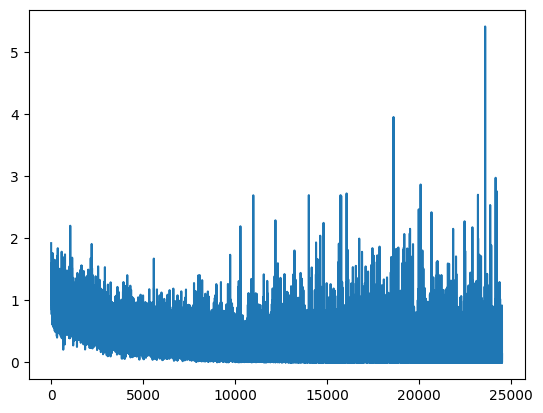

In [77]:
plt.plot(train_losses)

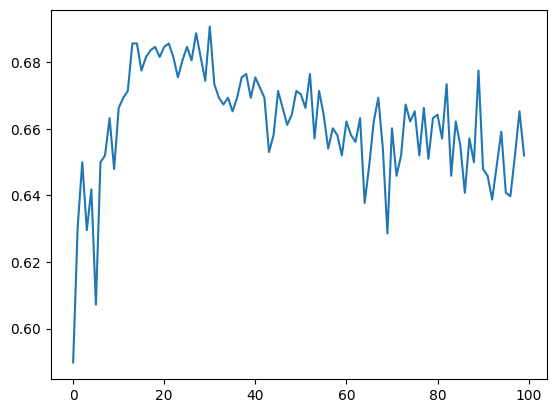

In [78]:
plt.plot(test_accuracy)

In [79]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=x_train[0].shape[0], n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4_mfcc/cremad_label4_m18mfcc_best_31epoch.pt
Correct: 677/976 (0.6936)
{'acc_detail': tensor([0.7787, 0.6590, 0.7205, 0.6111], device='cuda:0'),
 'acc_unweighted': tensor(0.6923, device='cuda:0'),
 'acc_weighted': tensor(0.6936, device='cuda:0'),
 'f1s': tensor(0.6913, device='cuda:0'),
 'f1s_detail': tensor([0.7665, 0.6398, 0.7291, 0.6299], device='cuda:0'),
 'precision_detail': tensor([0.7548, 0.6217, 0.7379, 0.6498], device='cuda:0'),
 'recall_detail': tensor([0.7787, 0.6590, 0.7205, 0.6111], device='cuda:0'),
 'rocauc': tensor([0.8934, 0.8786, 0.9147, 0.8209], device='cuda:0'),
 'uar': tensor(0.6923, device='cuda:0'),
 'wap': tensor(0.6937, device='cuda:0')}


tensor([[197,   9,   2,  45],
        [  8, 143,  47,  19],
        [  8,  44, 183,  19],
        [ 48,  34,  16, 154]], device='cuda:0')

In [80]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 200
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch4)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(1+n_epoch+n_epoch2+n_epoch3, n_epoch4+n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                            | 0.0032679738562091504/200 [00:00<4:12:34, 75.77s/it]

Train Epoch: 101 [0/3920 (0%)]	Loss: 0.000005
Mem before-during-after: 40884736 44239360 47374336


  0%|                                                               | 0.1339869281045752/200 [00:10<4:16:36, 77.03s/it]

Train Epoch: 101 [640/3920 (16%)]	Loss: 0.020947
Mem before-during-after: 47374336 50487296 47374336


  0%|                                                              | 0.26470588235294074/200 [00:19<4:11:17, 75.49s/it]

Train Epoch: 101 [1280/3920 (33%)]	Loss: 0.004280
Mem before-during-after: 47374336 49815552 47374336


  0%|                                                               | 0.3954248366013063/200 [00:29<4:10:20, 75.25s/it]

Train Epoch: 101 [1920/3920 (49%)]	Loss: 0.197312
Mem before-during-after: 47374336 50550272 47374336


  0%|▏                                                              | 0.5261437908496719/200 [00:39<4:12:20, 75.90s/it]

Train Epoch: 101 [2560/3920 (65%)]	Loss: 0.000766
Mem before-during-after: 47374336 49973248 47374336


  0%|▏                                                              | 0.6568627450980374/200 [00:49<4:10:40, 75.45s/it]

Train Epoch: 101 [3200/3920 (82%)]	Loss: 0.014271
Mem before-during-after: 47374336 50642432 47374336


  0%|▎                                                               | 0.787581699346403/200 [00:59<4:09:58, 75.29s/it]

Train Epoch: 101 [3840/3920 (98%)]	Loss: 0.122115
Mem before-during-after: 47374336 49795072 47374336


  0%|▎                                                               | 0.999999999999997/200 [01:15<4:06:07, 74.21s/it]


Test Epoch: 101	Accuracy: 626/976 (64%)



  1%|▎                                                              | 1.0032679738562063/200 [01:15<4:07:33, 74.64s/it]

Train Epoch: 102 [0/3920 (0%)]	Loss: 0.191266
Mem before-during-after: 47373312 49657856 47374336


  1%|▎                                                              | 1.1339869281045718/200 [01:25<4:10:04, 75.45s/it]

Train Epoch: 102 [640/3920 (16%)]	Loss: 0.000148
Mem before-during-after: 47374336 50781696 47374336


  1%|▍                                                              | 1.2647058823529373/200 [01:35<4:10:31, 75.63s/it]

Train Epoch: 102 [1280/3920 (33%)]	Loss: 0.030246
Mem before-during-after: 47374336 50781696 47374336


  1%|▍                                                               | 1.395424836601303/200 [01:45<4:09:19, 75.32s/it]

Train Epoch: 102 [1920/3920 (49%)]	Loss: 0.000125
Mem before-during-after: 47374336 50812416 47374336


  1%|▍                                                              | 1.5261437908496684/200 [01:54<4:08:03, 74.99s/it]

Train Epoch: 102 [2560/3920 (65%)]	Loss: 0.003253
Mem before-during-after: 47374336 50920960 47374336


  1%|▌                                                               | 1.656862745098034/200 [02:04<4:08:31, 75.18s/it]

Train Epoch: 102 [3200/3920 (82%)]	Loss: 0.628556
Mem before-during-after: 47374336 50642432 47374336


  1%|▌                                                              | 1.7875816993463995/200 [02:14<4:08:38, 75.26s/it]

Train Epoch: 102 [3840/3920 (98%)]	Loss: 0.155522
Mem before-during-after: 47374336 50519552 47374336


  1%|▋                                                              | 1.9999999999999936/200 [02:30<4:04:16, 74.02s/it]


Test Epoch: 102	Accuracy: 630/976 (64%)



  1%|▋                                                               | 2.003267973856203/200 [02:30<4:05:27, 74.38s/it]

Train Epoch: 103 [0/3920 (0%)]	Loss: 0.006958
Mem before-during-after: 47373312 49856512 47374336


  1%|▋                                                              | 2.1339869281045685/200 [02:40<4:07:12, 74.96s/it]

Train Epoch: 103 [640/3920 (16%)]	Loss: 0.000021
Mem before-during-after: 47374336 50890240 47374336


  1%|▋                                                               | 2.264705882352934/200 [02:50<4:07:05, 74.98s/it]

Train Epoch: 103 [1280/3920 (33%)]	Loss: 0.024436
Mem before-during-after: 47374336 49754112 47374336


  1%|▊                                                              | 2.3954248366012996/200 [03:00<4:07:53, 75.27s/it]

Train Epoch: 103 [1920/3920 (49%)]	Loss: 0.003716
Mem before-during-after: 47374336 49911808 47374336


  1%|▊                                                               | 2.526143790849665/200 [03:09<4:06:46, 74.98s/it]

Train Epoch: 103 [2560/3920 (65%)]	Loss: 0.000285
Mem before-during-after: 47374336 49952768 47374336


  1%|▊                                                              | 2.6568627450980307/200 [03:19<4:07:48, 75.34s/it]

Train Epoch: 103 [3200/3920 (82%)]	Loss: 0.640705
Mem before-during-after: 47374336 49836032 47374336


  1%|▉                                                               | 2.787581699346396/200 [03:29<4:08:27, 75.59s/it]

Train Epoch: 103 [3840/3920 (98%)]	Loss: 0.001897
Mem before-during-after: 47374336 50720256 47374336


  1%|▉                                                              | 2.9999999999999902/200 [03:45<4:03:58, 74.31s/it]


Test Epoch: 103	Accuracy: 633/976 (65%)



  2%|▉                                                              | 3.0032679738561994/200 [03:45<4:05:30, 74.78s/it]

Train Epoch: 104 [0/3920 (0%)]	Loss: 0.001136
Mem before-during-after: 47373312 49911808 47374336


  2%|█                                                               | 3.133986928104565/200 [03:55<4:07:46, 75.51s/it]

Train Epoch: 104 [640/3920 (16%)]	Loss: 0.005434
Mem before-during-after: 47374336 50580992 47374336


  2%|█                                                              | 3.2647058823529305/200 [04:05<4:07:15, 75.41s/it]

Train Epoch: 104 [1280/3920 (33%)]	Loss: 0.008528
Mem before-during-after: 47374336 50890240 47374336


  2%|█                                                               | 3.395424836601296/200 [04:15<4:07:18, 75.47s/it]

Train Epoch: 104 [1920/3920 (49%)]	Loss: 1.211492
Mem before-during-after: 47374336 51056640 47374336


  2%|█                                                              | 3.5261437908496616/200 [04:25<4:09:43, 76.26s/it]

Train Epoch: 104 [2560/3920 (65%)]	Loss: 0.103047
Mem before-during-after: 47374336 50487296 47374336


  2%|█▏                                                              | 3.656862745098027/200 [04:35<4:07:05, 75.51s/it]

Train Epoch: 104 [3200/3920 (82%)]	Loss: 0.000005
Mem before-during-after: 47374336 50781696 47374336


  2%|█▏                                                             | 3.7875816993463927/200 [04:44<4:08:10, 75.89s/it]

Train Epoch: 104 [3840/3920 (98%)]	Loss: 0.000603
Mem before-during-after: 47374336 50919424 47374336


  2%|█▎                                                             | 3.9999999999999867/200 [05:00<4:03:13, 74.46s/it]


Test Epoch: 104	Accuracy: 642/976 (66%)



  2%|█▎                                                              | 4.003267973856196/200 [05:01<4:04:54, 74.97s/it]

Train Epoch: 105 [0/3920 (0%)]	Loss: 0.000303
Mem before-during-after: 47373312 50466816 47374336


  2%|█▎                                                              | 4.133986928104561/200 [05:11<4:07:50, 75.92s/it]

Train Epoch: 105 [640/3920 (16%)]	Loss: 0.000013
Mem before-during-after: 47374336 50689536 47374336


  2%|█▎                                                              | 4.264705882352927/200 [05:20<4:06:23, 75.53s/it]

Train Epoch: 105 [1280/3920 (33%)]	Loss: 0.002829
Mem before-during-after: 47374336 50642432 47374336


  2%|█▍                                                             | 4.3954248366012925/200 [05:30<4:06:04, 75.48s/it]

Train Epoch: 105 [1920/3920 (49%)]	Loss: 0.294394
Mem before-during-after: 47374336 50781696 47374336


  2%|█▍                                                              | 4.526143790849658/200 [05:40<4:06:27, 75.65s/it]

Train Epoch: 105 [2560/3920 (65%)]	Loss: 0.002993
Mem before-during-after: 47374336 50519552 47374336


  2%|█▍                                                              | 4.656862745098024/200 [05:50<4:06:35, 75.74s/it]

Train Epoch: 105 [3200/3920 (82%)]	Loss: 0.003426
Mem before-during-after: 47374336 50488832 47374336


  2%|█▌                                                              | 4.787581699346389/200 [06:00<4:07:40, 76.13s/it]

Train Epoch: 105 [3840/3920 (98%)]	Loss: 0.002638
Mem before-during-after: 47374336 50890240 47374336


  2%|█▌                                                              | 4.999999999999983/200 [06:16<4:00:57, 74.14s/it]


Test Epoch: 105	Accuracy: 638/976 (65%)



  3%|█▌                                                              | 5.003267973856192/200 [06:16<4:02:20, 74.57s/it]

Train Epoch: 106 [0/3920 (0%)]	Loss: 0.000408
Mem before-during-after: 47373312 50214400 47374336


  3%|█▋                                                              | 5.133986928104558/200 [06:26<4:04:26, 75.27s/it]

Train Epoch: 106 [640/3920 (16%)]	Loss: 0.891155
Mem before-during-after: 47374336 49952768 47374336


  3%|█▋                                                              | 5.264705882352923/200 [06:36<4:01:49, 74.51s/it]

Train Epoch: 106 [1280/3920 (33%)]	Loss: 0.016518
Mem before-during-after: 47374336 50843136 47374336


  3%|█▋                                                              | 5.395424836601289/200 [06:46<4:16:39, 79.13s/it]

Train Epoch: 106 [1920/3920 (49%)]	Loss: 0.608440
Mem before-during-after: 47374336 49973248 47374336


  3%|█▋                                                             | 5.5261437908496545/200 [06:56<4:08:25, 76.64s/it]

Train Epoch: 106 [2560/3920 (65%)]	Loss: 0.000410
Mem before-during-after: 47374336 50214400 47374336


  3%|█▊                                                               | 5.65686274509802/200 [07:06<4:08:52, 76.84s/it]

Train Epoch: 106 [3200/3920 (82%)]	Loss: 0.030997
Mem before-during-after: 47374336 50429440 47374336


  3%|█▊                                                             | 5.7875816993463856/200 [07:16<4:03:37, 75.27s/it]

Train Epoch: 106 [3840/3920 (98%)]	Loss: 0.178925
Mem before-during-after: 47374336 50425856 47374336


  3%|█▉                                                               | 5.99999999999998/200 [07:32<3:57:56, 73.59s/it]


Test Epoch: 106	Accuracy: 627/976 (64%)



  3%|█▉                                                              | 6.003267973856189/200 [07:32<3:58:57, 73.91s/it]

Train Epoch: 107 [0/3920 (0%)]	Loss: 0.000937
Mem before-during-after: 47373312 50750976 47374336


  3%|█▉                                                              | 6.133986928104554/200 [07:42<4:01:23, 74.71s/it]

Train Epoch: 107 [640/3920 (16%)]	Loss: 0.357188
Mem before-during-after: 47374336 50550272 47374336


  3%|██                                                               | 6.26470588235292/200 [07:52<4:05:30, 76.03s/it]

Train Epoch: 107 [1280/3920 (33%)]	Loss: 0.000091
Mem before-during-after: 47374336 50550272 47374336


  3%|██                                                              | 6.395424836601285/200 [08:02<4:12:32, 78.27s/it]

Train Epoch: 107 [1920/3920 (49%)]	Loss: 0.000008
Mem before-during-after: 47374336 50519552 47374336


  3%|██                                                              | 6.526143790849651/200 [08:12<4:04:23, 75.79s/it]

Train Epoch: 107 [2560/3920 (65%)]	Loss: 0.000006
Mem before-during-after: 47374336 50214400 47374336


  3%|██                                                             | 6.6568627450980165/200 [08:21<4:03:53, 75.69s/it]

Train Epoch: 107 [3200/3920 (82%)]	Loss: 0.011322
Mem before-during-after: 47374336 49774592 47374336


  3%|██▏                                                             | 6.787581699346382/200 [08:31<4:00:57, 74.83s/it]

Train Epoch: 107 [3840/3920 (98%)]	Loss: 0.201117
Mem before-during-after: 47374336 49836032 47374336


  3%|██▏                                                             | 6.999999999999976/200 [08:47<4:04:31, 76.02s/it]


Test Epoch: 107	Accuracy: 634/976 (65%)



  4%|██▏                                                             | 7.003267973856185/200 [08:48<4:04:56, 76.15s/it]

Train Epoch: 108 [0/3920 (0%)]	Loss: 0.014837
Mem before-during-after: 47373312 49678336 47374336


  4%|██▎                                                             | 7.133986928104551/200 [08:57<3:59:30, 74.51s/it]

Train Epoch: 108 [640/3920 (16%)]	Loss: 0.195175
Mem before-during-after: 47374336 49911808 47374336


  4%|██▎                                                             | 7.264705882352916/200 [09:07<3:59:29, 74.55s/it]

Train Epoch: 108 [1280/3920 (33%)]	Loss: 0.060036
Mem before-during-after: 47374336 49973248 47374336


  4%|██▎                                                             | 7.395424836601282/200 [09:17<4:02:23, 75.51s/it]

Train Epoch: 108 [1920/3920 (49%)]	Loss: 0.021347
Mem before-during-after: 47374336 50425856 47374336


  4%|██▍                                                             | 7.526143790849647/200 [09:27<4:05:49, 76.63s/it]

Train Epoch: 108 [2560/3920 (65%)]	Loss: 0.000328
Mem before-during-after: 47374336 50519552 47374336


  4%|██▍                                                             | 7.656862745098013/200 [09:37<4:04:11, 76.17s/it]

Train Epoch: 108 [3200/3920 (82%)]	Loss: 0.023243
Mem before-during-after: 47374336 50441728 47374336


  4%|██▍                                                            | 7.7875816993463784/200 [09:47<4:03:20, 75.96s/it]

Train Epoch: 108 [3840/3920 (98%)]	Loss: 0.003266
Mem before-during-after: 47374336 50890240 47374336


  4%|██▌                                                            | 7.9999999999999725/200 [10:03<4:01:03, 75.33s/it]


Test Epoch: 108	Accuracy: 640/976 (65%)



  4%|██▌                                                             | 8.003267973856182/200 [10:03<4:02:56, 75.92s/it]

Train Epoch: 109 [0/3920 (0%)]	Loss: 0.001315
Mem before-during-after: 47373312 49911808 47374336


  4%|██▌                                                             | 8.133986928104548/200 [10:13<4:03:25, 76.12s/it]

Train Epoch: 109 [640/3920 (16%)]	Loss: 0.022069
Mem before-during-after: 47374336 49815552 47374336


  4%|██▋                                                             | 8.264705882352914/200 [10:23<4:03:54, 76.32s/it]

Train Epoch: 109 [1280/3920 (33%)]	Loss: 0.000192
Mem before-during-after: 47374336 50843136 47374336


  4%|██▋                                                              | 8.39542483660128/200 [10:33<4:03:44, 76.33s/it]

Train Epoch: 109 [1920/3920 (49%)]	Loss: 1.603631
Mem before-during-after: 47374336 50611712 47374336


  4%|██▋                                                             | 8.526143790849645/200 [10:43<4:04:08, 76.50s/it]

Train Epoch: 109 [2560/3920 (65%)]	Loss: 0.159333
Mem before-during-after: 47374336 49532928 47374336


  4%|██▊                                                              | 8.65686274509801/200 [10:53<4:00:41, 75.48s/it]

Train Epoch: 109 [3200/3920 (82%)]	Loss: 0.023891
Mem before-during-after: 47374336 50890240 47374336


  4%|██▊                                                             | 8.787581699346376/200 [11:03<4:02:14, 76.01s/it]

Train Epoch: 109 [3840/3920 (98%)]	Loss: 1.219113
Mem before-during-after: 47374336 50425856 47374336


  4%|██▉                                                              | 8.99999999999997/200 [11:19<3:55:09, 73.87s/it]


Test Epoch: 109	Accuracy: 637/976 (65%)



  5%|██▉                                                             | 9.003267973856179/200 [11:19<3:56:15, 74.22s/it]

Train Epoch: 110 [0/3920 (0%)]	Loss: 0.486652
Mem before-during-after: 47373312 49815552 47374336


  5%|██▉                                                             | 9.133986928104544/200 [11:29<3:58:27, 74.96s/it]

Train Epoch: 110 [640/3920 (16%)]	Loss: 0.006863
Mem before-during-after: 47374336 50441728 47374336


  5%|███                                                              | 9.26470588235291/200 [11:39<3:58:08, 74.91s/it]

Train Epoch: 110 [1280/3920 (33%)]	Loss: 0.555027
Mem before-during-after: 47374336 50843136 47374336


  5%|███                                                             | 9.395424836601276/200 [11:49<3:59:14, 75.31s/it]

Train Epoch: 110 [1920/3920 (49%)]	Loss: 0.169972
Mem before-during-after: 47374336 49932288 47374336


  5%|███                                                             | 9.526143790849641/200 [11:58<3:59:06, 75.32s/it]

Train Epoch: 110 [2560/3920 (65%)]	Loss: 0.554287
Mem before-during-after: 47374336 49678336 47374336


  5%|███                                                             | 9.656862745098007/200 [12:08<4:02:42, 76.51s/it]

Train Epoch: 110 [3200/3920 (82%)]	Loss: 0.118795
Mem before-during-after: 47374336 50411008 47374336


  5%|███▏                                                            | 9.787581699346372/200 [12:18<4:04:13, 77.04s/it]

Train Epoch: 110 [3840/3920 (98%)]	Loss: 0.000031
Mem before-during-after: 47374336 49952768 47374336


  5%|███▏                                                            | 9.999999999999966/200 [12:34<3:57:53, 75.12s/it]


Test Epoch: 110	Accuracy: 625/976 (64%)



  5%|███▏                                                           | 10.003267973856175/200 [12:35<3:58:54, 75.45s/it]

Train Epoch: 111 [0/3920 (0%)]	Loss: 0.735851
Mem before-during-after: 47373312 50580992 47374336


  5%|███▏                                                           | 10.133986928104541/200 [12:45<4:05:37, 77.62s/it]

Train Epoch: 111 [640/3920 (16%)]	Loss: 0.001983
Mem before-during-after: 47374336 50393088 47374336


  5%|███▏                                                           | 10.264705882352906/200 [12:55<3:55:59, 74.63s/it]

Train Epoch: 111 [1280/3920 (33%)]	Loss: 0.038689
Mem before-during-after: 47374336 49856512 47374336


  5%|███▎                                                           | 10.395424836601272/200 [13:04<3:56:08, 74.73s/it]

Train Epoch: 111 [1920/3920 (49%)]	Loss: 0.020925
Mem before-during-after: 47374336 49836032 47374336


  5%|███▎                                                           | 10.526143790849638/200 [13:14<4:01:54, 76.61s/it]

Train Epoch: 111 [2560/3920 (65%)]	Loss: 0.000064
Mem before-during-after: 47374336 49532928 47374336


  5%|███▎                                                           | 10.656862745098003/200 [13:24<3:56:43, 75.02s/it]

Train Epoch: 111 [3200/3920 (82%)]	Loss: 0.011352
Mem before-during-after: 47374336 49795072 47374336


  5%|███▍                                                           | 10.787581699346369/200 [13:34<3:55:44, 74.75s/it]

Train Epoch: 111 [3840/3920 (98%)]	Loss: 0.000003
Mem before-during-after: 47374336 50611712 47374336


  5%|███▍                                                           | 10.999999999999963/200 [13:50<3:53:06, 74.00s/it]


Test Epoch: 111	Accuracy: 628/976 (64%)



  6%|███▍                                                           | 11.003267973856172/200 [13:50<3:59:18, 75.97s/it]

Train Epoch: 112 [0/3920 (0%)]	Loss: 0.027101
Mem before-during-after: 47373312 50689536 47374336


  6%|███▌                                                           | 11.133986928104537/200 [14:00<4:00:15, 76.33s/it]

Train Epoch: 112 [640/3920 (16%)]	Loss: 0.082184
Mem before-during-after: 47374336 49678336 47374336


  6%|███▌                                                           | 11.264705882352903/200 [14:10<4:01:23, 76.74s/it]

Train Epoch: 112 [1280/3920 (33%)]	Loss: 0.000360
Mem before-during-after: 47374336 49911808 47374336


  6%|███▌                                                           | 11.395424836601268/200 [14:20<3:55:26, 74.90s/it]

Train Epoch: 112 [1920/3920 (49%)]	Loss: 0.000061
Mem before-during-after: 47374336 50488832 47374336


  6%|███▋                                                           | 11.526143790849634/200 [14:30<3:57:28, 75.60s/it]

Train Epoch: 112 [2560/3920 (65%)]	Loss: 0.000042
Mem before-during-after: 47374336 50843136 47374336


  6%|███▊                                                              | 11.656862745098/200 [14:39<3:55:04, 74.89s/it]

Train Epoch: 112 [3200/3920 (82%)]	Loss: 0.000340
Mem before-during-after: 47374336 49973248 47374336


  6%|███▋                                                           | 11.787581699346365/200 [14:49<3:53:19, 74.38s/it]

Train Epoch: 112 [3840/3920 (98%)]	Loss: 0.203058
Mem before-during-after: 47374336 49856512 47374336


  6%|███▊                                                            | 11.99999999999996/200 [15:05<3:49:46, 73.33s/it]


Test Epoch: 112	Accuracy: 615/976 (63%)



  6%|███▊                                                           | 12.003267973856168/200 [15:05<3:50:57, 73.71s/it]

Train Epoch: 113 [0/3920 (0%)]	Loss: 0.025040
Mem before-during-after: 47373312 49856512 47374336


  6%|███▊                                                           | 12.133986928104534/200 [15:15<3:54:24, 74.86s/it]

Train Epoch: 113 [640/3920 (16%)]	Loss: 0.004577
Mem before-during-after: 47374336 49795072 47374336


  6%|███▉                                                             | 12.2647058823529/200 [15:25<3:54:16, 74.87s/it]

Train Epoch: 113 [1280/3920 (33%)]	Loss: 0.039009
Mem before-during-after: 47374336 50890240 47374336


  6%|███▉                                                           | 12.395424836601265/200 [15:35<4:00:12, 76.82s/it]

Train Epoch: 113 [1920/3920 (49%)]	Loss: 0.000126
Mem before-during-after: 47374336 50781696 47374336


  6%|████                                                            | 12.52614379084963/200 [15:45<3:52:22, 74.37s/it]

Train Epoch: 113 [2560/3920 (65%)]	Loss: 0.079840
Mem before-during-after: 47374336 50488832 47374336


  6%|███▉                                                           | 12.656862745097996/200 [15:55<4:12:03, 80.72s/it]

Train Epoch: 113 [3200/3920 (82%)]	Loss: 0.031712
Mem before-during-after: 47374336 49973248 47374336


  6%|████                                                           | 12.787581699346362/200 [16:05<3:55:00, 75.32s/it]

Train Epoch: 113 [3840/3920 (98%)]	Loss: 0.407051
Mem before-during-after: 47374336 51015680 47374336


  6%|████                                                           | 12.849673202614335/200 [16:10<3:52:56, 74.68s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f47cab07af0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f47cab07af0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  6%|████                                                           | 12.852941176470544/200 [16:10<3:55:33, 75.52s/it]Exception ignored in: <bou


Test Epoch: 113	Accuracy: 634/976 (65%)



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f47cab07af0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  7%|████                                                           | 13.003267973856165/200 [16:21<4:04:33, 78.47s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f47cab07af0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Train Epoch: 114 [0/3920 (0%)]	Loss: 0.000652
Mem before-during-after: 47373312 50580992 47374336


  7%|████                                                           | 13.006535947712374/200 [16:22<4:05:55, 78.91s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f47cab07af0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  7%|████                                                           | 13.009803921568583/200 [16:22<4:07:26, 79.40s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f47cab07af0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  7%|████                 

KeyboardInterrupt: 

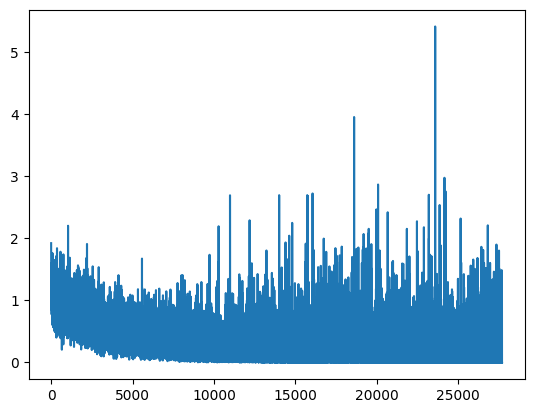

In [81]:
plt.plot(train_losses)

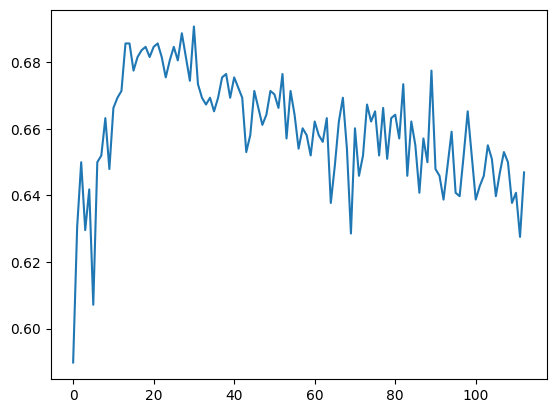

In [82]:
plt.plot(test_accuracy)

In [83]:
best_epoch

31